Spectrum-Aware Debiasing: A Modern Inference Framework with Applications to Principal Components Regression and Beyond
==============
*Author: Yufan Li, Pragya Sur*

This notebook reproduces figures in the main text and Supplementary Information (SI) Appendices of our PNAS submission.

To run the notebook successfully, be sure to:
1. Run code cells in-order which will install necessary dependencies and define necessary utility functions in the correct order
2. Change filepath to your preferred location for storing results
3. Download (from Supplementary Information) and include the following data files in the same directory as the notebook: ar.pickle, lnn.pickle, multT.pickle, norm.pickle, spike.pickle, returns.pkl, attributes.csv, communities.data. Note that the Google Colab notebook does NOT include data files and still requires user to upload them files to root directory.

In [14]:
from google.colab import drive
import pickle

# Comment out if not using google drive
drive.mount('/content/gdrive')

# Please change to your preferred location
filepath = '/content/gdrive/MyDrive/Image_pnas/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Required installations and packages



In [ ]:
!pip install yfinance
!pip install pandas_datareader
!pip install seaborn --upgrade
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [2]:
# Import libraries
import numpy as np
from scipy.linalg import sqrtm
import numpy as np
from numpy import linalg as LA
from sklearn.linear_model import Lasso
from scipy.stats import multivariate_t
from scipy.stats import norm as normst
from scipy.stats import ortho_group
from scipy.stats import semicircular
from scipy.stats import bernoulli
from scipy.stats import t
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
from statistics import NormalDist
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from prettytable import PrettyTable
import pandas as pd
from scipy.stats import invwishart
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture
import yfinance as yf
import bs4 as bs
import datetime as dt
import os
import pandas_datareader.data as web
import pickle
import requests
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
import statsmodels.tsa.vector_ar.var_model as var
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from IPython.display import HTML
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'

# Prerequisite and utility functions

Below are prerequisite functions implementing
- Logic of the debiasing methodologies
- Data simulation, extraction and cleaning routines
- Plotting utilities

In [9]:
### Implement main Spectrum-Aware Debiasing logic ###

def vdb(X,y,Sigmap,v, beta_hat, h_pp):
    # SA-Debiasing regularized beta_hat

    # ===Input===
    # X: design matrix
    # y: response
    # Sigmap: the right-multiplied covariance matrix to the design
    # v: eigenvalues of design matrix with Sigmap removed on the right
    # beta_hat: the regularized estimator
    # h_pp: Hessian of penalty function evaluated at beta_hat

    # Compute spectrum and inverse of Sigmap
    s, S=LA.eigh(Sigmap)
    Sigmapinv=LA.inv(Sigmap)

    # Read dimension and sample size
    n=X.shape[0]
    p=X.shape[1]

    # Equation for solving gamma
    def gamma_inv_s(x):
        return np.mean(1/((v*x-1)*(np.mean(s/(s+x*h_pp)))+1))-1

    # Compute state evolution fixed points gamma, eta
    try:
        gamma_inv=optimize.newton(gamma_inv_s, p/np.sum(v))
    except:
        gamma_inv=optimize.brentq(gamma_inv_s, 1/(max(v)+0.1), 10000)
    gamma=1/gamma_inv
    eta_inv=gamma_inv*np.mean(s/(s+gamma_inv*h_pp))
    eta=1/eta_inv

    # Compute vamp iterates
    correction=Sigmapinv@(X.T)@(y-X@beta_hat)
    r1=beta_hat+gamma_inv*correction # debiased estimator to output
    r2=beta_hat-1/(eta-gamma)*correction # will be used to compute tau1, tau2
    r2error=1/p*LA.norm(X@(r2)-y )**2

    # Fitting error
    fiterror=1/p*LA.norm(y-X@beta_hat)**2

    # sigma**2 estimator
    dD=np.mean(v/(v+eta-gamma)**2)
    dE=np.mean(v**2/(v+eta-gamma)**2)
    sigmasq_hat=(r2error*dD*(eta-gamma)**2-fiterror*np.mean(v))/(n/p*dD*(eta-gamma)**2-np.mean(v)*(n/p+dE-2*gamma/eta))
    sigmasq_hat=max(0,sigmasq_hat)

    # Compute tau2 from r2
    tau2=1/(np.mean(v))*(1/p*LA.norm(X@(r2)-y )**2-n/p*sigmasq_hat)

    # Compute tau1: variance of debiased estimator r1
    b=(eta/gamma)**2*dD*sigmasq_hat
    kappa=((eta-gamma)**2/(gamma**2)*eta**2*1/p*np.sum(1/(v+eta-gamma)**2)-(eta-gamma)**2/(gamma**2))
    tau1=b+kappa*tau2

    return r1, gamma, eta, tau1, tau2, s, sigmasq_hat

In [4]:
### Plotting Utilities ###


def plot_D(data, true_mean, axsi, title=' ',pdfplt=1):
    # This is a auxiliary function providing plotting functionality
    # Create the histogram
    n, bins, patches = axsi.hist(data, bins=50, density=True, alpha=0.5)

    # Compute mean, variance
    mean=np.mean(data)
    variance=np.var(data)

    # Add a line for the true mean
    axsi.axvline(true_mean, color='red', linestyle='dashed', linewidth=2)

    # Add a line for the estimated mean
    axsi.axvline(mean, color='black', linestyle='dashed', linewidth=2)

    # Compute the normal pdf
    x = np.linspace(min(bins), max(bins), 100)
    pdf = 1/np.sqrt(2*np.pi*variance)*np.exp(-(x-mean)**2/(2*variance))

    # Plot the normal pdf
    if pdfplt==1:
        axsi.plot(x, pdf, color='black', linewidth=2)

    axsi.set_title(title, y=-0.15, fontsize=20)


def plot_C(data,true_mean, axsi, title=' ',pdfplt=1):
    # This is a auxiliary function providing plotting functionality
    # Create the histogram
    sns.set_style("white", {"axes.facecolor": (0.9, 0.9, 0.9, 0.5)})

    maincol='black'
    shadcol='steelblue'
    norcol='tab:red'
    lw=4.5

    n, bins, patches = axsi.hist(data, bins=20, density=True, alpha=0.5, color=shadcol)

    # Add a line for the true mean
    axsi.axvline(true_mean, color=norcol, linestyle='dashed', linewidth=lw)

    # Add a line for the estimated mean
    axsi.axvline(np.mean(data), linestyle='dashed', linewidth=lw, color=maincol)

    # Compute the normal pdf
    mean, variance=0,1
    x = np.linspace(min(bins), max(bins), 100)
    pdf = 1/np.sqrt(2*np.pi*variance)*np.exp(-(x-mean)**2/(2*variance))
    mean, variance=np.mean(data),np.var(data)
    pdf2 = 1/np.sqrt(2*np.pi*variance)*np.exp(-(x-mean)**2/(2*variance))

    # Plot the normal pdf
    if pdfplt==1:
        axsi.plot(x, pdf, color=norcol, linewidth=lw)
        axsi.plot(x, pdf2, linewidth=lw, color=maincol)


    axsi.set_title(title, y=-0.15, fontsize=20)

def plot_Q(data,axsi):

    datalen=len(data)
    axsi.plot(stats.norm.ppf(np.linspace(0.01, 0.99, datalen)), np.sort(data), '.', marker='^', markersize=10, color='steelblue', label='Data', markerfacecolor=(0.275, 0.510, 0.706,0.4))
    axsi.plot(stats.norm.ppf(np.linspace(0.01, 0.99, datalen)), stats.norm.ppf(np.linspace(0.01, 0.99, datalen)), color='tab:red', label='Theoretical Quantiles',linewidth=6)
    return

def plot_Spectrum(data, axsi, title=' ',pdfplt=1):
    # This is a auxiliary function providing plotting functionality

    # Create the histogram
    n, bins, patches = axsi.hist(data, bins=20, density=False)

    axsi.set_title(title, y=-0.15, fontsize=20)

def plot_S(data, true_mean, axsi, title=' ',pdfplt=1):
    # This is a auxiliary function providing plotting functionality
    # Create the histogram
    data=data.reshape(-1,1)
    n, bins, patches = axsi.hist(data, bins=50, density=True, alpha=0.5)

    # Add a line for the true mean
    axsi.axvline(true_mean, color='red', linestyle='dashed', linewidth=2)

    # Compute the normal pdf
    gm = GaussianMixture(n_components=2, random_state=0).fit(data)
    x = np.linspace(min(bins), max(bins), 100)

    # Add a line for mode of signal
    axsi.axvline(np.max(gm.means_), color='black', linestyle='dashed', linewidth=2)

    # Plot the normal pdf
    if pdfplt==1:
        log_prob = gm.score_samples(x.reshape(-1, 1))
        prob = np.exp(log_prob)
        axsi.plot(x, prob, label='GMM Density')

    axsi.set_title(title, y=-0.15, fontsize=20)
    return np.max(gm.means_)

def plot_Ss(data, true_mean, axsi, title=' ',pdfplt=1):
    # This is a auxiliary function providing plotting functionality
    # Create the histogram
    data=data.reshape(-1,1)
    n, bins, patches = axsi.hist(data, bins=50, density=True, alpha=0.5)

    # Add a line for the true mean
    axsi.axvline(true_mean, color='red', linestyle='dashed', linewidth=2)
    axsi.axvline(-true_mean, color='red', linestyle='dashed', linewidth=2)

    # Compute the normal pdf
    gm = GaussianMixture(n_components=3, random_state=0).fit(data)
    x = np.linspace(min(bins), max(bins), 100)

    # Add lines for mode of signal
    axsi.axvline(np.max(gm.means_), color='black', linestyle='dashed', linewidth=2)
    axsi.axvline(np.min(gm.means_), color='black', linestyle='dashed', linewidth=2)

    # Plot the normal pdf
    if pdfplt==1:
        log_prob = gm.score_samples(x.reshape(-1, 1))
        prob = np.exp(log_prob)
        axsi.plot(x, prob, label='GMM Density')

    axsi.set_title(title, y=-0.15, fontsize=20)
    return np.max(gm.means_)

def plot_design_entries(data, axsi, title=' '):
    # This is a auxiliary function providing plotting functionality
    # Create the histogram
    n, bins, patches = axsi.hist(data, bins=50, density=True, alpha=0.5)

    # Compute mean, variance
    mean=np.mean(data)

    # Add a line for the true mean
    axsi.axvline(0, color='red', linestyle='dashed', linewidth=2)

    # Add a line for the estimated mean
    axsi.axvline(mean, color='black', linestyle='dashed', linewidth=2)

    # Compute the normal pdf
    x = np.linspace(min(bins), max(bins), 100)
    pdf = 1/np.sqrt(2*np.pi)*np.exp(-(x)**2/(2))

    # Plot the normal pdf
    axsi.plot(x, pdf, color='black', linewidth=2)

    axsi.set_title(title, y=-0.15)

def outputtable(df, filename, rndigits=3):
    df=df.round(rndigits)
    with open(filename, "w") as file:
        latex_table = df.to_latex(index=True)
        file.write(latex_table)


In [6]:
### Functions generating data (for simulation experiments) or extract data (for real-data experiments) ###

def Gaussian_signal(p):
    return np.random.normal(10, 1, p)

def sparse_signal(p,s,mag, balance=0.5):
    magl, magr=mag[0], mag[1]
    unif=np.random.uniform(0,1,size=p)
    beta=np.zeros(p)
    beta[(unif<s/p) & (unif>(s/p)*balance)]=magr+np.random.normal(0,1,np.sum((unif<s/p) & (unif>(s/p)*balance)))
    beta[unif<s/p*balance]=-magl+np.random.normal(0,1,np.sum(unif<s/p*balance))
    return beta

def sparse_signal_s(p,s,mag):
    unif=np.random.uniform(0,1,size=p)
    beta=(unif<s/p)*(unif>(s/p)/2)*(mag)+(unif<s/p/2)*(-mag)
    return beta

def mix_signal(p,s,mag, balance=0.5):
    magl, magr=mag[0], mag[1]
    unif=np.random.uniform(0,1,size=p)
    beta=np.zeros(p)
    beta[(unif<s/p) & (unif>(s/p)*balance)]=magr+np.random.normal(0,1,np.sum((unif<s/p) & (unif>(s/p)*balance)))
    beta[unif<s/p*balance]=-magl+np.random.normal(0,1,np.sum(unif<s/p*balance))
    return beta

def Gaussian_design(n,p, arn, arp):

    # Covariance matrix to be right-multipled
    Sigmap=np.identity(p)
    for i in range(p):
        for j in range(p):
            Sigmap[i,j]=arp**np.abs(i-j)

    # Covariance matrix to be left-multipled
    Sigman=np.identity(n)
    for i in range(n):
        for j in range(n):
            if i==j:
                dec=0
            else:
                dec=np.abs(i-j)
            Sigman[i,j]=arn**dec

    # Simulate design matrix
    Sigmaprt=sqrtm(Sigmap)
    X_v=1/np.sqrt(n)*sqrtm(Sigman)@np.random.normal(0,1,size=(n,p))
    X=X_v@Sigmaprt

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, Sigmap

def tiid_design(n,p, arn, arp, df=10):

    # Covariance matrix to be right-multipled
    Sigmap=np.identity(p)
    for i in range(p):
        for j in range(p):
            Sigmap[i,j]=arp**np.abs(i-j)

    # Covariance matrix to be left-multipled
    Sigman=np.identity(n)
    for i in range(n):
        for j in range(n):
            if i==j:
                dec=0
            else:
                dec=np.abs(i-j)
            Sigman[i,j]=arn**dec

    # Simulate design matrix
    Sigmaprt=sqrtm(Sigmap)
    X_v=1/np.sqrt(n)*sqrtm(Sigman)@np.random.standard_t(df=df,size=(n,p))
    X=X_v@Sigmaprt

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, Sigmap

def bern_design(n,p):
    X_v=2*np.random.randint(2, size=(n, p))-1
    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))

    return X_v

def simpleNormal_design(n,p):
    X_v=np.random.normal(0,1,(n,p))
    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))

    return X_v

def paretoiid_design(n,p, arn, arp, df=10):

    # Covariance matrix to be right-multipled
    Sigmap=np.identity(p)
    for i in range(p):
        for j in range(p):
            Sigmap[i,j]=arp**np.abs(i-j)

    # Covariance matrix to be left-multipled
    Sigman=np.identity(n)
    for i in range(n):
        for j in range(n):
            if i==j:
                dec=0
            else:
                dec=np.abs(i-j)
            Sigman[i,j]=arn**dec

    # Simulate design matrix
    Sigmaprt=sqrtm(Sigmap)
    X_v=1/np.sqrt(n)*sqrtm(Sigman)@(stats.pareto.rvs(df,size=(n,p)))
    X=X_v@Sigmaprt

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, Sigmap

def dirMultinom_design(n,p,N):

    # Dirichlet
    P=stats.dirichlet.rvs(np.ones(p), size=1)

    # Generate samples from the distribution
    samples = stats.multinomial.rvs(n=N, p=P[0], size=n)

    # Simulate design matrix
    X_v=1/np.sqrt(n)*samples

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X_v

    return X_v, X, np.identity(p)



def multiT_design(n,p, arn, arp,df=5):
    # Covariance matrix to be right-multipled
    Sigmap=np.identity(p)
    for i in range(p):
        for j in range(p):
            Sigmap[i,j]=arp**np.abs(i-j)

    # Covariance matrix to be left-multipled
    Sigman=np.identity(n)
    for i in range(n):
        for j in range(n):
            if i==j:
                dec=0
            else:
                dec=np.abs(i-j)
            Sigman[i,j]=arn**dec


    # Create the multivariate t-distribution object
    mv_t = stats.multivariate_t(np.zeros(p), np.identity(p), df=df)

    # Generate 1000 samples from the distribution
    samples = mv_t.rvs(size=n)

    # Simulate design matrix
    Sigmaprt=sqrtm(Sigmap)
    X_v=1/np.sqrt(n)*sqrtm(Sigman)@samples
    X=X_v@Sigmaprt

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, Sigmap

def crime_design(n):
    # Get data
    attrib = read_csv('attributes.csv', delim_whitespace = True)
    data = read_csv('communities.data', names = attrib['attributes'])

    # Drop these columns features due to non-predictiveness and missingness
    data = data.drop(columns=['state','county',
                              'community','communityname',
                              'fold'], axis=1)

    # Dropped columns with na
    data = data.replace('?', np.nan)
    data = data.dropna(axis=1)

    # Features and response
    X_f = data.iloc[:, 0:99].values

    #y = data.iloc[:, 99].values

    X=X_f[-n:,:]
    X=(X-np.mean(X, axis=0))/(np.std(X,axis=0))
    v,V=LA.eigh(X.T@X)
    X=X/np.sqrt(np.mean(v))
    X_v=X
    return X_v, X, np.identity(X.shape[1])

def face_design():
    faces = fetch_lfw_people(min_faces_per_person=60)
    X=faces.data
    X=(X-np.mean(X, axis=0))/(np.std(X,axis=0))
    v,V=LA.eigh(X.T@X)
    X=X/np.sqrt(np.mean(v))
    X_v=X
    return X_v, X, np.identity(X.shape[1])


def spike_design(n,p,m=1,mag=1,mag2=1):

    Ol=ortho_group.rvs(dim=n, size=1)
    Or=ortho_group.rvs(dim=p, size=1)
    spikel=Ol[:,:m]
    spiker=Or[:m,:]

    X_v=mag*spikel@spiker+mag2/np.sqrt(n)*np.random.normal(0,1,size=(n,p))
    X=X_v

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, np.identity(p)


def spike_design_arr(n,p,marr,mag2=1):
    m=len(marr)
    Ol=ortho_group.rvs(dim=n, size=1)
    Or=ortho_group.rvs(dim=p, size=1)
    spikel=Ol[:,:m]
    spiker=Or[:m,:]

    X_v=spikel@np.diag(marr)@spiker+mag2/np.sqrt(n)*np.random.normal(0,1,size=(n,p))
    X=X_v

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X_v, X, np.identity(p)

def invWishart_design(n,p,df=2):

    # Simulate design matrix
    X=1/np.sqrt(n)*np.random.normal(0,1,size=(n,p))
    nu=p+df
    Sigmap_hid = invwishart.rvs(df=nu, scale=np.eye(p))
    Sigmap_hid=Sigmap_hid*(df-1)
    Sigmaprt_hid=sqrtm(Sigmap_hid)
    X=X@Sigmaprt_hid
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    v, V=LA.eigh(Sigmap_hid)

    return X_v, X, np.identity(p)


def corrGau_design(n,p,arn=0.5,df=2):

    # Covariance matrix to be left-multipled
    Sigman=np.identity(n)
    for i in range(n):
        for j in range(n):
            if i==j:
                dec=0
            else:
                dec=np.abs(i-j)
            Sigman[i,j]=arn**dec

    # Simulate design matrix
    X=1/np.sqrt(n)*np.random.normal(0,1,size=(n,p))
    nu=p+df
    Sigmap_hid = invwishart.rvs(df=nu, scale=np.eye(p))
    Sigmap_hid=Sigmap_hid*(df-1)
    Sigmaprt_hid=sqrtm(Sigmap_hid)
    X=sqrtm(Sigman)@X@Sigmaprt_hid
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    v, V=LA.eigh(Sigmap_hid)

    return X_v, X, np.identity(p)

def speech_design(dataID, lastRows=100):

    # Load the dataset from OpenML
    df = fetch_openml(data_id=dataID, as_frame=True).data
    df=df.tail(lastRows)

    # Process columns with string values using one-hot encoding
    string_columns = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=string_columns)

    df=(df - df.mean()) / df.std()


    # Drop columns with more than 30% missing values
    missing_percentages = df.isnull().mean()
    threshold = 0.3  # 30% threshold for missing values
    columns_to_drop = missing_percentages[missing_percentages > threshold].index
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill missing values in the remaining columns with the column average
    df.fillna(df.median(numeric_only=True).round(1), inplace=True)

    # Extract the target variable and features
    X = df.to_numpy('float32')

    # Standardize X
    v, V=LA.eigh(X.T@X)
    X=1/np.sqrt(np.mean(v))*X

    return X, X, np.identity(X.shape[1])


def dna_design(dataID, lastRows=100):

    # Step1. Load the dataset from OpenML
    df = fetch_openml(data_id=dataID, as_frame=True).data
    df=df.tail(lastRows)

    # Process columns with string values using one-hot encoding
    string_columns = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=string_columns)

    # Drop columns with more than 30% missing values
    missing_percentages = df.isnull().mean()
    threshold = 0.3  # 30% threshold for missing values
    columns_to_drop = missing_percentages[missing_percentages > threshold].index
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill missing values in the remaining columns with the column average
    df.fillna(df.median(numeric_only=True).round(1), inplace=True)

    # Extract the target variable and features
    X = df.to_numpy('float32')
    X=(X-np.mean(X, axis=0))/(np.std(X,axis=0))

    # Standardize X
    v, V=LA.eigh(X.T@X)
    X=1/np.sqrt(np.mean(v))*X

    return X, X, np.identity(X.shape[1])


def AR_design(n,p):

    X = np.zeros((n, p))
    for i in range(p):
        arparams=np.array([1,-0.6, -0.2,-0.1])
        maparams=np.array([1,-0.6, -0.2,-0.1])
        ar_process = ArmaProcess(arparams, maparams)
        if ar_process.isstationary==False:
            raise ValueError("Not stationary")
        X[:, i] = ar_process.generate_sample(nsample=n)

    std=np.std(X,axis=0)
    X=1/np.sqrt(n)*np.divide(X, std)
    v, V=LA.eigh(X.T@X)
    X=1/np.sqrt(np.mean(v))*X

    return X, X, np.identity(p)

def VAR_design(n,p,ar=0.5,df=100):

    nu=p+df
    sigma_u=invwishart.rvs(df=nu, scale=np.eye(p))*(df-1)
    coefs=np.array([ar*np.identity(p), 0.2*np.identity(p), 0.1*np.identity(p)])
    var_process = var.VARProcess(coefs, None, sigma_u)

    # Simulate the VAR process
    X = var_process.simulate_var(n,None,19)
    v, V=LA.eigh(X.T@X)
    X=1/np.sqrt(np.mean(v))*X

    #plt.plot(X[:,0:3])
    return X, X, np.identity(p)

def VARH_design(n,p,ar=0.5,df=100):

    n,p=p,n
    nu=p+df
    sigma_u=invwishart.rvs(df=nu, scale=np.eye(p))*(df-1)
    coefs=np.array([ar*np.identity(p), 0.2*np.identity(p), 0.1*np.identity(p)])
    var_process = var.VARProcess(coefs, None, sigma_u)

    # Simulate the VAR process
    X = var_process.simulate_var(n,None,19)
    X=X.T
    n,p=p,n

    v, V=LA.eigh(X.T@X)
    X=1/np.sqrt(np.mean(v))*X

    return X, X, np.identity(p)

def lnn_design(n,p,d=4):
    dim= np.random.choice(np.arange(min(n,p), max(n,p)), d-1, replace=False)
    dim=np.append(dim, p)
    dim=dim.astype(int)
    X=np.random.normal(0,1,(n,dim[0]))
    for i in range(d-1):
        X=X@np.random.normal(0,1,(dim[i],dim[i+1]))
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X, X, np.identity(p)

def lnn_design_mis(n,p,d=4):
    dim= np.random.choice(np.arange(min(n,p), max(n,p)+1), d-1, replace=True)
    dim=np.append(dim, p)
    dim=dim.astype(int)
    #print(dim)
    X=np.random.normal(0,1,(n,dim[0]))
    for i in range(d-1):
        X=X@np.random.normal(0,1,(dim[i],dim[i+1]))
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X, X, np.identity(p)

def lnn_design_pw(n,p,d=4):

    X=np.random.normal(0,1,(n,n))
    X=LA.matrix_power(X,d-1)
    X=X@np.random.normal(0,1,(n,p))
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X, X, np.identity(p)

def lnn_design_pwr(n,p,d=1):

    X=np.random.normal(0,1,(n,n))
    X=LA.matrix_power(X,d)
    Y=np.random.normal(0,1,(n,p))
    R=np.random.normal(0,1,(p,p))
    R=LA.matrix_power(R,d)

    X=X@Y@R
    X_v=X

    # Rescale so that spectrum is 1
    v, V=LA.eigh(X_v.T@X_v)
    X_v=X_v/np.sqrt(np.mean(v))
    X=X/np.sqrt(np.mean(v))

    return X, X, np.identity(p)

def remove_corr(returns, corr=0.9):
    # compute correlation matrix of returns
    corr_matrix = returns.corr()

    # create a list to keep track of columns to remove
    to_remove = []

    # loop over pairs of columns in the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            # check if the correlation between the two columns is higher than 0.95
            if abs(corr_matrix.iloc[i, j]) > corr:
                # add the column with the higher average correlation to the list of columns to remove
                if corr_matrix.iloc[:,i].mean() > corr_matrix.iloc[:,j].mean():
                    to_remove.append(corr_matrix.columns[j])
                else:
                    to_remove.append(corr_matrix.columns[i])

    # remove columns with high correlation
    returns = returns.drop(to_remove, axis=1)
    return returns

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers


def get_tickers(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    tickers=[s.strip() for s in tickers]

    return tickers

def grab_stockdata(date_start='2016-01-01', date_end='2022-12-31', corr=1):
    # ticker_file: all tickers to read
    # date_start, date_end: the date range to read
    # corr: remove columns that are strongly correlated with correlation coeff above corr

    stocks=get_tickers(False)

    # Download the daily returns for each stock
    returns = pd.DataFrame()
    for stock in stocks:
        data = yf.download(stock, start=date_start, end=date_end)['Adj Close'].pct_change()
        data.rename(stock, inplace=True)
        returns = pd.concat([returns, data], axis=1)

    # drop first row where there is no return
    returns = returns.drop(returns.index[0])

    # Define the threshold for missing values
    threshold = returns.shape[0] / 10

    # Remove columns with more than threshold missing values
    returns = returns.loc[:, returns.isna().sum() <= threshold]

    # Fill missing data and drop tickers that cannot be read
    returns = returns.fillna(method='ffill')
    returns = returns.dropna(axis=1)

    # remove highly correlated columns
    returns=remove_corr(returns,corr)

    # cache result
    returns.to_pickle("returns.pkl")
    return returns

def stock_design(use_pickle=False, pkl_file='returns.pkl', date_start='2016-01-01', date_end='2022-12-31', corr=1, lastRows=300):
    # n,p must not be larger than available size; will select rows and columns from start
    # use_pickle: If true, read from

    if use_pickle:
        returns=pd.read_pickle(pkl_file)
    else:
        returns=grab_stockdata(date_start, date_end, corr)

    returns = returns.dropna(axis=0)

    # to numpy
    X=returns.values
    X=X[-lastRows:,:]
    X=(X-np.mean(X, axis=0))/(np.std(X,axis=0))
    v,V=LA.eigh(X.T@X)
    rc=np.sqrt(np.mean(v))
    X=X/rc

    return X, X, np.identity(X.shape[1])

In [10]:
def vdbEN(beta_hat,y,X,X_v,Sigmap,lam_l1, lam_l2):

    # Compute spectrum of design with Sigmap removed
    v, V=LA.eigh(X_v.T@X_v)

    # Compute Hessian of penalty function evaluated at beta_hat
    h_pp=(np.abs(beta_hat)<0.0000001)*10000000000+(np.abs(beta_hat)>=0.0000001)*lam_l2

    # Compute debaised estimator
    beta_deb_o, gamma, eta, tau1, tau2, s, sigmasq_hat=vdb(X,y,Sigmap,v, beta_hat,h_pp)

    return beta_deb_o, gamma, eta, tau1, tau2, s,v,sigmasq_hat


def vdbG(beta_hat, y,X,X_v,Sigmap,lam_l1, lam_l2):
    try:
        Phiinvc=NormalDist(mu=0, sigma=1).inv_cdf(0.75)
        Sigmapinv=LA.inv(Sigmap)
        if np.sum(np.abs(beta_hat)>0.0000001)==0:
            return Sigmapinv@(X.T)@(y), (1/Phiinvc*np.median(np.abs(y)))**2
        elif np.sum(np.abs(beta_hat)>0.0000001)==1:
            Xhat=X[:,np.where(np.abs(beta_hat)>0.0000001)]
            Xhat=Xhat.squeeze()
            pd=len(Xhat)
        else:

            Xhat=X[:,np.where(np.abs(beta_hat)>0.0000001)]
            Xhat=Xhat.squeeze()
            pd=Xhat.shape[1]

        mu=1/(1-1/n*np.trace(LA.inv(Xhat.T@Xhat+lam_l2*np.identity(pd))@Xhat.T@Xhat))
        beta_deb_g=beta_hat+mu*Sigmapinv@(X.T)@(y-X@beta_hat)
        taug=(1/Phiinvc*(mu)*np.median(np.abs(y-X@beta_hat)))**2
        return beta_deb_g, taug
    except:
        print('ERROR', Xhat, Xhat.shape)



# Spectrum-Aware Debiasing (without PCR)

In this section, we reproduces figures associated with the Spectrum-Aware Debiasing methods from Section 3 of the main paper as well as related figures from SI Appendix.

In [11]:
### Run SA and DF Debiasing ###
def run_va(X_v, X, Sigmap, beta, designname,signalname, rndigits=3, lam_l1=1, lam_l2=0.5, is_dense=1, mag=100, is_print=False, is_center=False):

    # dimension, sample size
    n,p=X.shape

    # Simulate response
    ep=np.random.normal(0,1,size=n)
    y=X@beta+ep

    # Compute regularized estimator
    clf=ElasticNet(alpha=1/n*(lam_l1+lam_l2),l1_ratio=(lam_l1/(lam_l1+lam_l2)),fit_intercept=False)
    clf.fit(X,y)
    beta_hat=clf.coef_

    # VAMP debiasing
    beta_deb_o, gamma, eta, tau1, tau2, s,v,_=vdbEN(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)

    # Gaussian debiasing
    beta_deb_g, taug=vdbG(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)

    return beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta

The cell below reproduces:

- Fig 1, Top Panel  

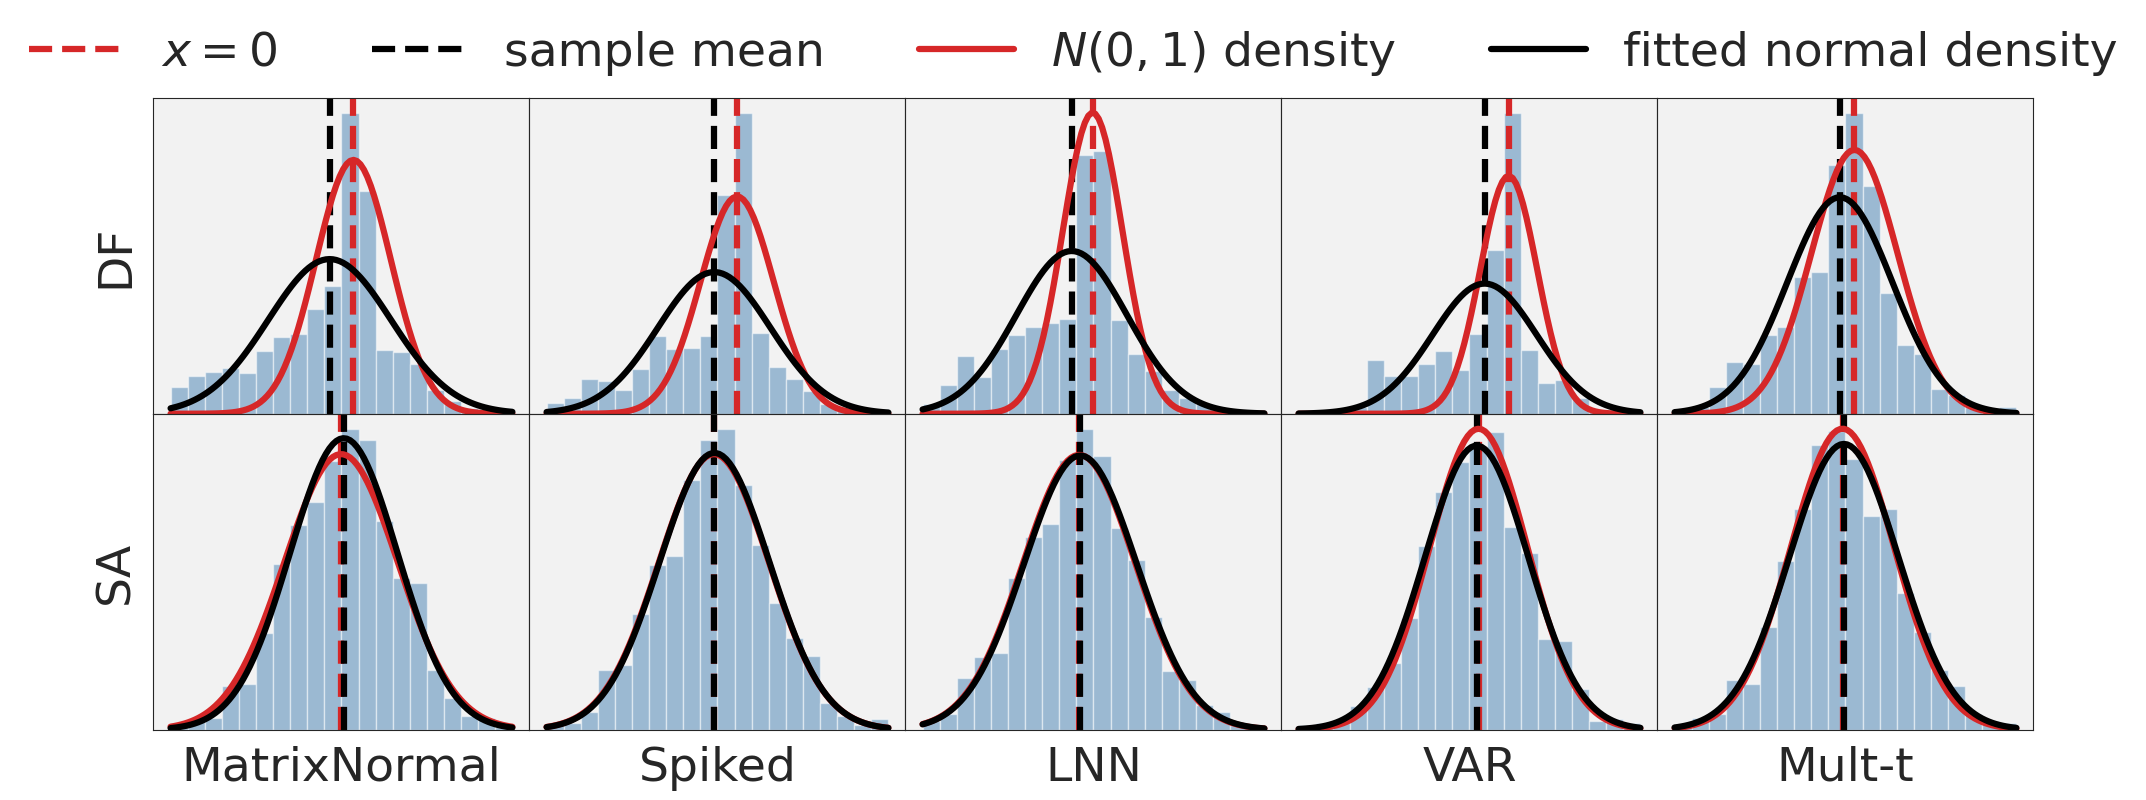

In [22]:
### Plain SA vs DF debiasing: Histograms of Emp. Distribution ###
np.random.seed(20)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

n,p,s,balance,lam_l1,lam_l2=500,1000,300,0.8,1,0.1
mag=[-20,10]
is_center=True
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

X_v, X, Sigmap=corrGau_design(n, p, arn=0.5, df=100)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,0], '')
plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,0], '')

X_v, X, Sigmap=spike_design(n, p, m=50, mag=10)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g,  taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_stdGauss=X
plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,1], '')
plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,1], '')

X_v, X, Sigmap=lnn_design(n, p)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,2], '')
plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,2], '')

X_v, X, Sigmap=VAR_design(n, p, 0.4,100)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,3], '')
plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,3], '')

X_v, X, Sigmap=multiT_design(n, p,arn=0., arp=0.0,df=3)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,4], '')
plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,4], '')


xlab=['MatrixNormal', 'Spiked' ,'LNN', 'VAR', 'Mult-t']
ylab=['DF', 'SA']
for i in range(2):
    for j in range(5):
        axs[i, j].set_xlabel(xlab[j], fontsize=34)
        axs[i, j].set_ylabel(ylab[i], fontsize=34)
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticklabels([])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


fig.subplots_adjust(left=0.05, right=0.99, bottom=0.09, top=0.88, wspace=0, hspace=0)
fig.legend([r'$x=0$','sample mean', r'$N(0,1)$ density','fitted normal density'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.51, 1.02), edgecolor='white',facecolor='white')
filename=filepath+'panel.pdf'
plt.savefig(filename)

The cell below reproduces:

- Fig. S9 from SI Appendix (QQ plot for Fig. 1, Top Panel)

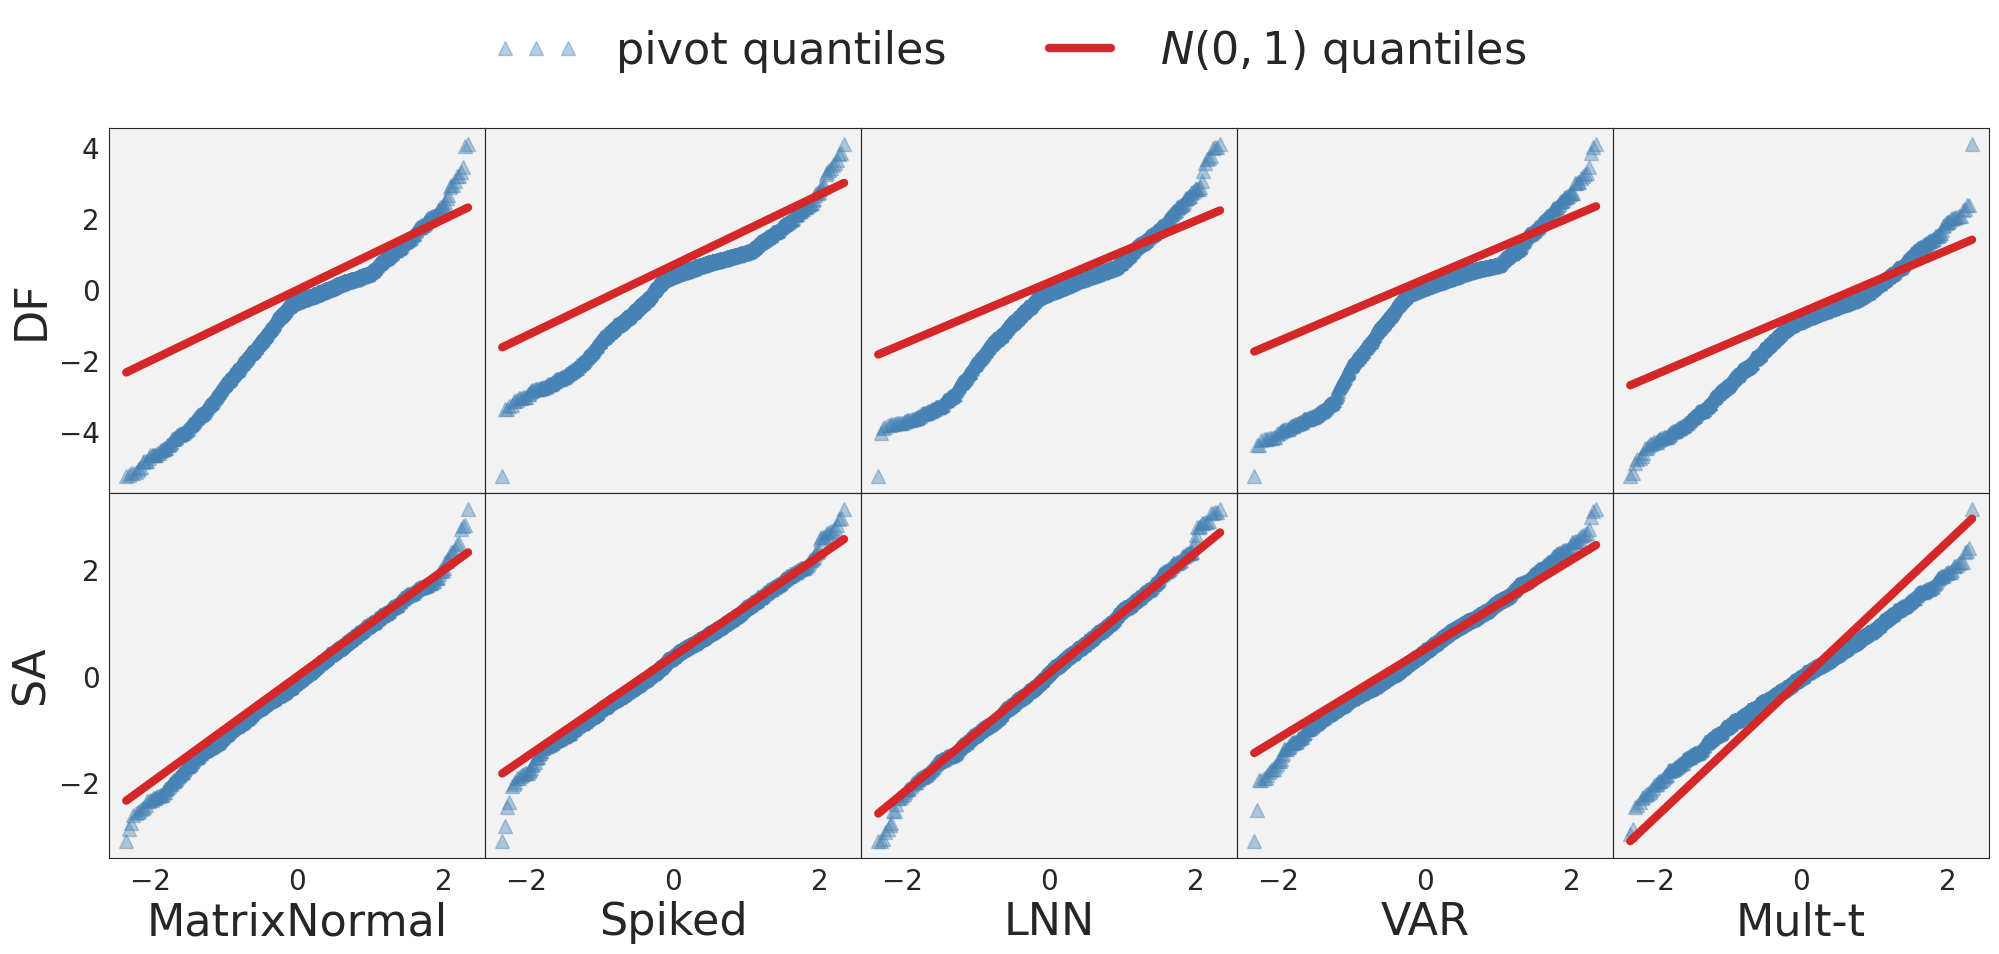

In [23]:
### Plain SA vs DF debiasing: QQ Plots of Emp. Distribution ###

np.random.seed(19)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

n,p,s,balance,lam_l1,lam_l2=500,1000,300,0.8,1,0.1
mag=[-20,10]
is_center=True
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

X_v, X, Sigmap=corrGau_design(n, p, arn=0.5, df=100)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,0])
plot_Q((beta_deb_o-beta)/np.sqrt(tau1),axs[1,0])

X_v, X, Sigmap=spike_design(n, p, m=50, mag=10)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_stdGauss=X
plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,1])
plot_Q((beta_deb_o-beta)/np.sqrt(tau1), axs[1,1])

X_v, X, Sigmap=lnn_design(n, p)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,2])
plot_Q((beta_deb_o-beta)/np.sqrt(tau1),axs[1,2])

X_v, X, Sigmap=VAR_design(n, p, 0.4,100)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,3])
plot_Q((beta_deb_o-beta)/np.sqrt(tau1),axs[1,3])

X_v, X, Sigmap=multiT_design(n, p,arn=0., arp=0.0,df=3)
Sigmap=np.identity(p)
beta=mix_signal(p,s,mag,balance)
beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, Sigmap, beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
X_corGauss=X
plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,4])
plot_Q((beta_deb_o-beta)/np.sqrt(tau1),axs[1,4])

xlab=['MatrixNormal', 'Spiked' ,'LNN', 'VAR', 'Mult-t']
ylab=['DF', 'SA']
for i in range(2):
    for j in range(5):
        axs[i, j].set_xlabel(xlab[j], fontsize=32)
        axs[i, j].set_ylabel(ylab[i], fontsize=32)
        axs[i, j].tick_params(axis='x',labelsize=20)
        axs[i, j].tick_params(axis='y',labelsize=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig.legend(['pivot quantiles', r'$N(0,1)$ quantiles'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.5, 1.02), edgecolor='white', numpoints=3,facecolor='white')

filename=filepath+'panel_QQ.pdf'
fig.savefig(filename)

The cell below reproduces:

- Fig. S2 from SI Appendix (entry-wise histograms of the pivotal quantity under exchangeability condition)

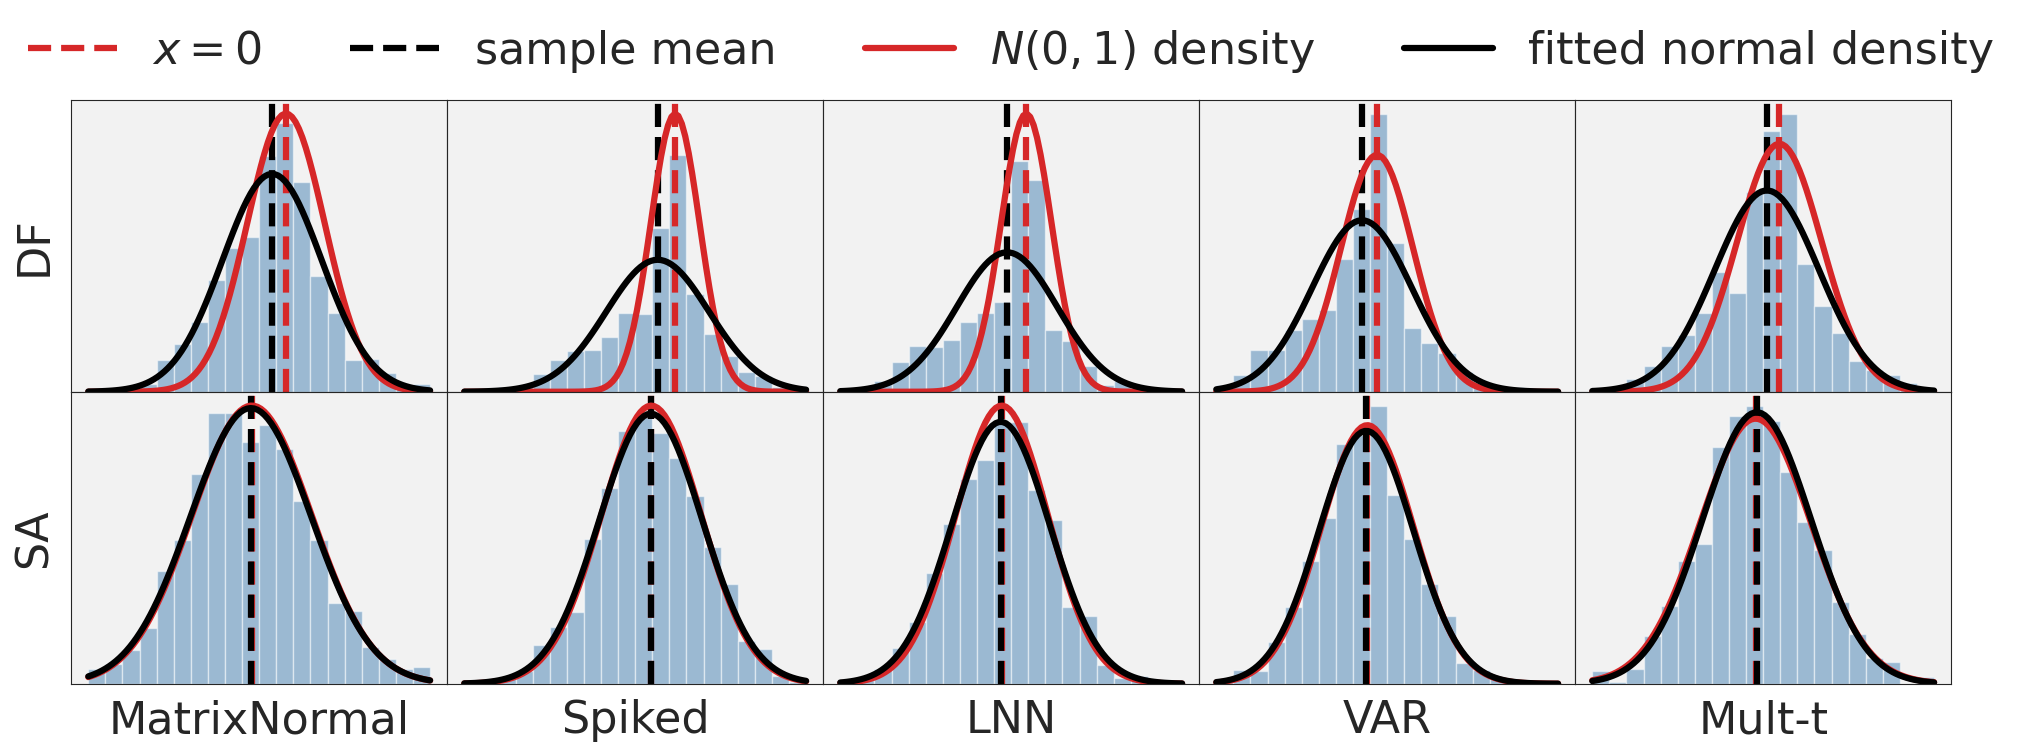

In [21]:
#### Coordinate-wise result with Exchangeable Signal####
np.random.seed(19)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def coordinate_sample(Xarr, M,p,s,mag, axs,j, lam_l1, lam_l2):
    hatarr,oarr,garr,narr, taugarr, tau1arr=[],[],[],[],[],[]
    for i in range(M):
        beta=mix_signal(p,s,mag,balance)
        X=Xarr[i]
        X_v=X
        beta_hat, beta_deb_o, beta_deb_g, taug, tau1, beta=run_va(X_v, X, np.identity(p), beta, 'stdGauss','dense', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_center=is_center)
        oarr.append((beta_deb_o[0]-beta[0])/np.sqrt(tau1))
        garr.append((beta_deb_g[0]-beta[0])/np.sqrt(taug))

    plot_C(garr,0, axs[0,j],'')
    plot_C(oarr,0, axs[1,j],'')


def sample_designs_many(M,n,p):
    norm, colcorr, lnn, ar, spike, multT=[],[],[],[],[],[]
    for i in range(M):
        if i%20==0:
            print(i)

        X_v, X, Sigmap=corrGau_design(n, p, arn=0.5, df=100)
        norm.append(X)

        X_v, X, Sigmap=spike_design(n, p, m=50, mag=10)
        spike.append(X)

        X_v, X, Sigmap=lnn_design(n, p)
        lnn.append(X)

        X_v, X, Sigmap=VAR_design(n, p, 0.4,100)
        ar.append(X)

        X_v, X, Sigmap=multiT_design(n, p,arn=0., arp=0.0,df=3)
        multT.append(X)
    return norm, spike, lnn, ar, multT


M=1000
np.random.seed(256)
n,p,s,balance,lam_l1,lam_l2=100,200,60,0.8,1,0.1
mag=[-20,10]
use_pickle=1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

if (use_pickle==0):
    norm, spike, lnn, ar, multT=sample_designs_many(M,n,p)
    with open("norm.pickle", "wb") as f:
        pickle.dump(norm, f)
    with open("lnn.pickle", "wb") as f:
        pickle.dump(lnn, f)
    with open("ar.pickle", "wb") as f:
        pickle.dump(ar, f)
    with open("spike.pickle", "wb") as f:
        pickle.dump(spike, f)
    with open("multT.pickle", "wb") as f:
        pickle.dump(multT, f)
else:
    with open("norm.pickle", "rb") as f:
        norm = pickle.load(f)
    with open("lnn.pickle", "rb") as f:
        lnn= pickle.load(f)
    with open("ar.pickle", "rb") as f:
        ar = pickle.load(f)
    with open("spike.pickle", "rb") as f:
        spike = pickle.load(f)
    with open("multT.pickle", "rb") as f:
        multT = pickle.load(f)

coordinate_sample(norm, M,p,s,mag, axs,0, lam_l1, lam_l2)
coordinate_sample(spike, M,p,s,mag, axs,1, lam_l1, lam_l2)
coordinate_sample(lnn, M,p,s,mag, axs,2, lam_l1, lam_l2)
coordinate_sample(ar, M,p,s,mag, axs,3, lam_l1, lam_l2)
coordinate_sample(multT, M,p,s,mag, axs,4, lam_l1, lam_l2)


xlab=['MatrixNormal', 'Spiked' ,'LNN', 'VAR', 'Mult-t']
ylab=['DF', 'SA']
for i in range(2):
    for j in range(5):
        axs[i, j].set_xlabel(xlab[j], fontsize=32)
        axs[i, j].set_ylabel(ylab[i], fontsize=32)
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticklabels([])

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig.legend([r'$x=0$','sample mean', r'$N(0,1)$ density','fitted normal density'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.52, 1.02), edgecolor='white', facecolor='white')
filename=filepath+'panel_coor.pdf'
plt.savefig(filename)

The cell below reproduces:

- Fig. S3 from SI Appendix (TPR, FPR, FCP plots for inference results)

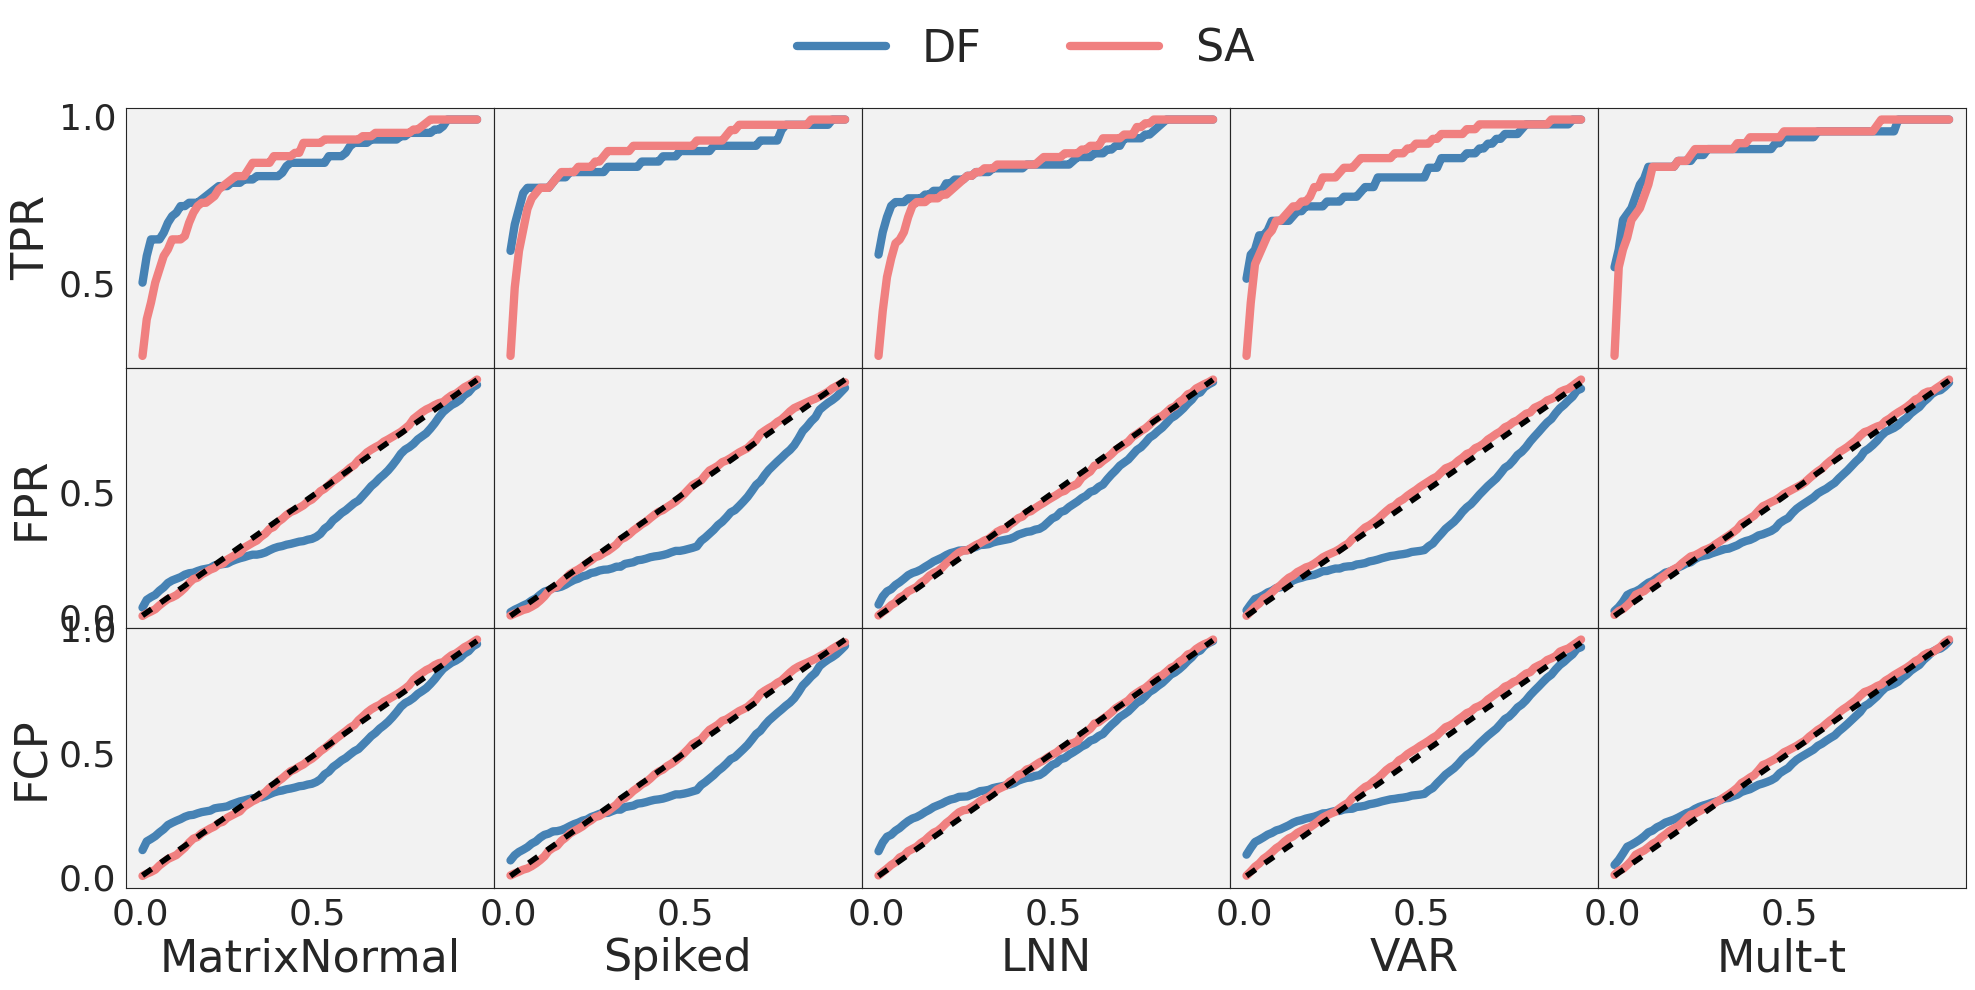

In [24]:
### Inference Results ###
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def run_hyp(alpha_arr,X_v, X, Sigma, beta, designname,signalname, rndigits=3, lam_l1=1, lam_l2=0.5, is_dense=1, mag=100):

    # dimension, sample size
    n,p=X.shape

    # Simulate response
    ep=np.random.normal(0,1,size=n)
    y=X@beta+ep

    # Compute regularized estimator
    clf=ElasticNet(alpha=1/n*(lam_l1+lam_l2),l1_ratio=(lam_l1/(lam_l1+lam_l2)),fit_intercept=False)
    clf.fit(X,y)
    beta_hat=clf.coef_
    #print('sparsity', np.sum(np.abs(beta_hat)>0.0000001))

    # VAMP debiasing
    beta_deb_o, gamma, eta, tau1, tau2, s,v,_=vdbEN(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)

    # Gaussian debiasing
    beta_deb_g, taug=vdbG(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)


    FPR_g, TPR_g,FCP_g, FPR_o, TPR_o, FCP_o=[],[],[],[],[],[]
    P_g=2*(1-normst.cdf(np.abs(beta_deb_g/np.sqrt(taug)), loc=0, scale=1))
    P_o=2*(1-normst.cdf(np.abs(beta_deb_o/np.sqrt(tau1)), loc=0, scale=1))

    for alpha in alpha_arr:

        # CI
        balanceb=0.5
        b,a=normst.ppf(1-alpha*balanceb), normst.ppf(alpha*(1-balanceb))
        CIl_g, CIr_g=beta_deb_g+a*np.sqrt(taug),beta_deb_g+b*np.sqrt(taug)
        CIl_o, CIr_o=beta_deb_o+a*np.sqrt(tau1),beta_deb_o+b*np.sqrt(tau1)
        FCP_g.append(1-np.mean((beta>=CIl_g)&(beta<=CIr_g)))
        FCP_o.append(1-np.mean((beta>=CIl_o)&(beta<=CIr_o)))

        # Hypothesis testing
        T_g=P_g<=alpha
        beta_null=np.abs(beta)<0.00000000001
        beta_nn=np.abs(beta)>=0.00000000001
        FPR_g.append(np.sum(T_g*beta_null)/np.sum(beta_null))
        TPR_g.append(np.sum(T_g*beta_nn)/np.sum(beta_nn))

        T_o=P_o<=alpha
        FPR_o.append(np.sum(T_o*beta_null)/np.sum(beta_null))
        TPR_o.append(np.sum(T_o*beta_nn)/np.sum(beta_nn))

    temp=normst.ppf(1-alpha_arr/2)
    mu0=np.min(np.abs(mag))-0.5
    tpr_lb_g=2-normst.cdf(temp+mu0/np.sqrt(taug))-normst.cdf(temp-mu0/np.sqrt(taug))
    tpr_lb_o=2-normst.cdf(temp+mu0/np.sqrt(tau1))-normst.cdf(temp-mu0/np.sqrt(tau1))

    return TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o



def plot_hyp(axs,i, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o):
    wd=6
    axs[0,i].plot(alpha_arr, TPR_g, linewidth=wd, color='steelblue')
    axs[0,i].plot(alpha_arr, TPR_o, linewidth=wd, color='lightcoral', label='VAMP-DOF')

    axs[1,i].plot(alpha_arr, FPR_g, linewidth=wd, color='steelblue')
    axs[1,i].plot(alpha_arr, FPR_o, linewidth=wd, color='lightcoral')
    axs[1,i].plot(alpha_arr, alpha_arr, linestyle=(0, (2, 2)),color='black', label=r'$\alpha$', linewidth=4)

    axs[2,i].plot(alpha_arr, FCP_g, linewidth=wd, color='steelblue')
    axs[2,i].plot(alpha_arr, FCP_o, linewidth=wd, color='lightcoral')
    axs[2,i].plot(alpha_arr, alpha_arr, linestyle=(0, (2, 2)),color='black', label=r'$\alpha$', linewidth=4)

np.random.seed(19)
n,p,s, ndots, balance,lam_l1,lam_l2=500,1000,100, 80, 0.8, 1, 0.1
mag=[-20,10]
fig, axs = plt.subplots(3, 5, figsize=(20, 10))

X_v, X, Sigmap=corrGau_design(n, p, arn=0.5, df=100)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,0, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=spike_design(n, p, m=50, mag=10)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,1, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=lnn_design(n, p)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,2, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=VAR_design(n, p, 0.4,100)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,3, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=multiT_design(n, p,arn=0., arp=0.0,df=3)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,4, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

xlab=['MatrixNormal', 'Spiked' ,'LNN', 'VAR', 'Mult-t']
ylab=['TPR', 'FPR', 'FCP']
for i in range(3):
    for j in range(5):
        axs[i, j].set_xlabel(xlab[j], fontsize=32)
        axs[i, j].set_ylabel(ylab[i], fontsize=32)
        axs[i, j].tick_params(axis='x',labelsize=26)
        axs[i, j].tick_params(axis='y',labelsize=26)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(left=0.07, right=0.99, bottom=0.12, top=0.9, wspace=0, hspace=0)
fig.legend(['DF','SA'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.52, 1.02), edgecolor='white', facecolor='white')
filename=filepath+'panel_hyp.pdf'
plt.savefig(filename)


The cell below reproduces:

- Fig. 1, Bottom Panel (Presents only the FCP plots)

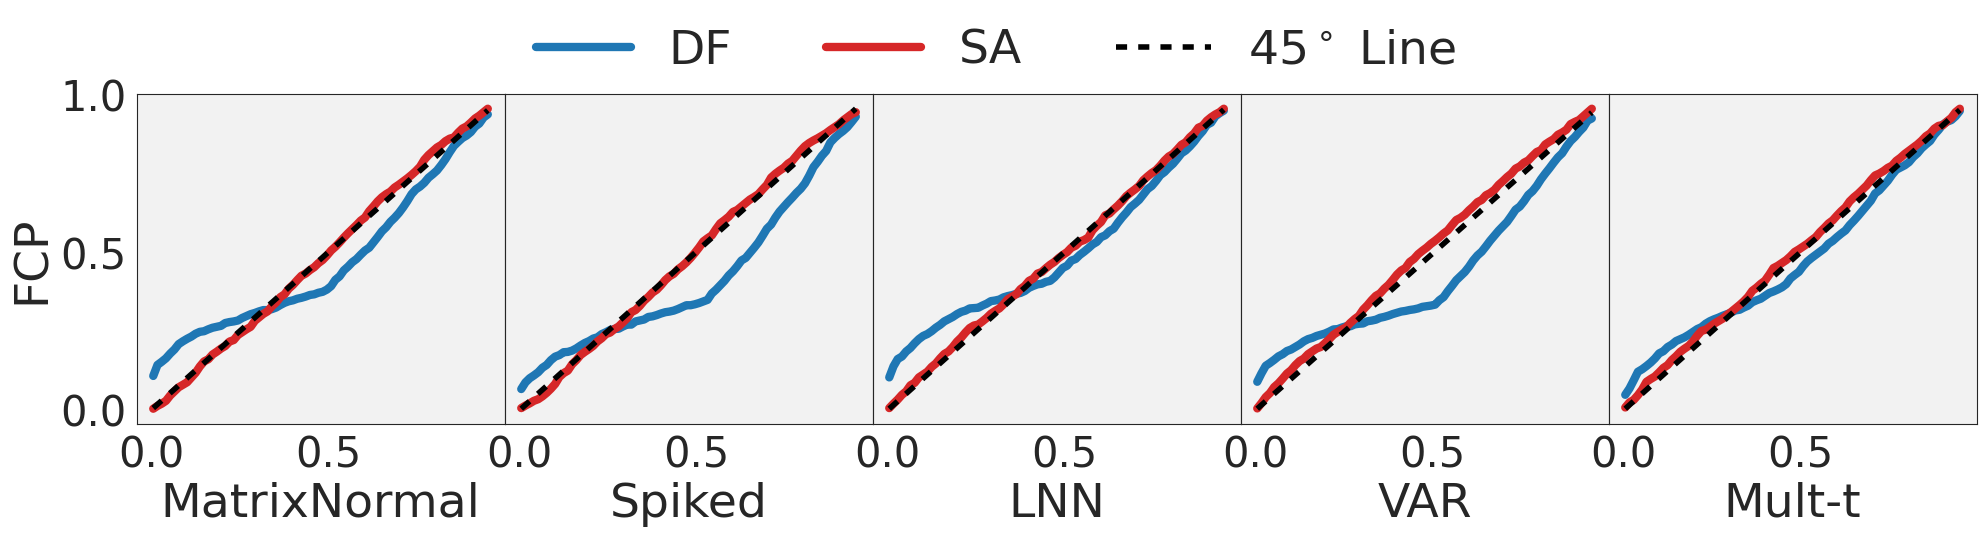

In [26]:
### Same as before but plotting only FCP ###

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Hypothesis Testing ###
def run_hyp(alpha_arr,X_v, X, Sigma, beta, designname,signalname, rndigits=3, lam_l1=1, lam_l2=0.5, is_dense=1, mag=100):

    # dimension, sample size
    n,p=X.shape

    # Simulate response
    ep=np.random.normal(0,1,size=n)
    y=X@beta+ep

    # Compute regularized estimator
    clf=ElasticNet(alpha=1/n*(lam_l1+lam_l2),l1_ratio=(lam_l1/(lam_l1+lam_l2)),fit_intercept=False)
    clf.fit(X,y)
    beta_hat=clf.coef_
    # print('sparsity', np.sum(np.abs(beta_hat)>0.0000001))

    # VAMP debiasing
    beta_deb_o, gamma, eta, tau1, tau2, s,v,_=vdbEN(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)

    # Gaussian debiasing
    beta_deb_g, taug=vdbG(beta_hat, y,X,X_v,Sigmap, lam_l1, lam_l2)


    FPR_g, TPR_g,FCP_g, FPR_o, TPR_o, FCP_o=[],[],[],[],[],[]
    P_g=2*(1-normst.cdf(np.abs(beta_deb_g/np.sqrt(taug)), loc=0, scale=1))
    P_o=2*(1-normst.cdf(np.abs(beta_deb_o/np.sqrt(tau1)), loc=0, scale=1))

    for alpha in alpha_arr:

        # CI
        balanceb=0.5
        b,a=normst.ppf(1-alpha*balanceb), normst.ppf(alpha*(1-balanceb))
        CIl_g, CIr_g=beta_deb_g+a*np.sqrt(taug),beta_deb_g+b*np.sqrt(taug)
        CIl_o, CIr_o=beta_deb_o+a*np.sqrt(tau1),beta_deb_o+b*np.sqrt(tau1)
        FCP_g.append(1-np.mean((beta>=CIl_g)&(beta<=CIr_g)))
        FCP_o.append(1-np.mean((beta>=CIl_o)&(beta<=CIr_o)))

        # Hypothesis testing
        T_g=P_g<=alpha
        beta_null=np.abs(beta)<0.00000000001
        beta_nn=np.abs(beta)>=0.00000000001
        FPR_g.append(np.sum(T_g*beta_null)/np.sum(beta_null))
        TPR_g.append(np.sum(T_g*beta_nn)/np.sum(beta_nn))

        T_o=P_o<=alpha
        FPR_o.append(np.sum(T_o*beta_null)/np.sum(beta_null))
        TPR_o.append(np.sum(T_o*beta_nn)/np.sum(beta_nn))

    temp=normst.ppf(1-alpha_arr/2)
    mu0=np.min(np.abs(mag))-0.5
    tpr_lb_g=2-normst.cdf(temp+mu0/np.sqrt(taug))-normst.cdf(temp-mu0/np.sqrt(taug))
    tpr_lb_o=2-normst.cdf(temp+mu0/np.sqrt(tau1))-normst.cdf(temp-mu0/np.sqrt(tau1))

    return TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o



def plot_hyp(axs,i, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o):
    wd=6
    axs[i].plot(alpha_arr, FCP_g, linewidth=wd, color='tab:blue')
    axs[i].plot(alpha_arr, FCP_o, linewidth=wd, color='tab:red')
    axs[i].plot(alpha_arr, alpha_arr, linestyle=(0, (2, 2)), linewidth=4, color='black')

np.random.seed(19)
n,p,s, ndots, balance,lam_l1,lam_l2=500,1000,100, 80, 0.8, 1, 0.1
mag=[-20,10]
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

X_v, X, Sigmap=corrGau_design(n, p, arn=0.5, df=100)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,0, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=spike_design(n, p, m=50, mag=10)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,1, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=lnn_design(n, p)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,2, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=VAR_design(n, p, 0.4,100)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,3, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

X_v, X, Sigmap=multiT_design(n, p,arn=0., arp=0.0,df=3)
Sigmap=np.identity(p)
beta=sparse_signal(p,s,mag,balance)
alpha_arr=np.linspace(0.005, 0.95, ndots)
TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o=run_hyp(alpha_arr,X_v, X, Sigmap, beta, 'stdGauss','sparse', rndigits=3, lam_l1=lam_l1, lam_l2=lam_l2, is_dense=0, mag=mag)
plot_hyp(axs,4, TPR_g, TPR_o, tpr_lb_g, tpr_lb_o, FPR_g, FPR_o, FCP_g, FCP_o)

xlab=['MatrixNormal', 'Spiked' ,'LNN', 'VAR', 'Mult-t']
ylab=['FCP']
for j in range(5):
    #print(axs.shape, j)
    #axs[i,j].set(xlabel=xlab[j], ylabel=ylab[i], fontsize=16)
    axs[j].set_xlabel(xlab[j], fontsize=34)
    axs[j].set_ylabel(ylab[0], fontsize=34)
    axs[j].tick_params(axis='x',labelsize=30)
    axs[j].tick_params(axis='y',labelsize=30)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(left=0.07, right=0.99, bottom=0.25, top=0.8, wspace=0., hspace=0.)
fig.legend(['DF','SA', r'$45^\circ$ Line'], loc='upper center', ncol=4, prop = { "size": 34 },bbox_to_anchor=(0.5, 0.98), edgecolor="white",facecolor='white')
filename=filepath+'panel_hyp_CIonly.pdf'
plt.savefig(filename)


# PCR-Spectrum-Aware Debiasing

The cells below reproduce figures associated with PCR-Spectrum-Aware Debiasing method discussed in Section 4 of the paper as well as figures deferred to SI Appendix.

In [27]:
### Implement main logic of PCRSA and PCRDF and plotting utilities ###

def run_va2(X, y):

    # dimension, sample size
    n,p=X.shape

    # Compute regularized estimator
    clf=ElasticNet(alpha=1/n*(lam_l1+lam_l2),l1_ratio=(lam_l1/(lam_l1+lam_l2)),fit_intercept=False)
    clf.fit(X,y)
    beta_hat=clf.coef_

    # VAMP debiasing
    beta_deb_o, gamma, eta, tau1, tau2, s,v,sigmasq_hat=vdbEN(beta_hat, y,X,X,np.identity(p), lam_l1, lam_l2)

    # Gaussian debiasing
    beta_deb_g, taug=vdbG(beta_hat, y,X,X,np.identity(p), lam_l1, lam_l2)

    return beta_hat, beta_deb_o, beta_deb_g, taug, tau1,sigmasq_hat


def run_pcr(filt, pcan, X,v,V, y, lam_l1=1, lam_l2=0.5):

    # dimension, sample size
    n,p=X.shape

    # Compute PCA features X
    dsq=v
    nonzero = np.full((dsq.shape[0],), False)
    nonzero=dsq>0.00001

    if pcan<np.sum(nonzero):
        K=pcan
    else:
        K=np.sum(nonzero)

    r=filt
    if r==0:
        V_k=V[:,-K:]
        dsq_k=dsq[-K:]
    else:
        V_k=V[:,-K:-r]
        dsq_k=dsq[-K:-r]
    k=V_k.shape[1]
    DDsqrt_k=np.diag(np.sqrt(dsq_k))
    W_k=X@V_k

    # Put back to original feature by projection (classical PCR approach)
    beta_pca=LA.inv(W_k.T@W_k)@W_k.T@y
    beta_proj=V_k@beta_pca

    # Construct new data
    X=DDsqrt_k@V_k.T
    n,p=X.shape
    Sigmap=np.identity(p)
    Sigmaprt=sqrtm(Sigmap)
    X_v=X@sqrtm(LA.inv(Sigmap))
    y=DDsqrt_k@beta_pca

    # Rescale design
    v, V=LA.eigh(X.T@X)
    rc=np.sqrt(np.mean(v))
    X=X/rc

    # Compute regularized estimator
    clf=ElasticNet(alpha=1/n*(lam_l1+lam_l2),l1_ratio=(lam_l1/(lam_l1+lam_l2)),fit_intercept=False)
    clf.fit(X,y)
    beta_hat=clf.coef_

    # VAMP debiasing
    beta_deb_o, gamma, eta, tau1, tau2, s,v,sigmasq_hat=vdbEN(beta_hat, y,X,X, np.identity(p), lam_l1, lam_l2)

    # Gaussian debiasing
    beta_deb_g, taug=vdbG(beta_hat, y,X,X, np.identity(p), lam_l1, lam_l2)

    # Scale back
    beta_deb_g=beta_deb_g/rc
    beta_deb_o=beta_deb_o/rc

    return beta_deb_o, tau1/(rc**2), beta_deb_g, taug/(rc**2),sigmasq_hat

def run_pcr_pure(pcan, X,v,V, y):

    # dimension, sample size
    n,p=X.shape

    # Compute PCA features X
    dsq=v

    nonzero = np.full((dsq.shape[0],), False)
    nonzero=dsq>0.00001

    if pcan<np.sum(nonzero):
        K=pcan
    else:
        K=np.sum(nonzero)


    V_k=V[:,-K:]
    k=V_k.shape[1]
    W_k=X@V_k

    # Put back to original feature by projection (classical PCR approach)
    beta_pca=LA.inv(W_k.T@W_k)@W_k.T@y
    beta_proj=V_k@beta_pca

    return beta_pca, beta_proj

def simulate_signal_response(X,J1_true,align_strength=25):
    n,p=X.shape

    # Simulate signal
    zeta=mix_signal(p,s,mag,balance)

    if len(J1_true)>0:
        scalJ1=np.sqrt(align_strength*p)*np.random.binomial(1,1,len(J1_true))
        beta_ali=V[:,J1_true]@scalJ1
    else:
        scalJ1,beta_ali=0,0
    beta=zeta+beta_ali

    # Simulate response
    ep=np.random.normal(0,1,size=n)
    y=X@beta+ep

    nustar=[0]*J
    for i in range(1,J):
        if -i not in J1_true:
            nustar[-i]=0
        else:
            nustar[-i]=scalJ1[0]

    return zeta, nustar, beta_ali, beta, ep, y

def proc_CI(alpha_arr, beta_deb, tau, beta):
    FCP=[]
    for alpha in alpha_arr:
        # CI
        balanceb=0.5
        b,a=normst.ppf(1-alpha*balanceb), normst.ppf(alpha*(1-balanceb))
        CIl, CIr=beta_deb+a*np.sqrt(tau),beta_deb+b*np.sqrt(tau)
        FCP.append(1-np.mean((beta>=CIl)&(beta<=CIr)))

    return FCP

def proc_hyp(alpha_arr, beta_deb, tau, beta):
    FPR, TPR=[],[]
    P=2*(1-normst.cdf(np.abs(beta_deb/np.sqrt(tau)), loc=0, scale=1))

    for alpha in alpha_arr:

        # Hypothesis testing
        T=P<=alpha
        beta_null=np.abs(beta)<0.00000000001
        beta_nn=np.abs(beta)>=0.00000000001
        FPR.append(np.sum(T*beta_null)/np.sum(beta_null))
        TPR.append(np.sum(T*beta_nn)/np.sum(beta_nn))

    temp=normst.ppf(1-alpha_arr/2)
    mu0=np.min(np.abs(mag))-0.5
    tpr_lb=2-normst.cdf(temp+mu0/np.sqrt(tau))-normst.cdf(temp-mu0/np.sqrt(tau))

    return TPR, FPR, tpr_lb

def plot_CI(alpha_arr, ax, FCP):
    ax.plot(alpha_arr, FCP, linewidth=6, color='tab:blue')
    ax.plot(alpha_arr, alpha_arr, linestyle=(0, (2, 2)),color='black', linewidth=4)


def output_res(axs, X,v,V,y,J,pcan, lam_l1, lam_l2, col,plttype=1):
    n,p=X.shape

    # Compute estimators
    beta_hat, beta_deb_o, beta_deb_g, taug, tau1,_=run_va2(X,y)
    beta_deb_pcr,tau_pcr, beta_deb_gpcr, tau_gpcr,sigmasq_hat = run_pcr(J, pcan, X, v, V, y, lam_l1=lam_l1, lam_l2=lam_l2)
    beta_pca, beta_proj=run_pcr_pure(J, X,v,V,y)
    omegahat=1/p*LA.norm(beta_deb_pcr)**2-tau_pcr

    # Compute scores and p-values for alignment test
    score=(beta_pca)/np.sqrt(sigmasq_hat/v[-J:]+omegahat)
    P_o=2*(1-normst.cdf(np.abs(score), loc=0, scale=1))
    P_o=P_o[::-1]
    score=score[::-1]
    SCORE[:,col]=score[:NUMv]
    PVAL[:,col]=P_o[:NUMv]
    reject, P_o_corrected=fdrcorrection(P_o, alpha=0.05, method='indep', is_sorted=False)
    PVAL_COR[:,col]=P_o_corrected[:NUMv]


    if plttype==0:

        ## QQ plot
        plot_Q((beta_deb_g-beta)/np.sqrt(taug),axs[0,col])
        plot_Q((beta_deb_o-beta)/np.sqrt(tau1),axs[1,col])
        plot_Q((beta_deb_gpcr+beta_proj-beta)/np.sqrt(tau_gpcr),axs[2,col])
        plot_Q((beta_deb_pcr+beta_proj-beta)/np.sqrt(tau_pcr),axs[3,col])
    elif plttype==1:

        ## Histogram plot
        plot_C((beta_deb_g-beta)/np.sqrt(taug),0, axs[0,col], '')
        plot_C((beta_deb_o-beta)/np.sqrt(tau1),0, axs[1,col], '')
        plot_C((beta_deb_gpcr+beta_proj-beta)/np.sqrt(tau_gpcr),0, axs[2,col], '')
        plot_C((beta_deb_pcr+beta_proj-beta)/np.sqrt(tau_pcr),0, axs[3,col], '')
    elif plttype==2:

        ## CI for \beta^\star
        alpha_arr=np.linspace(0.005, 0.95, 100)
        FCP=proc_CI(alpha_arr, beta_deb_g, taug, beta)
        plot_CI(alpha_arr, axs[0,col], FCP)

        FCP=proc_CI(alpha_arr, beta_deb_o, tau1, beta)
        plot_CI(alpha_arr, axs[1,col], FCP)

        FCP=proc_CI(alpha_arr, beta_deb_gpcr+beta_proj, tau_gpcr, beta)
        plot_CI(alpha_arr, axs[2,col], FCP)

        FCP=proc_CI(alpha_arr, beta_deb_pcr+beta_proj, tau_pcr, beta)
        plot_CI(alpha_arr, axs[3,col], FCP)
    elif plttype==3:

        ## hypothesis testing, CI for \zeta^\star
        alpha_arr=np.linspace(0.005, 0.95, 100)

        TPR, FPR,_=proc_hyp(alpha_arr, beta_deb_pcr, tau_pcr, zeta)
        plot_CI(alpha_arr, axs[0,col], TPR)
        plot_CI(alpha_arr, axs[1,col], FPR)

        FCP=proc_CI(alpha_arr, beta_deb_pcr, tau_pcr, zeta)
        plot_CI(alpha_arr, axs[2,col], FCP)


    return beta_pca, sigmasq_hat, omegahat


The cell below reproduces (in the following order):

- Fig. 2, top-left (empirical distribution of pivotal quantity across 5 simulated designs MatrixNormal-B,...,MultiCauchy)
- Fig S10. QQ plot for Fig. 2, top-left
- Fig. 2, top-right (FCP for true signal across the 5 simulated designs)
- Fig. S.13 (TPR, FPR, FCP for complement component of the signal zeta^star)

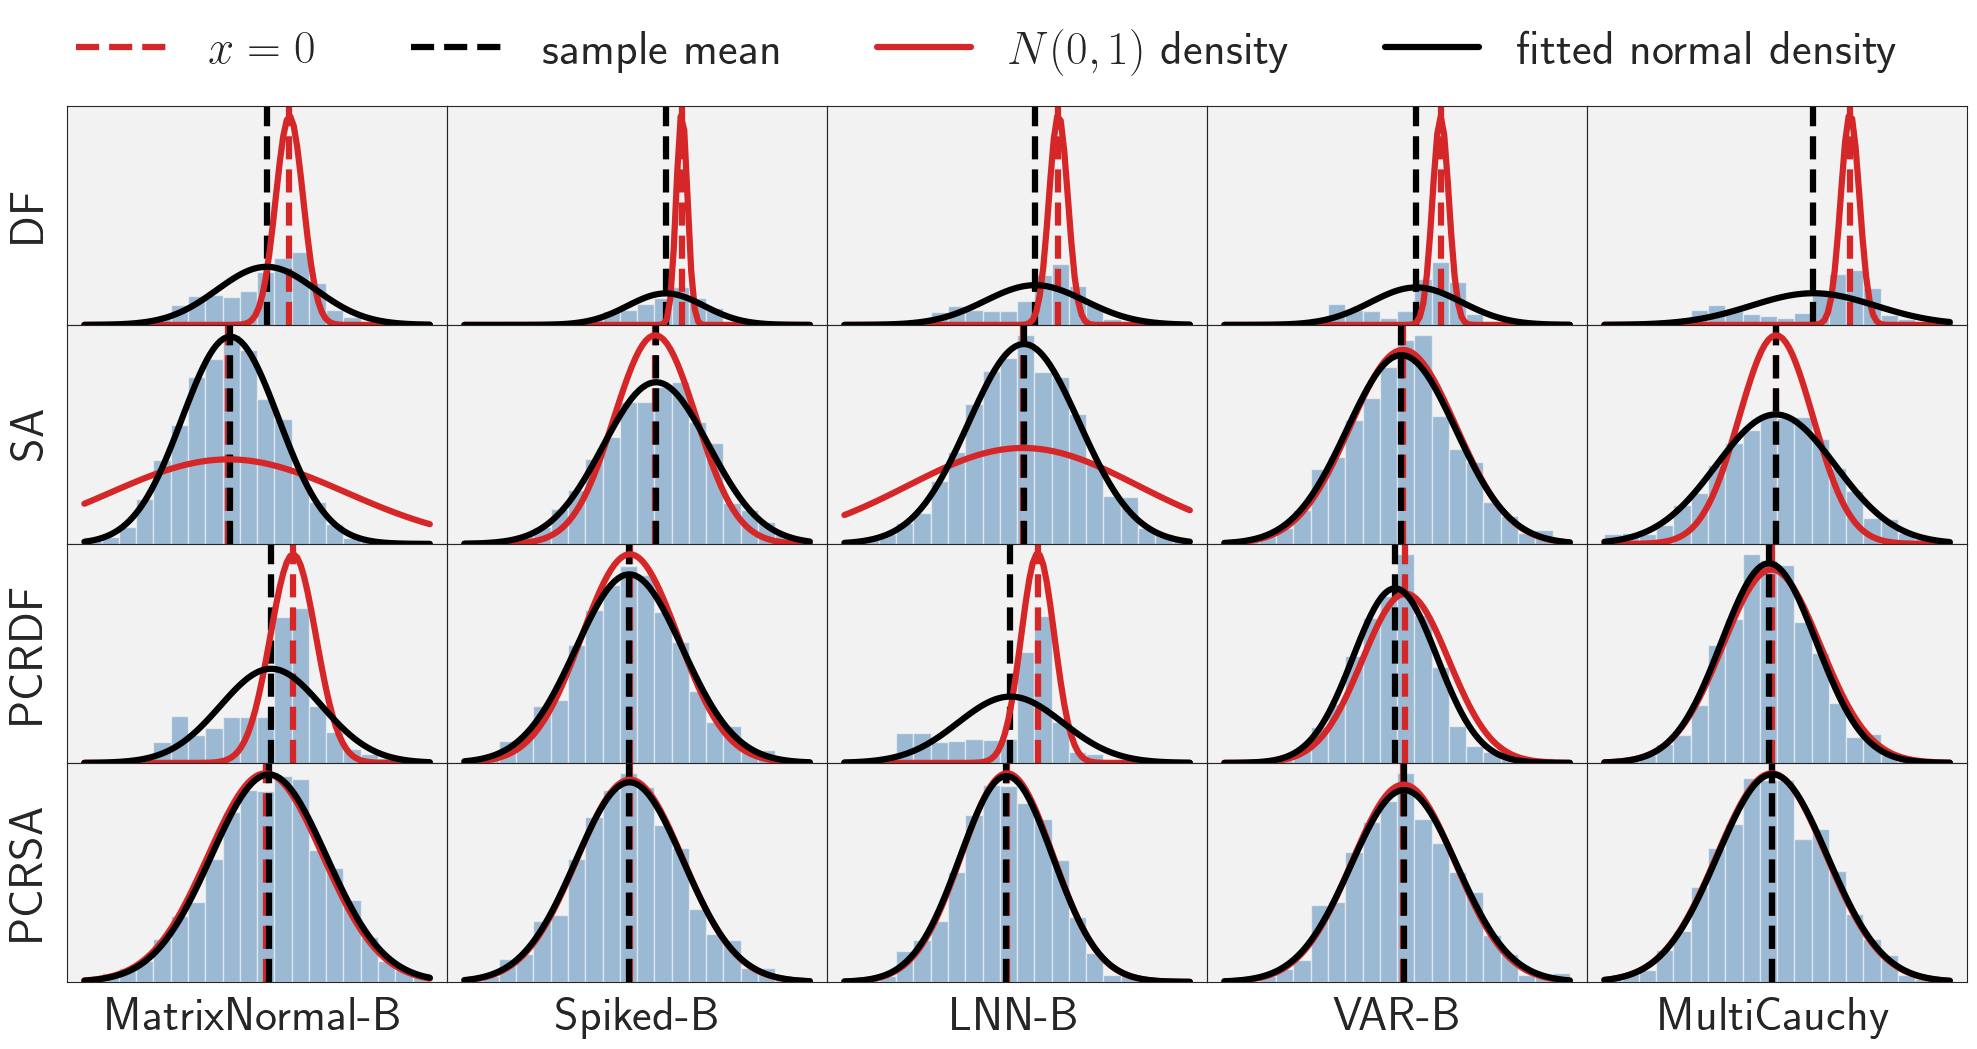

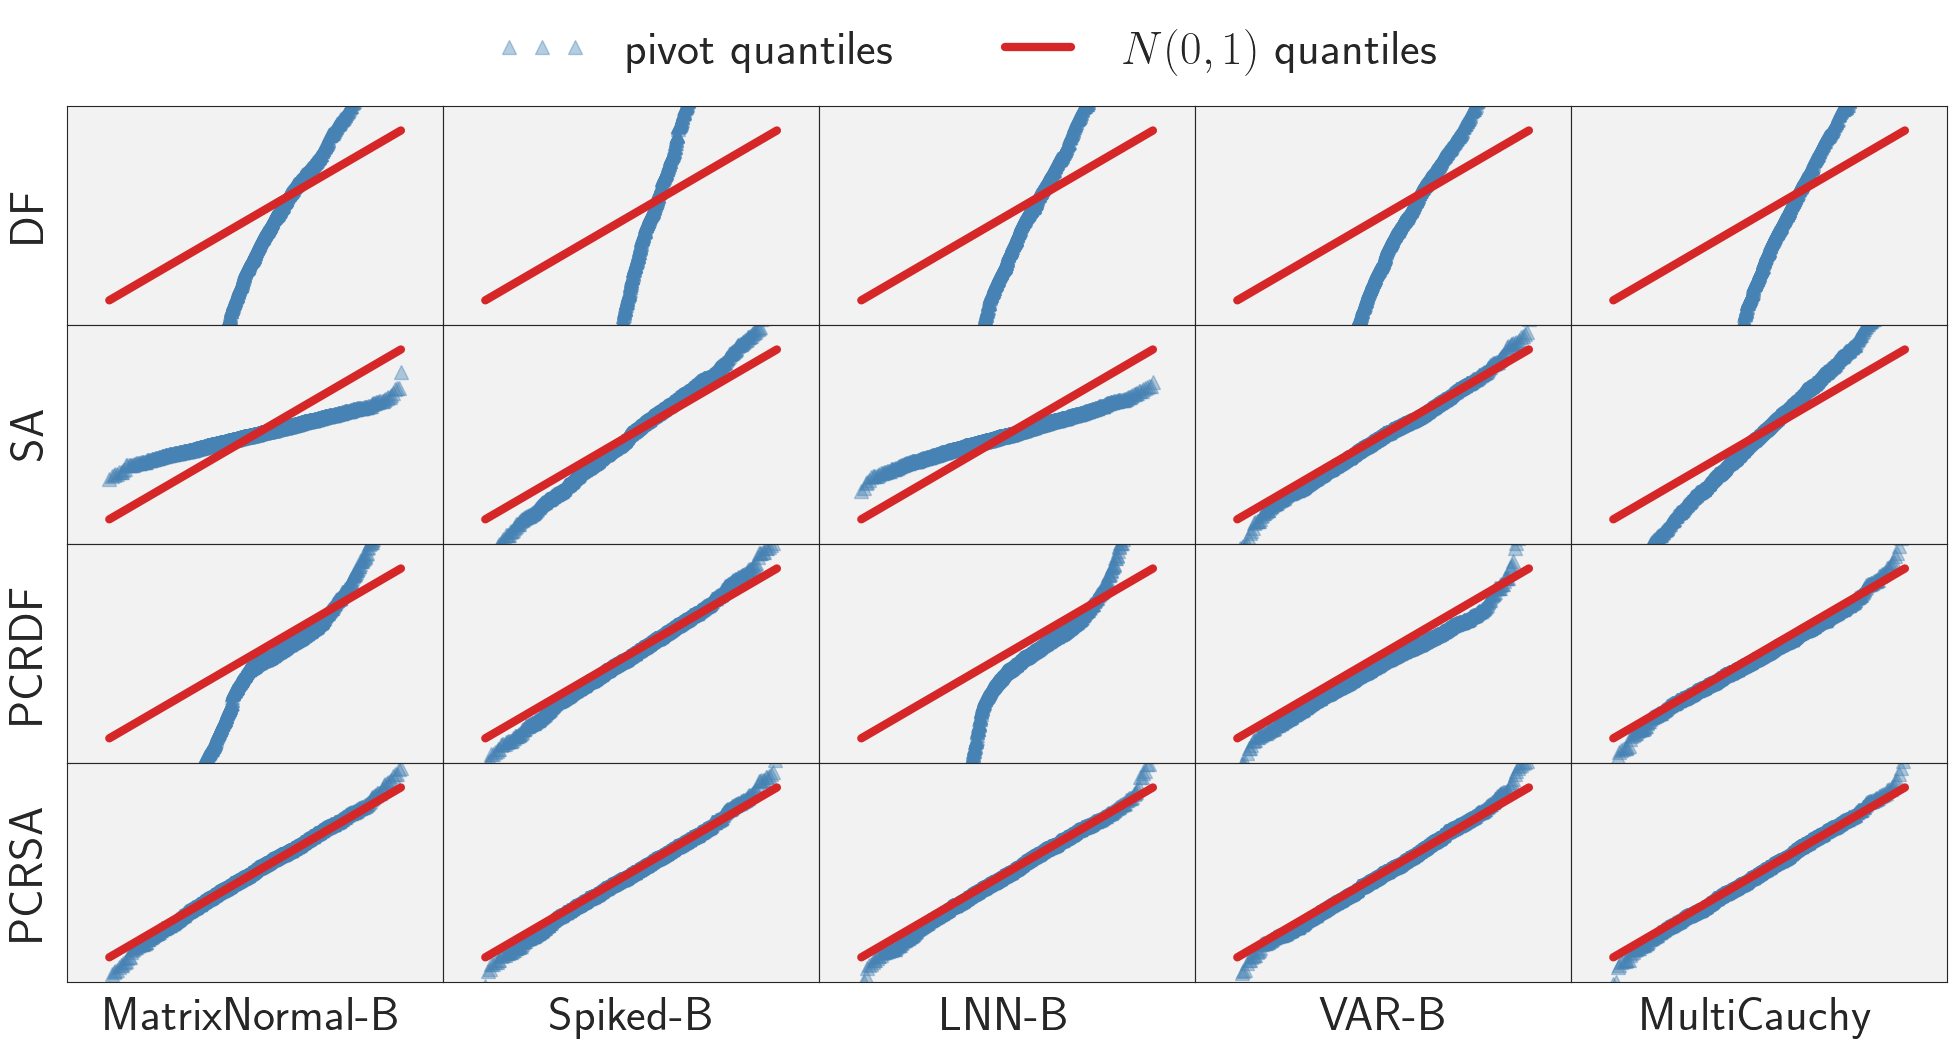

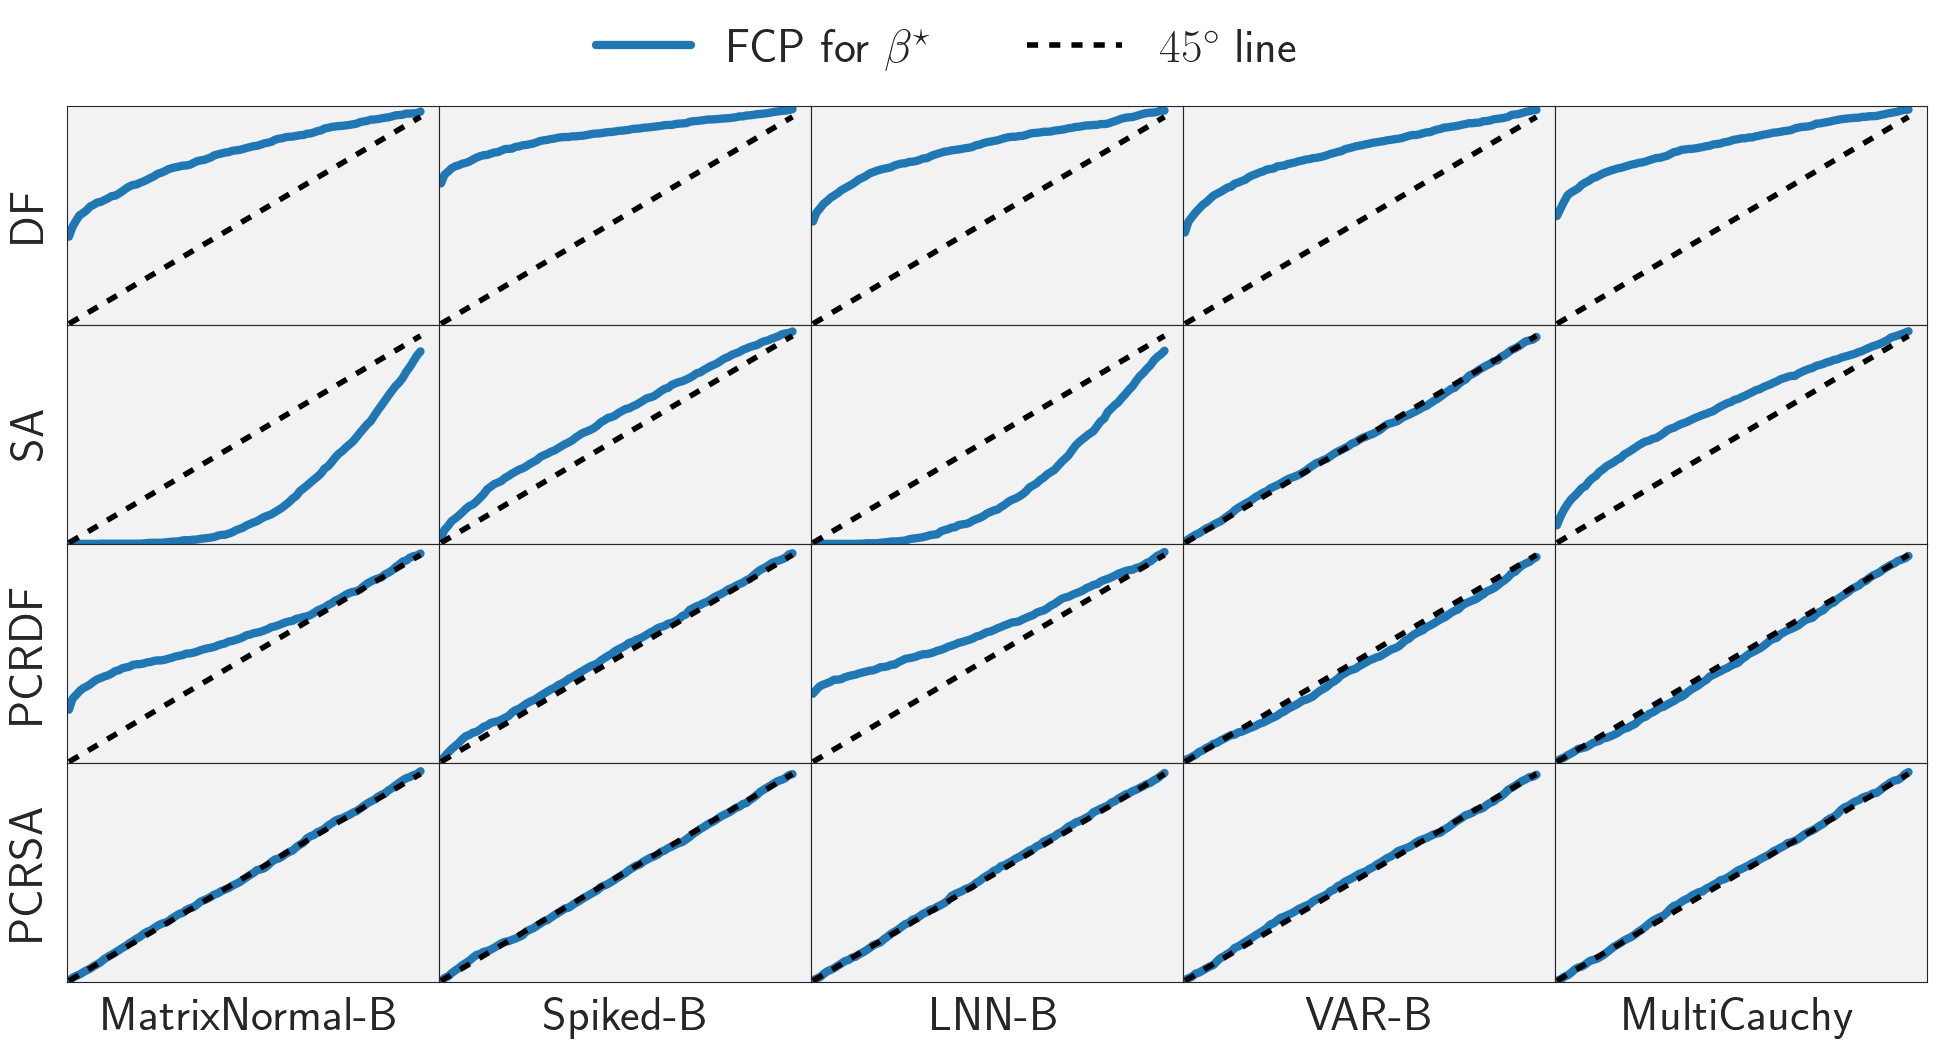

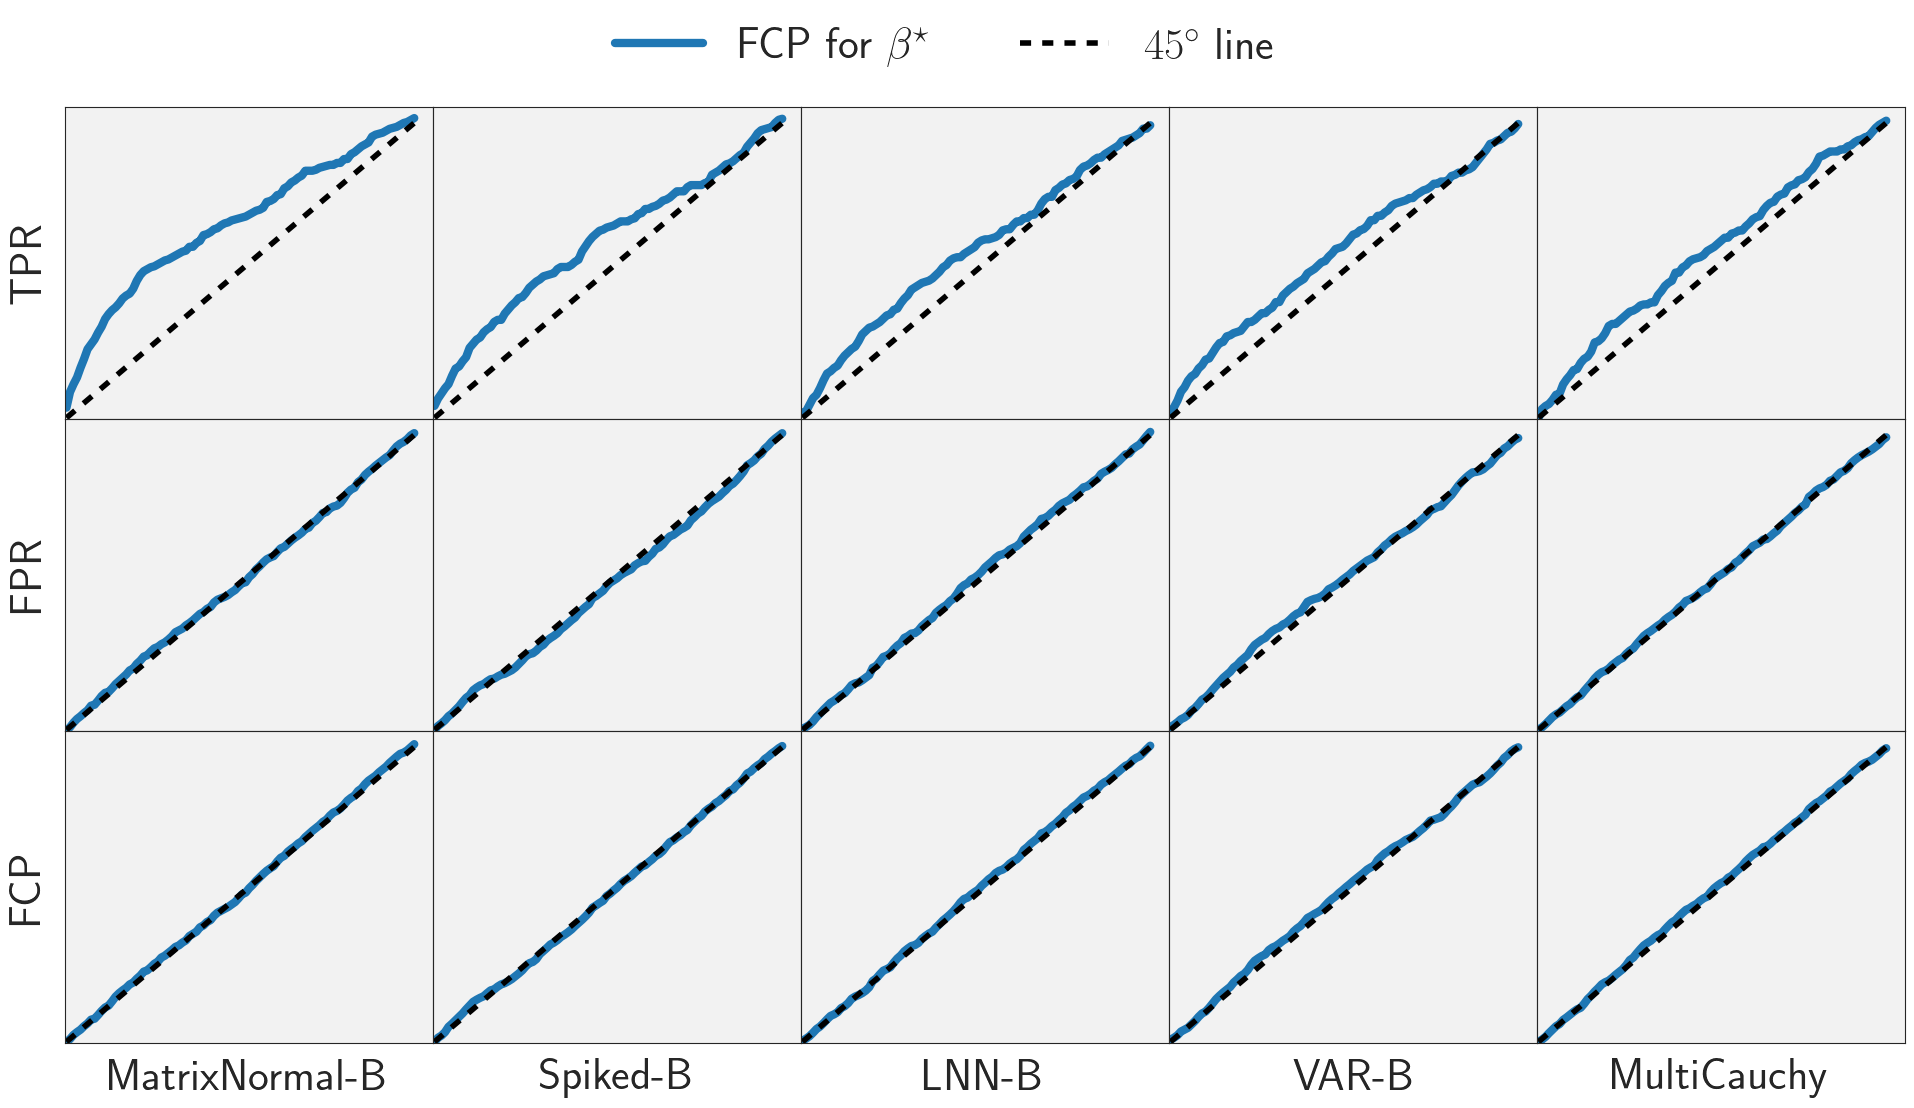

In [63]:
### Simulated Orthogonally invariant Designs ###
np.random.seed(10)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning)

n,p,s,balance,lam_l1,lam_l2=500,1000,300,0.8,1,0.1
J1_true=[-2,-4,-6]
pcan=10**5
mag=[-20,10]

pltn, pltp=4,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig2, axs2 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig3, axs3 = plt.subplots(pltn, pltp, figsize=(20, 12))

pltn4=3
fig4, axs4 = plt.subplots(pltn4, pltp, figsize=(20, 12))

NUMv=10
SCORE=np.zeros((NUMv, pltp))
PVAL=np.zeros((NUMv, pltp))
PVAL_COR=np.zeros((NUMv, pltp))


J=20
_, X, _=corrGau_design(n, p, arn=0.9, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL1=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,3)


J=20
_, X, _=spike_design_arr(n, p, marr=[500, 250, 50], mag2=1)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL2=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,3)


J=20
_, X, _=lnn_design_pw(n, p,15)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL3=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,3)

J=20
_, X, _=VAR_design(n, p, 0.7,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL4=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,3)

J=100
_, X, _=multiT_design(n, p,arn=0., arp=0.0,df=1)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL5=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,3)

xlab=['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
ylab=['DF', 'SA','PCRDF','PCRSA']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=34)
            axs2[i, j].set_xlabel(xlab[j], fontsize=34)
            axs3[i, j].set_xlabel(xlab[j], fontsize=34)

        if j==0:
            axs1[i, j].set_ylabel(ylab[i], fontsize=34)
            axs2[i, j].set_ylabel(ylab[i], fontsize=34)
            axs3[i, j].set_ylabel(ylab[i], fontsize=34)

        axs1[i, j].tick_params(axis='x',labelsize=34)
        axs1[i, j].tick_params(axis='y',labelsize=34)
        axs2[i, j].tick_params(axis='x',labelsize=34)
        axs2[i, j].tick_params(axis='y',labelsize=34)
        axs3[i, j].tick_params(axis='x',labelsize=34)
        axs3[i, j].tick_params(axis='y',labelsize=34)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])
            axs2[i, j].set_xticklabels([])
            axs2[i, j].set_yticklabels([])
            axs3[i, j].set_xticklabels([])
            axs3[i, j].set_yticklabels([])


for ax in axs2.flat:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

for ax in axs3.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


fig1.subplots_adjust(left=0.05, right=1, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig1.legend([r'$x=0$','sample mean', r'$N(0,1)$ density','fitted normal density'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.51, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim.pdf'
fig1.savefig(filename)

fig2.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig2.legend(['pivot quantiles', r'$N(0,1)$ quantiles'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white', numpoints=3,facecolor='white')
filename=filepath+'panel_pcr_sim_qq.pdf'
fig2.savefig(filename)

fig3.subplots_adjust(left=0.06, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0.)
fig3.legend([r'FCP for $\beta^\star$', r'$45^\circ$ line'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim_FCP.pdf'
fig3.savefig(filename)

xlab=['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
ylab=['TPR', 'FPR','FCP']
for i in range(pltn4):
    for j in range(pltp):
        if i==pltn4-1:
            axs4[i, j].set_xlabel(xlab[j], fontsize=32)

        if j==0:
            axs4[i, j].set_ylabel(ylab[i], fontsize=32)

        axs4[i, j].tick_params(axis='x',labelsize=32)
        axs4[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn4):
    for j in range(pltp):
            axs4[i, j].set_xticklabels([])
            axs4[i, j].set_yticklabels([])

for ax in axs4.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

fig4.subplots_adjust(left=0.06, right=0.98, bottom=0.1, top=0.88, wspace=0, hspace=0.)
fig4.legend([r'FCP for $\beta^\star$',r'$45^\circ$ line'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim_zeta_FCP.pdf'
fig4.savefig(filename)


The cell below reproduces:

- Fig. S12 Left Column (alignment test for simulated designs in the "easy detect" experiment)

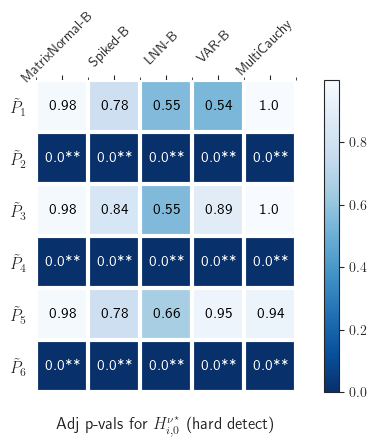

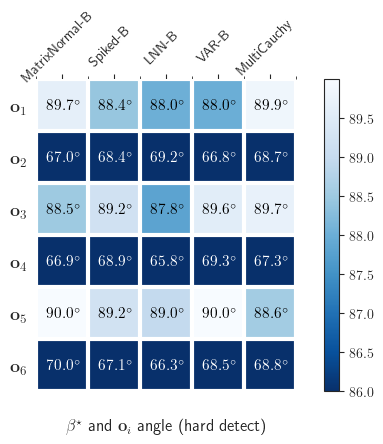

In [64]:
import matplotlib.colors as colors

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

window=6
heat=PVAL_COR[:window,:]

# Assuming column_names is a list of your column names
column_names = ['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
row_names=[r'$\tilde{P}_'+str(num+1)+'$' for num in range(window)]


# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=heat.min(), vmax=heat.max())
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names, fontsize=12)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        color="w"
        if heat[i, j]>0.2:
            color="black"
        if heat[i, j]>0.1:
            val=str(np.round(heat[i, j],2))
        elif heat[i, j]>0.05:
            val=str(np.round(heat[i, j],2))+'*'
        else:
            val=str(np.round(heat[i, j],2))+'**'
        text = ax.text(j, i, val,
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'Adj p-vals for $H_{i,0}^{\nu^\star}$ (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatPvalsSIM_HardDetect.pdf', bbox_inches='tight')

plt.show()

# Assuming trueAL1, trueAL2, trueAL3, trueAL4, and trueAL5 are defined somewhere above
plt.rcParams['text.usetex'] = True
window = 6
heat = np.vstack((trueAL1[-window:], trueAL2[-window:], trueAL3[-window:], trueAL4[-window:], trueAL5[-window:]))
heat = (heat.T)[::-1,:]
heat = np.rad2deg(np.arccos(heat))

# Assuming column_names is a list of your column names
column_names = ['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
row_names=[r'$\mathbf{o}_'+str(num+1)+'$' for num in range(window)]

#[r'$\nu^\star$','v1','v1','v1','v1']

# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=86, vmax=heat.max())
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)

# Adding colorbar
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names,fontsize=13)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if heat[i, j]>87.2:
            color="black"
        else:
            color="w"
        text = ax.text(j, i, r'$'+str(np.round(heat[i, j],1))+'^\circ$',
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'$\beta^\star$ and $\mathbf{o}_i$ angle (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatTrueAglSIM_HardDetect.pdf', bbox_inches='tight')


plt.show()

The two cells below reproduces:

- Fig. S12 Right Column (alignment test for simulated designs in the "hard detect" experiment)

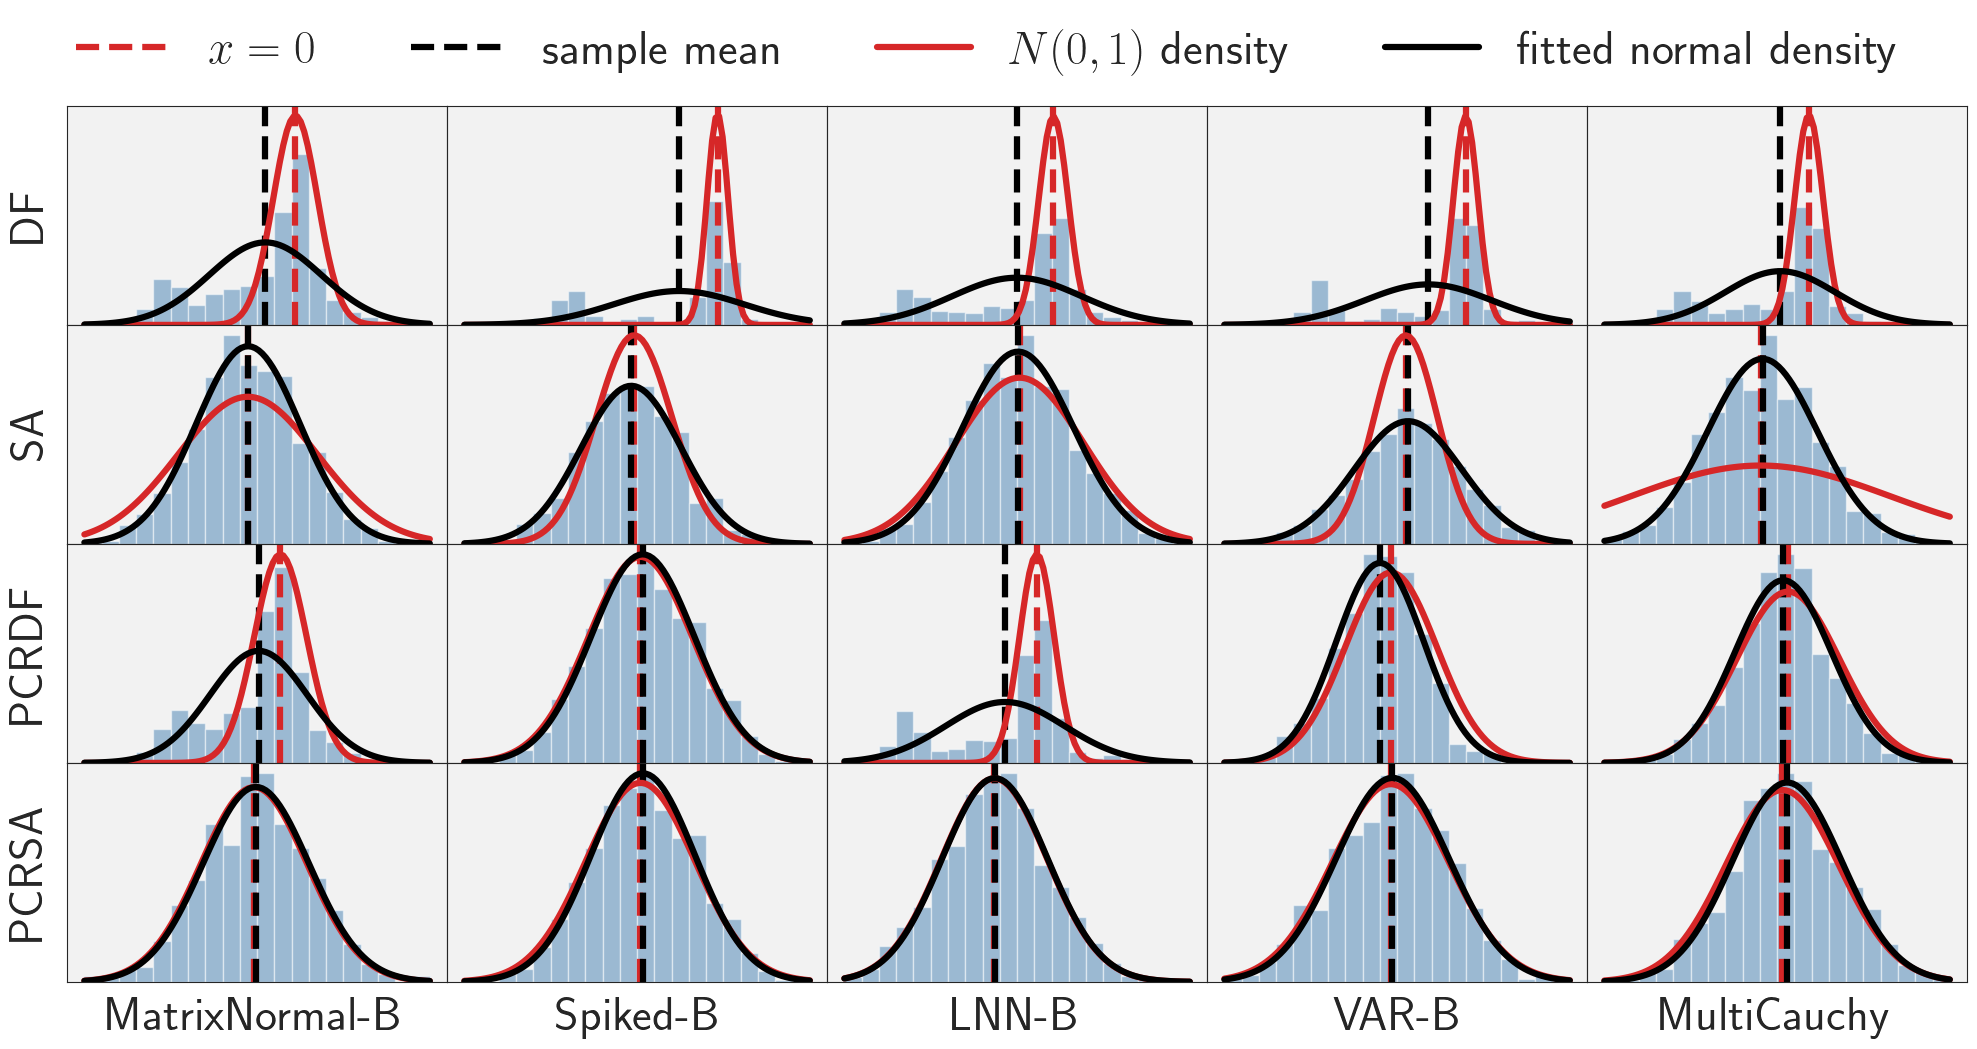

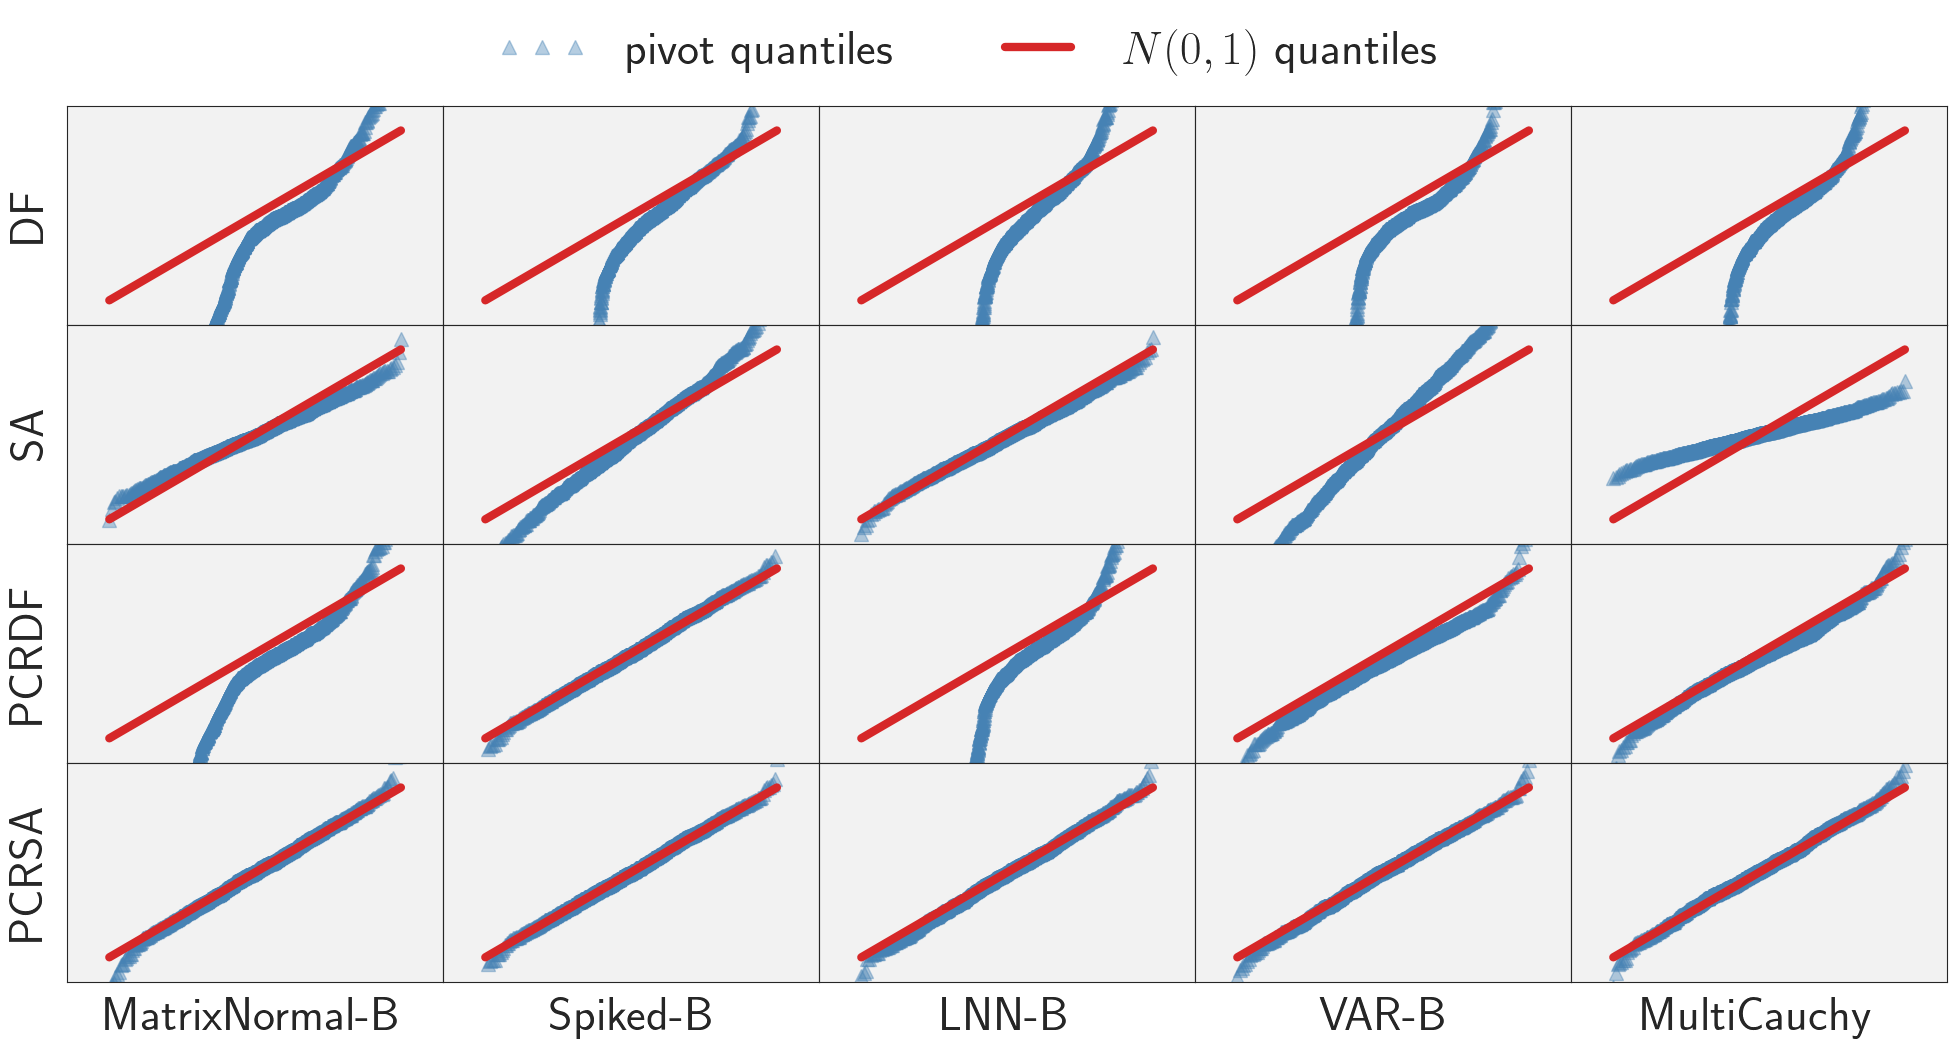

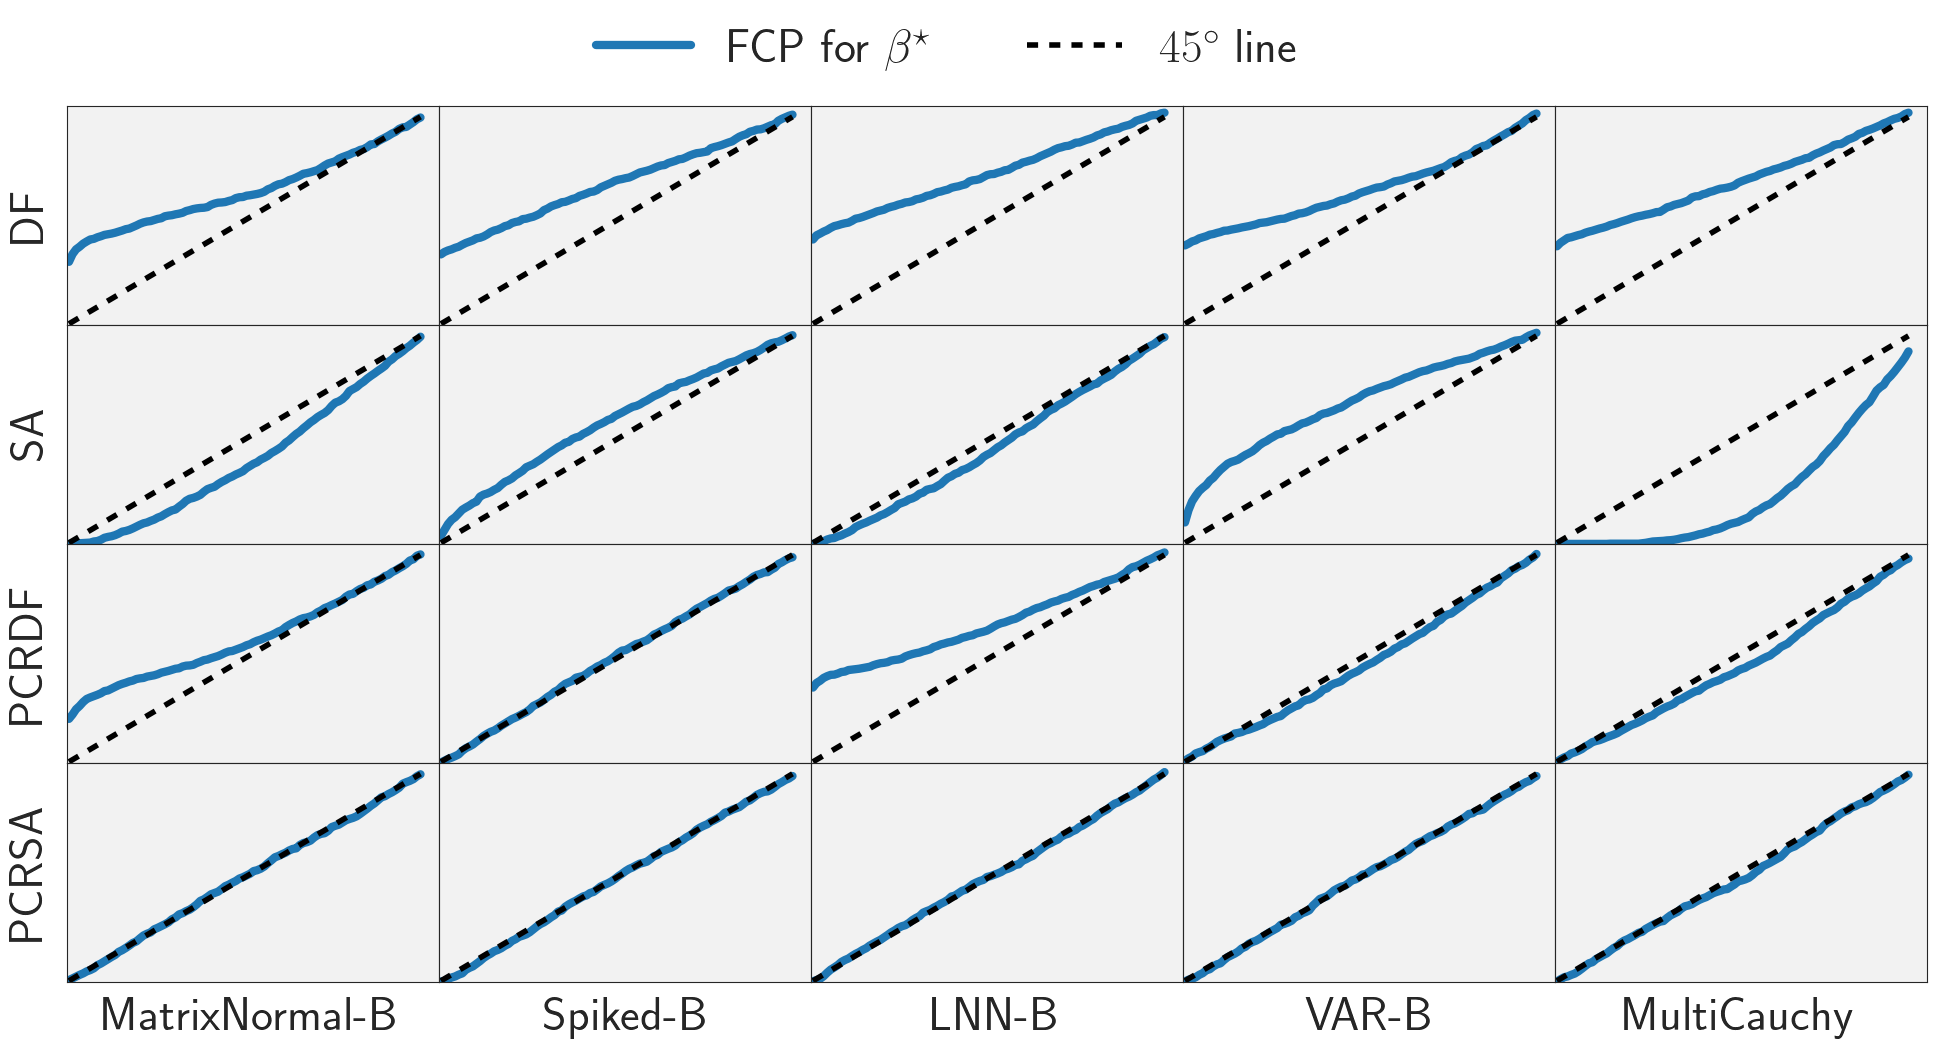

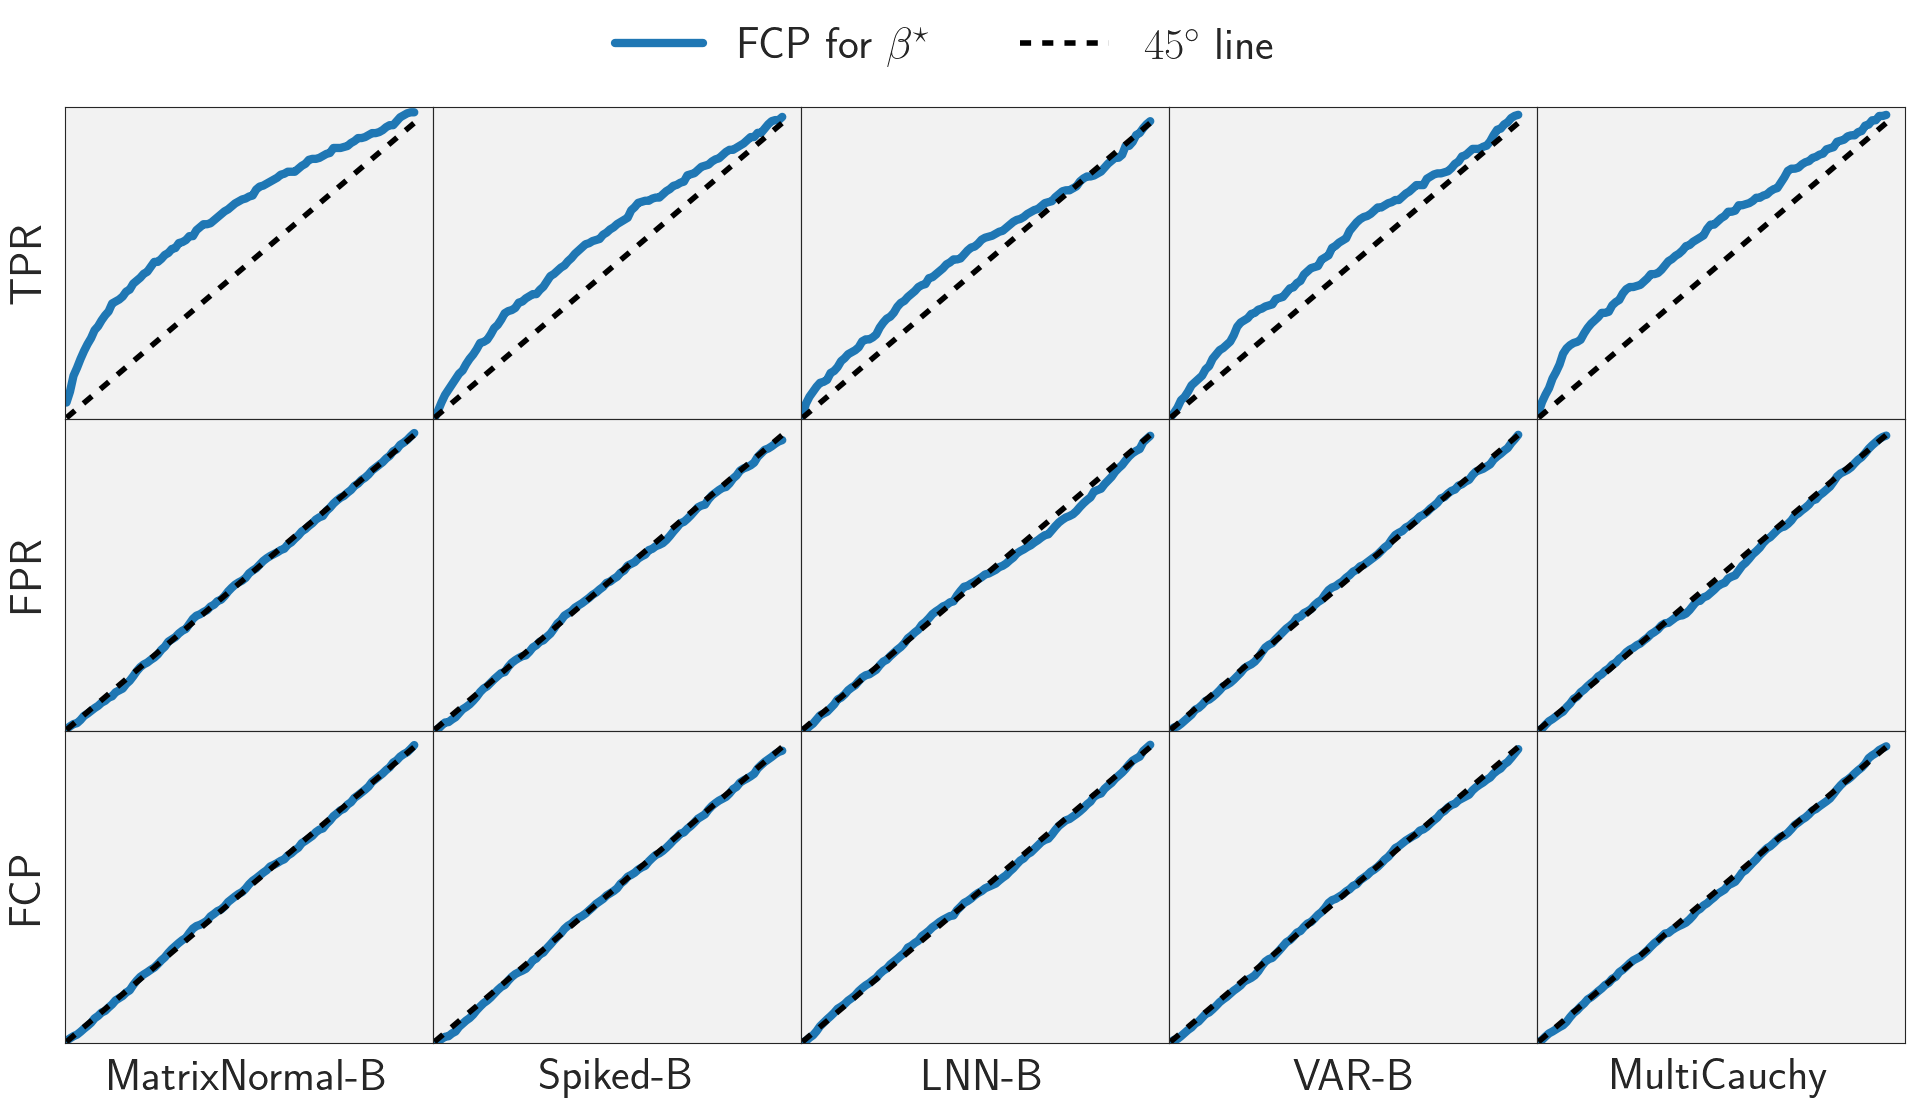

In [61]:
### Simulated Orthogonally invariant Designs: align_strength=1 (Hard Detection) ###
np.random.seed(1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

n,p,s,balance,lam_l1,lam_l2=500,1000,300,0.8,1,0.1
J1_true=[-2,-4,-6]
pcan=10**5
mag=[-20,10]

align_strength=1

pltn, pltp=4,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig2, axs2 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig3, axs3 = plt.subplots(pltn, pltp, figsize=(20, 12))

pltn4=3
fig4, axs4 = plt.subplots(pltn4, pltp, figsize=(20, 12))

J=20
_, X, _=corrGau_design(n, p, arn=0.9, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true, align_strength)
trueAL1=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,3)


J=20
_, X, _=spike_design_arr(n, p, marr=[500, 250, 50], mag2=1)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL2=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,3)


J=20
_, X, _=lnn_design_pw(n, p,15)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL3=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,3)


J=20
_, X, _=VAR_design(n, p, 0.7,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL4=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,3)

J=100
_, X, _=multiT_design(n, p,arn=0., arp=0.0,df=1)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL5=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)
output_res(axs4, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,3)

xlab=['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
ylab=['DF', 'SA','PCRDF','PCRSA']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=34)
            axs2[i, j].set_xlabel(xlab[j], fontsize=34)
            axs3[i, j].set_xlabel(xlab[j], fontsize=34)

        if j==0:
            axs1[i, j].set_ylabel(ylab[i], fontsize=34)
            axs2[i, j].set_ylabel(ylab[i], fontsize=34)
            axs3[i, j].set_ylabel(ylab[i], fontsize=34)

        axs1[i, j].tick_params(axis='x',labelsize=34)
        axs1[i, j].tick_params(axis='y',labelsize=34)
        axs2[i, j].tick_params(axis='x',labelsize=34)
        axs2[i, j].tick_params(axis='y',labelsize=34)
        axs3[i, j].tick_params(axis='x',labelsize=34)
        axs3[i, j].tick_params(axis='y',labelsize=34)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])
            axs2[i, j].set_xticklabels([])
            axs2[i, j].set_yticklabels([])
            axs3[i, j].set_xticklabels([])
            axs3[i, j].set_yticklabels([])


for ax in axs2.flat:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

for ax in axs3.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

fig1.subplots_adjust(left=0.05, right=1, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig1.legend([r'$x=0$','sample mean', r'$N(0,1)$ density','fitted normal density'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.51, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim.pdf'
fig1.savefig(filename)

fig2.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig2.legend(['pivot quantiles', r'$N(0,1)$ quantiles'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white', numpoints=3,facecolor='white')
filename=filepath+'panel_pcr_sim_qq.pdf'
fig2.savefig(filename)

fig3.subplots_adjust(left=0.06, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0.)
fig3.legend([r'FCP for $\beta^\star$', r'$45^\circ$ line'], loc='upper center', ncol=4, prop = { "size": 34 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim_FCP.pdf'
fig3.savefig(filename)

xlab=['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
ylab=['TPR', 'FPR','FCP']
for i in range(pltn4):
    for j in range(pltp):
        if i==pltn4-1:
            axs4[i, j].set_xlabel(xlab[j], fontsize=32)

        if j==0:
            axs4[i, j].set_ylabel(ylab[i], fontsize=32)

        axs4[i, j].tick_params(axis='x',labelsize=32)
        axs4[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn4):
    for j in range(pltp):
            axs4[i, j].set_xticklabels([])
            axs4[i, j].set_yticklabels([])

for ax in axs4.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

fig4.subplots_adjust(left=0.06, right=0.98, bottom=0.1, top=0.88, wspace=0, hspace=0.)
fig4.legend([r'FCP for $\beta^\star$',r'$45^\circ$ line'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white',facecolor='white')
filename=filepath+'panel_pcr_sim_zeta_FCP.pdf'
fig4.savefig(filename)

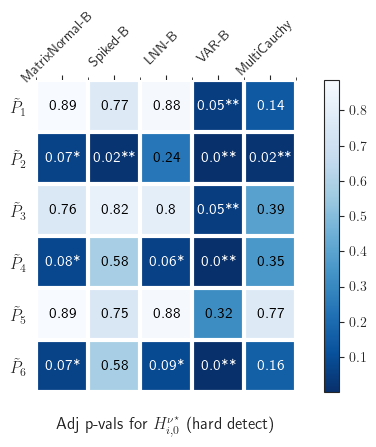

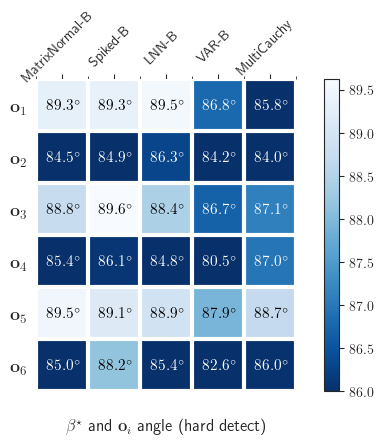

In [62]:
import matplotlib.colors as colors

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

window=6
heat=PVAL_COR[:window,:]

# Assuming column_names is a list of your column names
column_names = ['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
row_names=[r'$\tilde{P}_'+str(num+1)+'$' for num in range(window)]


# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=heat.min(), vmax=heat.max())
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names, fontsize=12)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        color="w"
        if heat[i, j]>0.2:
            color="black"
        if heat[i, j]>0.1:
            val=str(np.round(heat[i, j],2))
        elif heat[i, j]>0.05:
            val=str(np.round(heat[i, j],2))+'*'
        else:
            val=str(np.round(heat[i, j],2))+'**'
        text = ax.text(j, i, val,
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'Adj p-vals for $H_{i,0}^{\nu^\star}$ (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatPvalsSIM_HardDetect.pdf', bbox_inches='tight')

plt.show()

# Assuming trueAL1, trueAL2, trueAL3, trueAL4, and trueAL5 are defined somewhere above
plt.rcParams['text.usetex'] = True
window = 6
heat = np.vstack((trueAL1[-window:], trueAL2[-window:], trueAL3[-window:], trueAL4[-window:], trueAL5[-window:]))
heat = (heat.T)[::-1,:]
heat = np.rad2deg(np.arccos(heat))

# Assuming column_names is a list of your column names
column_names = ['MatrixNormal-B', 'Spiked-B' ,'LNN-B', 'VAR-B', 'MultiCauchy']
row_names=[r'$\mathbf{o}_'+str(num+1)+'$' for num in range(window)]

#[r'$\nu^\star$','v1','v1','v1','v1']

# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=86, vmax=heat.max())
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)

# Adding colorbar
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names,fontsize=13)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if heat[i, j]>87.2:
            color="black"
        else:
            color="w"
        text = ax.text(j, i, r'$'+str(np.round(heat[i, j],1))+'^\circ$',
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'$\beta^\star$ and $\mathbf{o}_i$ angle (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatTrueAglSIM_HardDetect.pdf', bbox_inches='tight')


plt.show()

The cell below reproduces (in the following order):

- Fig. 2, bottom-left (empirical distribution of pivotal quantity across 5 real designs Speech,...,Crime)
- Fig. S11 (QQ plot for Fig. 2, bottom-left)
- Fig. 2, bottom-right (FCP for true signal across the 5 real designs)

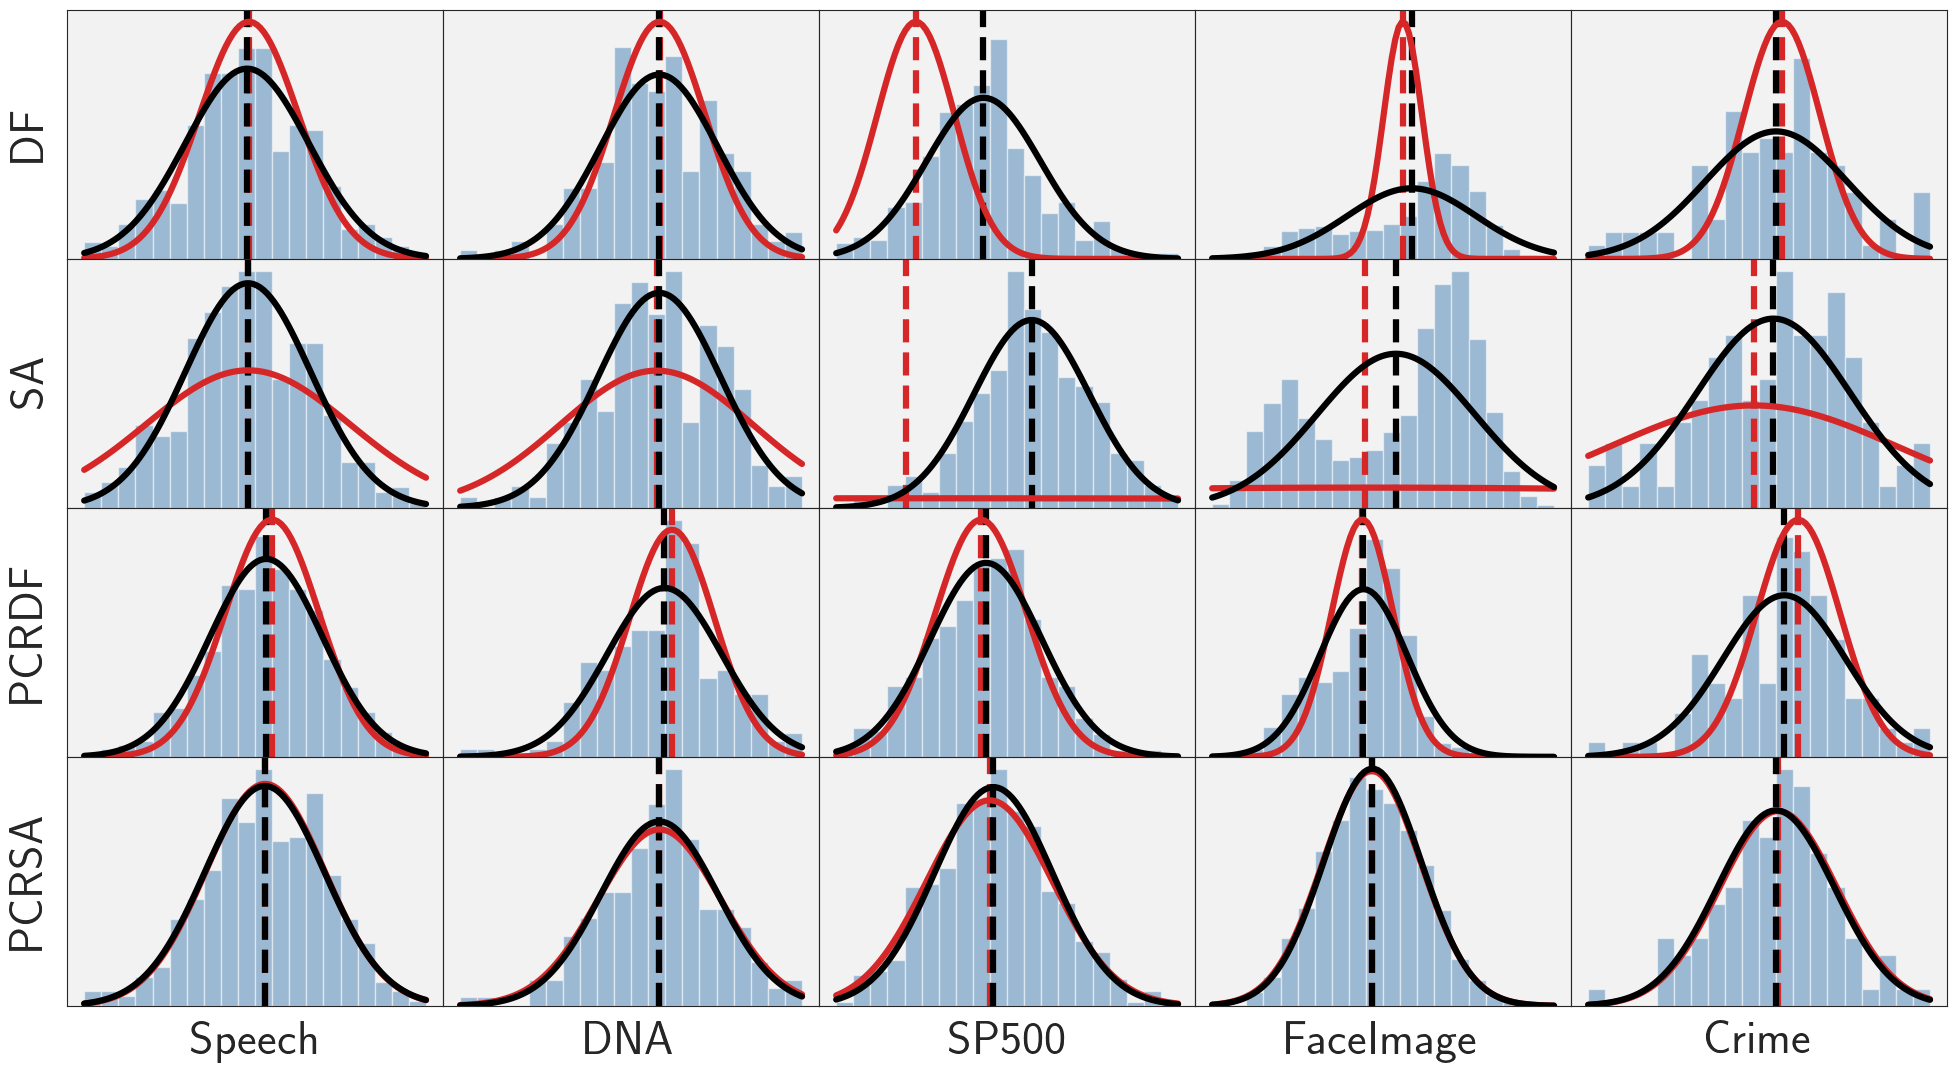

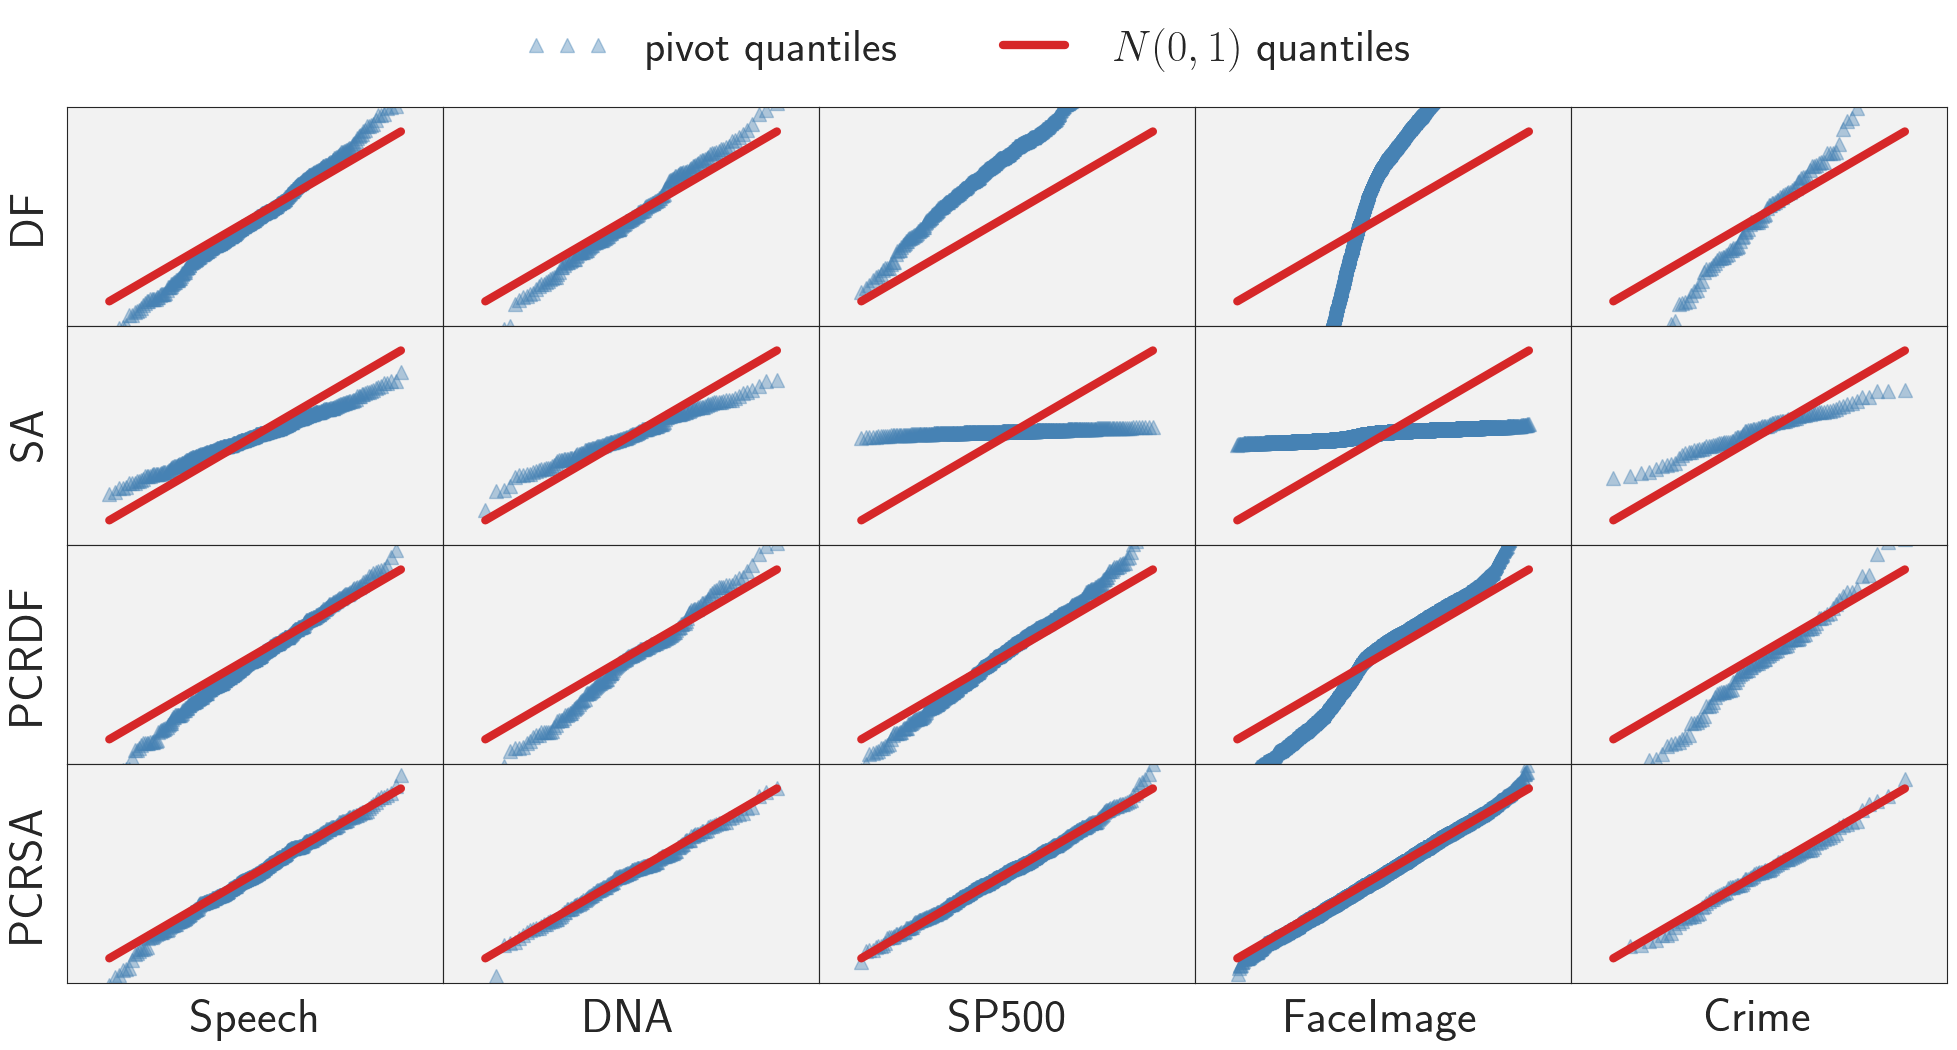

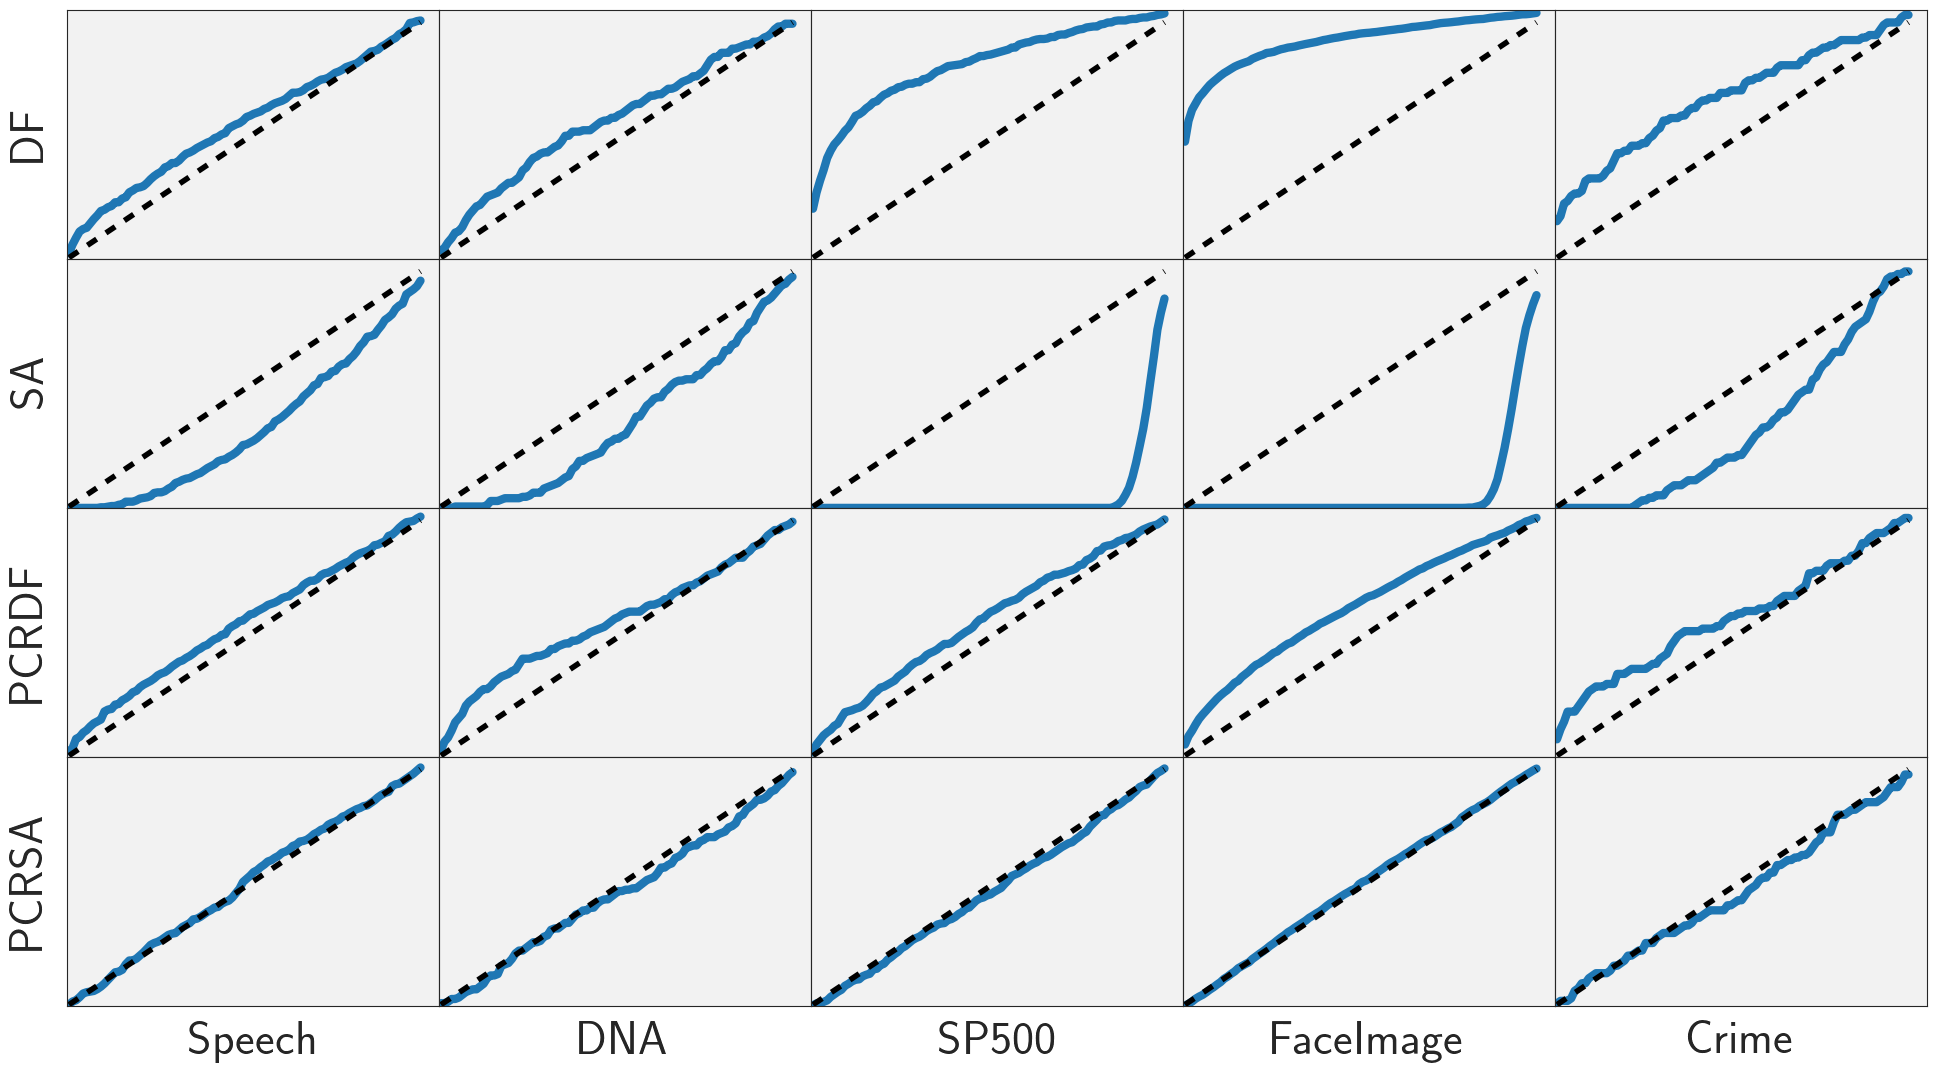

In [70]:
### Real designs ###
np.random.seed(38)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

balance,lam_l1,lam_l2=0.8,1,0.1
sparse=0.3
J1_true=[-2,-4,-6]
pcan=10**5
mag=[-20,10]
pltn, pltp=4,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig2, axs2 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig3, axs3 = plt.subplots(pltn, pltp, figsize=(20, 12))

NUMv=10
SCORE=np.zeros((NUMv, pltp))
PVAL=np.zeros((NUMv, pltp))
PVAL_COR=np.zeros((NUMv, pltp))


pcan=10**5

_, X, _=speech_design(40910,200)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
v1, V1=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL1=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)

J=10
_, X, _=dna_design(40670,100)
v,V=LA.eigh(X.T@X)
v2, V2=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL2=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)

J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
v,V=LA.eigh(X.T@X)
v3, V3=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL3=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)


J=100
_, X, _=face_design()
v,V=LA.eigh(X.T@X)
v4, V4=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL4=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)

J=10
_, X, _=crime_design(50)
v,V=LA.eigh(X.T@X)
v5, V5=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
trueAL5=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
ylab=['DF', 'SA','PCRDF','PCRSA']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=34)
            axs2[i, j].set_xlabel(xlab[j], fontsize=34)
            axs3[i, j].set_xlabel(xlab[j], fontsize=34)

        if j==0:
            axs1[i, j].set_ylabel(ylab[i], fontsize=34)
            axs2[i, j].set_ylabel(ylab[i], fontsize=34)
            axs3[i, j].set_ylabel(ylab[i], fontsize=34)

        axs1[i, j].tick_params(axis='x',labelsize=34)
        axs1[i, j].tick_params(axis='y',labelsize=34)
        axs2[i, j].tick_params(axis='x',labelsize=34)
        axs2[i, j].tick_params(axis='y',labelsize=34)
        axs3[i, j].tick_params(axis='x',labelsize=34)
        axs3[i, j].tick_params(axis='y',labelsize=34)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])
            axs2[i, j].set_xticklabels([])
            axs2[i, j].set_yticklabels([])
            axs3[i, j].set_xticklabels([])
            axs3[i, j].set_yticklabels([])


for ax in axs2.flat:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

for ax in axs3.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.98, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real.pdf'
fig1.savefig(filename)

fig2.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig2.legend(['pivot quantiles', r'$N(0,1)$ quantiles'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white', numpoints=3,facecolor='white')
filename=filepath+'panel_pcr_real_qq.pdf'
fig2.savefig(filename)

fig3.subplots_adjust(left=0.06, right=0.99, bottom=0.15, top=0.98, wspace=0, hspace=0.)
filename=filepath+'panel_pcr_real_FCP.pdf'
fig3.savefig(filename)

The cell below reproduces:
- Fig. 3, left-column (alignment test for 5 real-data designs, easy detect experiment)

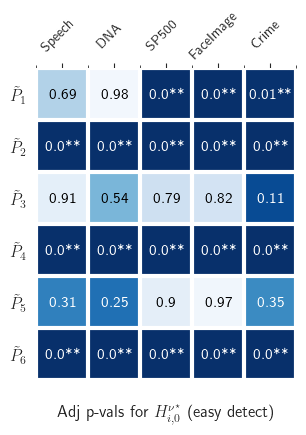

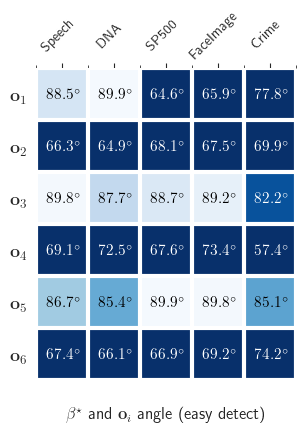

In [71]:
import matplotlib.colors as colors

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

window=6
heat=PVAL_COR[:window,:]

# Assuming column_names is a list of your column names
column_names = ['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']  # Example column names
row_names=[r'$\tilde{P}_'+str(num+1)+'$' for num in range(window)]


# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1)
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)


# Adding colorbar
#cb=fig.colorbar(cax)
#tick_values = np.linspace(0, 0.06, 6)
#cb.set_ticks(tick_values)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names, fontsize=12)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        color="w"
        if heat[i, j]>0.4:
            color="black"
        if heat[i, j]>0.1:
            val=str(np.round(heat[i, j],2))
        elif heat[i, j]>0.05:
            val=str(np.round(heat[i, j],2))+'*'
        else:
            val=str(np.round(heat[i, j],2))+'**'
        text = ax.text(j, i, val,
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'Adj p-vals for $H_{i,0}^{\nu^\star}$ (easy detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatPvals.pdf', bbox_inches='tight')

plt.show()

# Assuming trueAL1, trueAL2, trueAL3, trueAL4, and trueAL5 are defined somewhere above
plt.rcParams['text.usetex'] = True
window = 6
heat = np.vstack((trueAL1[-window:], trueAL2[-window:], trueAL3[-window:], trueAL4[-window:], trueAL5[-window:]))
heat = (heat.T)[::-1,:]
heat = np.rad2deg(np.arccos(heat))

# Assuming column_names is a list of your column names
column_names = ['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']  # Example column names
row_names=[r'$\mathbf{o}_'+str(num+1)+'$' for num in range(window)]

#[r'$\nu^\star$','v1','v1','v1','v1']

# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=81, vmax=90)
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)

# Adding colorbar
#fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names,fontsize=13)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if heat[i, j]>84.1:
            color="black"
        else:
            color="w"
        text = ax.text(j, i, r'$'+str(np.round(heat[i, j],1))+'^\circ$',
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'$\beta^\star$ and $\mathbf{o}_i$ angle (easy detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatTrueAgl.pdf', bbox_inches='tight')


plt.show()

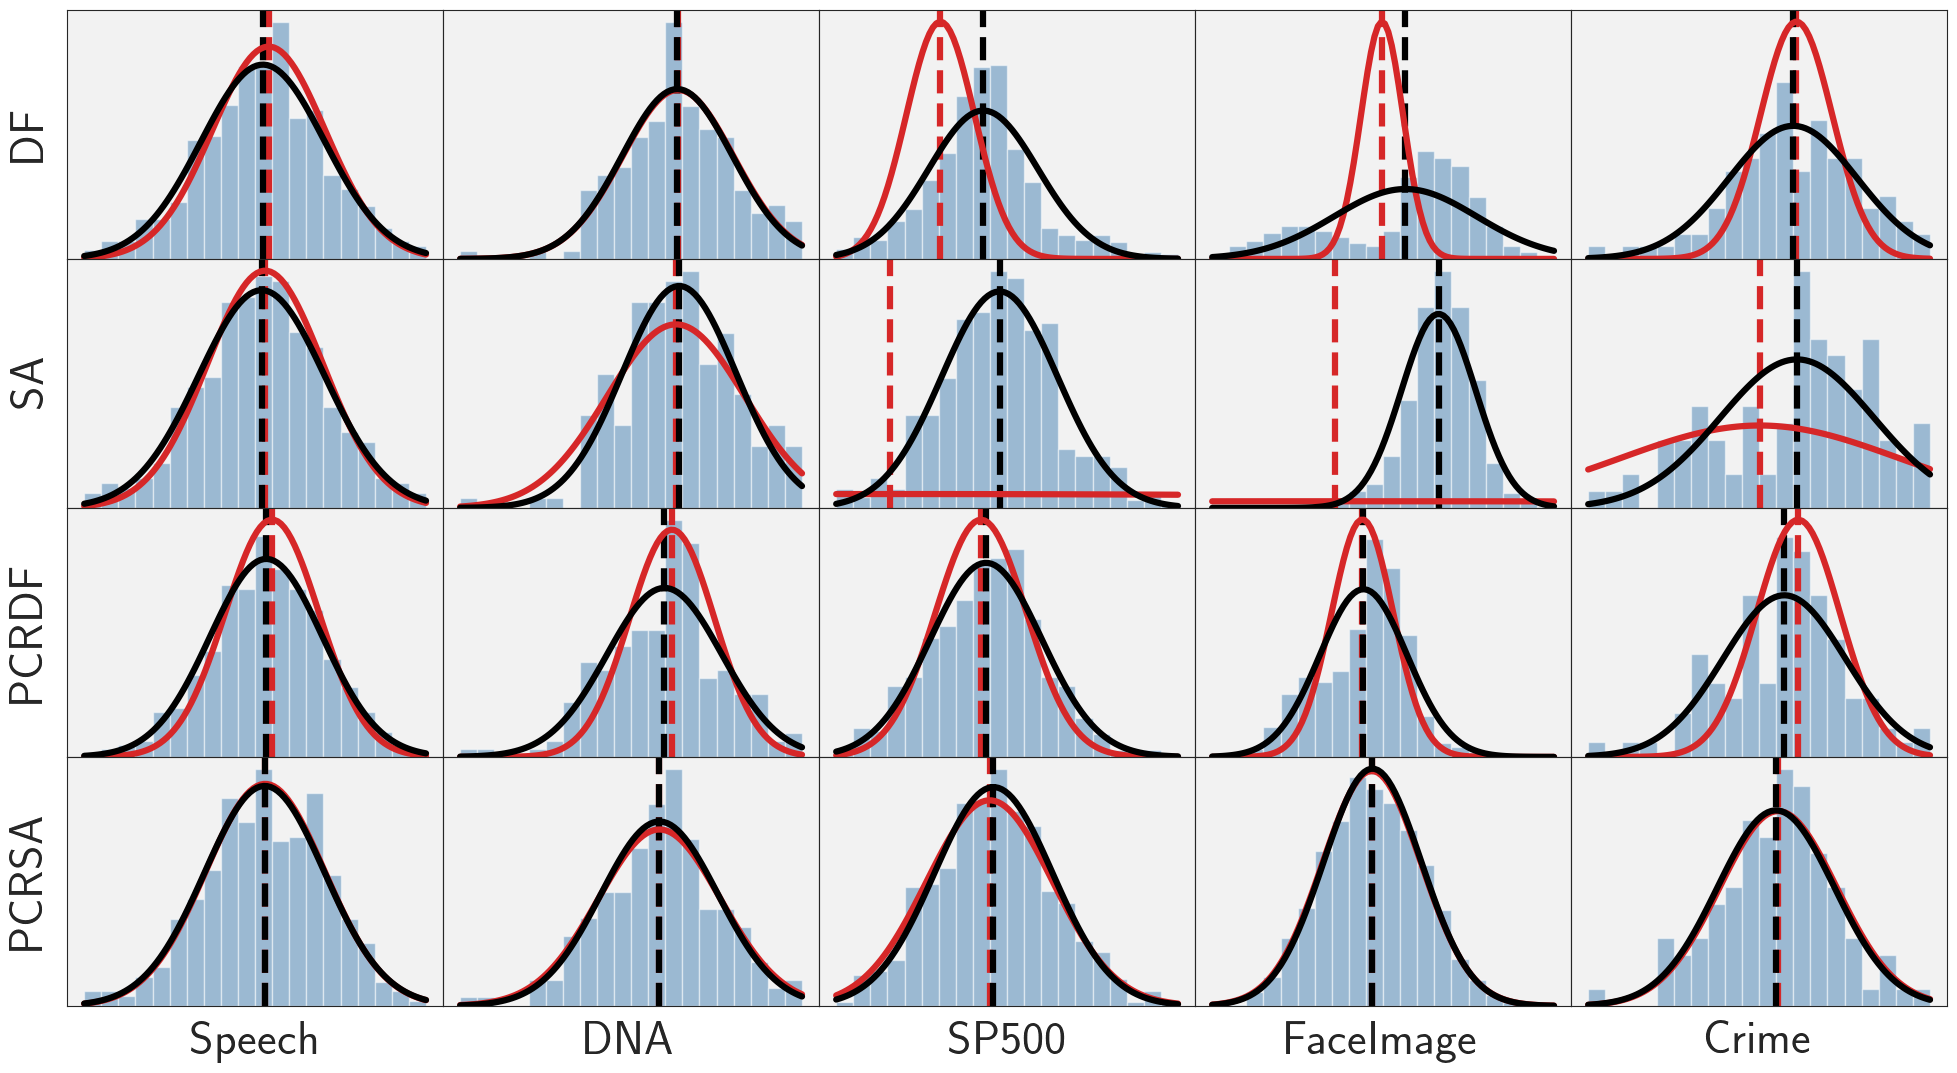

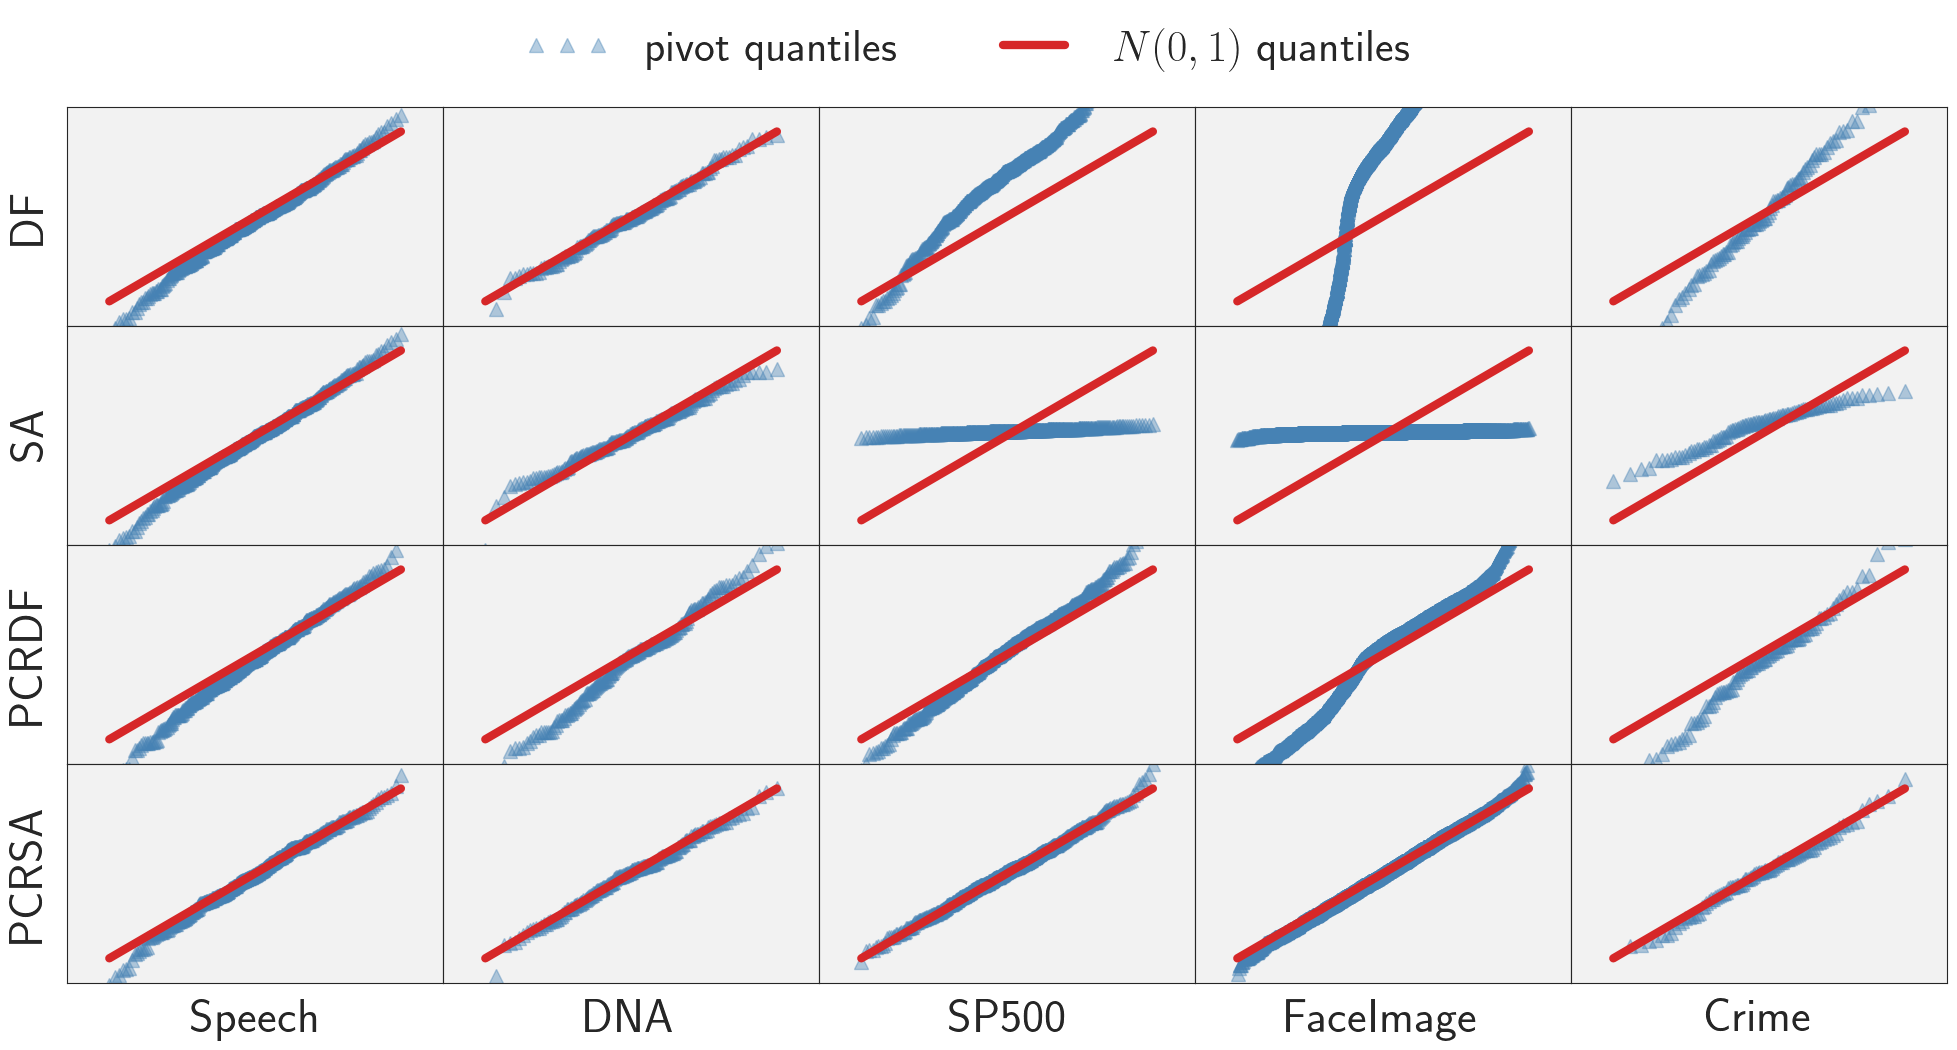

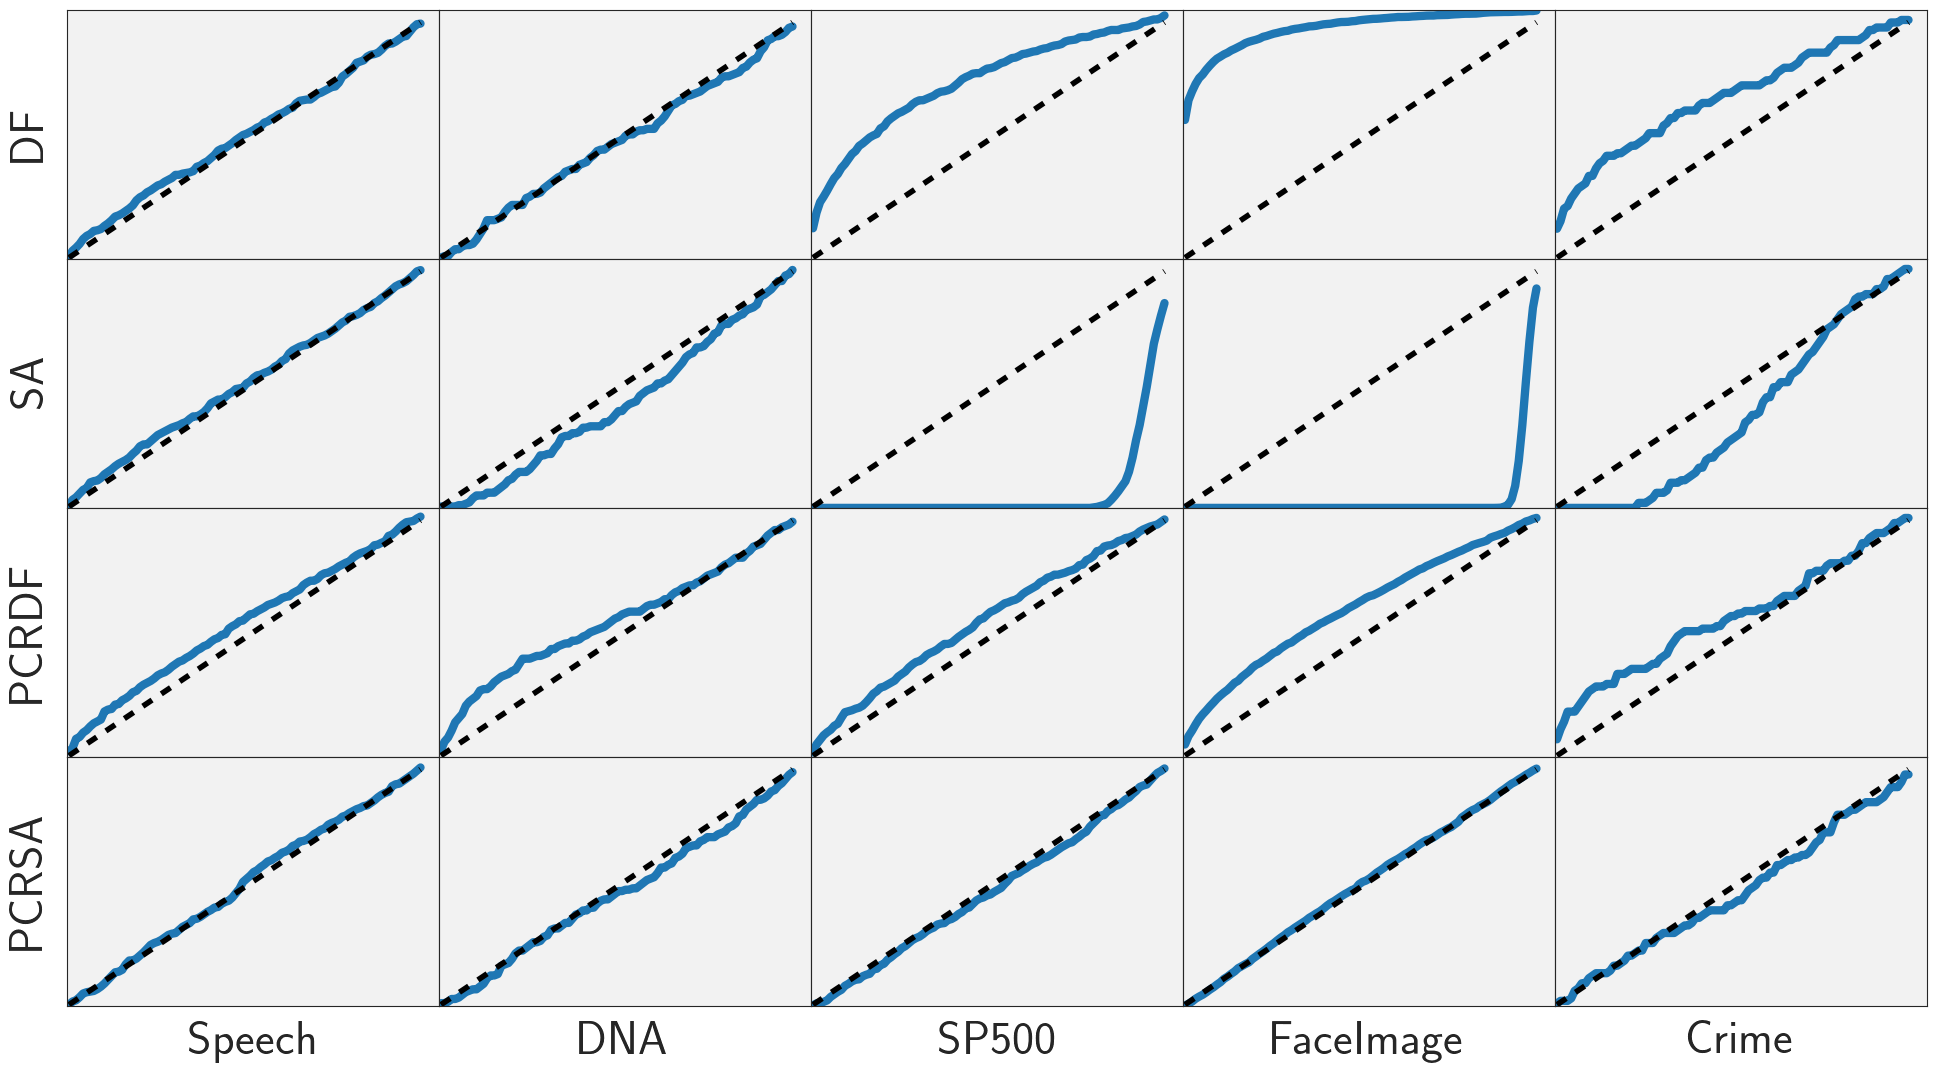

In [72]:
### PCR real designs, Align-Strength 1 (Hard Detection) ###
np.random.seed(38) #34

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

balance,lam_l1,lam_l2=0.8,1,0.1
sparse=0.3
J1_true=[-2,-4,-6]
pcan=10**5
mag=[-20,10]
pltn, pltp=4,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig2, axs2 = plt.subplots(pltn, pltp, figsize=(20, 12))
fig3, axs3 = plt.subplots(pltn, pltp, figsize=(20, 12))

align_strength=1

NUMv=10
SCORE=np.zeros((NUMv, pltp))
PVAL=np.zeros((NUMv, pltp))
PVAL_COR=np.zeros((NUMv, pltp))

pcan=10**5

_, X, _=speech_design(40910,200)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
v1, V1=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL1=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)

J=10
_, X, _=dna_design(40670,100)
v,V=LA.eigh(X.T@X)
v2, V2=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL2=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)

J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
v,V=LA.eigh(X.T@X)
v3, V3=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL3=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)


J=100
_, X, _=face_design()
v,V=LA.eigh(X.T@X)
v4, V4=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL4=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)

J=10
_, X, _=crime_design(50)
v,V=LA.eigh(X.T@X)
v5, V5=v, V
n,p=X.shape
s=np.round(sparse*p)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true,align_strength)
trueAL5=np.abs(V.T@beta/np.linalg.norm(beta))
beta_pca, sigmasq_hat, omegahat=output_res(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res(axs2, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,0)
output_res(axs3, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
ylab=['DF', 'SA','PCRDF','PCRSA']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=34)
            axs2[i, j].set_xlabel(xlab[j], fontsize=34)
            axs3[i, j].set_xlabel(xlab[j], fontsize=34)

        if j==0:
            axs1[i, j].set_ylabel(ylab[i], fontsize=34)
            axs2[i, j].set_ylabel(ylab[i], fontsize=34)
            axs3[i, j].set_ylabel(ylab[i], fontsize=34)

        axs1[i, j].tick_params(axis='x',labelsize=34)
        axs1[i, j].tick_params(axis='y',labelsize=34)
        axs2[i, j].tick_params(axis='x',labelsize=34)
        axs2[i, j].tick_params(axis='y',labelsize=34)
        axs3[i, j].tick_params(axis='x',labelsize=34)
        axs3[i, j].tick_params(axis='y',labelsize=34)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])
            axs2[i, j].set_xticklabels([])
            axs2[i, j].set_yticklabels([])
            axs3[i, j].set_xticklabels([])
            axs3[i, j].set_yticklabels([])


for ax in axs2.flat:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

for ax in axs3.flat:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.98, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_hardDetect.pdf'
fig1.savefig(filename)

fig2.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
fig2.legend(['pivot quantiles', r'$N(0,1)$ quantiles'], loc='upper center', ncol=4, prop = { "size": 32 }, bbox_to_anchor=(0.5, 0.98), edgecolor='white', numpoints=3,facecolor='white')
filename=filepath+'panel_pcr_real_qq_hardDetect.pdf'
fig2.savefig(filename)

fig3.subplots_adjust(left=0.06, right=0.99, bottom=0.15, top=0.98, wspace=0, hspace=0.)
filename=filepath+'panel_pcr_real_FCP_hardDetect.pdf'
fig3.savefig(filename)

The cell below reproduces:
- Fig. 3, right-column (alignment test for 5 real-data designs, hard detect experiment)

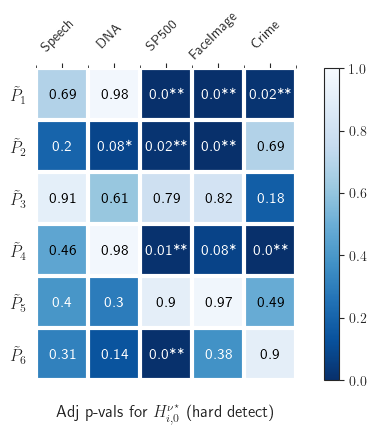

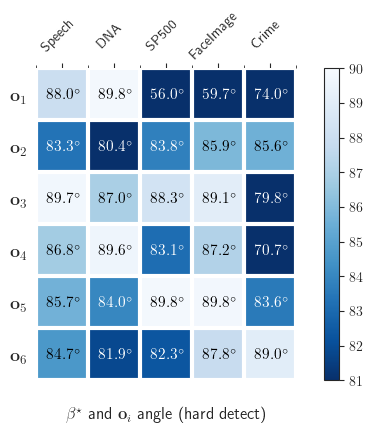

In [73]:
import matplotlib.colors as colors

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

window=6
heat=PVAL_COR[:window,:]

# Assuming column_names is a list of your column names
column_names = ['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']  # Example column names
row_names=[r'$\tilde{P}_'+str(num+1)+'$' for num in range(window)]


# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=0, vmax=1)
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names, fontsize=12)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        color="w"
        if heat[i, j]>0.4:
            color="black"
        if heat[i, j]>0.1:
            val=str(np.round(heat[i, j],2))
        elif heat[i, j]>0.05:
            val=str(np.round(heat[i, j],2))+'*'
        else:
            val=str(np.round(heat[i, j],2))+'**'

        text = ax.text(j, i, val,
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'Adj p-vals for $H_{i,0}^{\nu^\star}$ (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatPvals_hardDetect.pdf', bbox_inches='tight')

plt.show()

# Assuming trueAL1, trueAL2, trueAL3, trueAL4, and trueAL5 are defined somewhere above
plt.rcParams['text.usetex'] = True
window = 6
heat = np.vstack((trueAL1[-window:], trueAL2[-window:], trueAL3[-window:], trueAL4[-window:], trueAL5[-window:]))
heat = (heat.T)[::-1,:]
heat = np.rad2deg(np.arccos(heat))

# Assuming column_names is a list of your column names
column_names = ['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']  # Example column names
row_names=[r'$\mathbf{o}_'+str(num+1)+'$' for num in range(window)]

#[r'$\nu^\star$','v1','v1','v1','v1']

# Plotting the heatmap
fig, ax = plt.subplots()
norm = colors.Normalize(vmin=81, vmax=90)
cax = ax.imshow(heat, cmap='Blues_r',norm=norm)

# Adding colorbar
fig.colorbar(cax)

# Setting the x-ticks to match the column names and positioning them at the top
ax.set_xticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names,fontsize=10)

ax.set_yticks(np.arange(len(row_names)))
ax.set_yticklabels(row_names,fontsize=13)

ax.xaxis.tick_top()  # This moves the x-axis ticks to the top

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(heat.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(heat.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3) # change the appearance of your padding here
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if heat[i, j]>84.1:
            color="black"
        else:
            color="w"
        text = ax.text(j, i, r'$'+str(np.round(heat[i, j],1))+'^\circ$',
                       ha="center", va="center", color=color,fontsize=11)

# Adjusting the tick labels to appear higher
plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", position=(0,1.06))

plt.title(r'$\beta^\star$ and $\mathbf{o}_i$ angle (hard detect)', y=-0.15, fontsize=12)

# Adjust layout to make room
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.96)

# Save the figure with enough padding
plt.savefig(filepath+'heatTrueAgl_hardDetect.pdf', bbox_inches='tight')


plt.show()

# Misspecification 1: Non-rotationally-invariant designs

The following two cells demmonstrate our methods where designs are not rotationally invariant as discussed in Section 4.

In [74]:
def output_res_miss(axs, X,v,V,y,J,pcan, lam_l1, lam_l2, col,plttype=1):

    n,p=X.shape
    beta_hat, beta_deb_o, beta_deb_g, taug, tau1,_=run_va2(X,y)
    beta_deb_pcr,tau_pcr, beta_deb_gpcr, tau_gpcr,sigmasq_hat = run_pcr(J, pcan, X, v, V, y, lam_l1=lam_l1, lam_l2=lam_l2)
    beta_pca, beta_proj=run_pcr_pure(J, X,v,V,y)
    score=(beta_pca)/np.sqrt(sigmasq_hat*v[-J:]+max(1/p*LA.norm(beta_deb_pcr)**2-tau_pcr,0))

    P_o=2*(1-normst.cdf(np.abs(score), loc=0, scale=1))
    P_o=P_o[::-1]
    score=score[::-1]

    SCORE[:,col]=score[:NUMv]
    PVAL[:,col]=P_o[:NUMv]

    reject, P_o_corrected=fdrcorrection(P_o, alpha=0.05, method='indep', is_sorted=False)
    PVAL_COR[:,col]=P_o_corrected[:NUMv]

    if plttype==1:
        ## Histogram plot
        plot_C((beta_deb_pcr+beta_proj-beta)/np.sqrt(tau_pcr),0, axs[0,col], '')

    elif plttype==2:
        ## CI for \beta^\star
        alpha_arr=np.linspace(0.005, 0.95, 100)
        FCP=proc_CI(alpha_arr, beta_deb_pcr+beta_proj, tau_pcr, beta)
        plot_CI(alpha_arr, axs[1,col], FCP)

    return beta_hat, beta_deb_o, beta_deb_g, taug, tau1,beta_deb_pcr,tau_pcr, beta_deb_gpcr, tau_gpcr,beta_pca, beta_proj,P_o


def simulate_signal_response_miss(X,Z,J1_true):

    n,p=X.shape

    # Simulate signal
    zeta=mix_signal(p,s,mag,balance)

    if len(J1_true)>0:
        scalJ1=5*np.sqrt(p)*np.random.binomial(1,1,len(J1_true))
        beta_ali=V[:,J1_true]@scalJ1
    else:
        scalJ1,beta_ali=0,0
    beta=zeta+beta_ali

    # Simulate response
    _, p_mis = Z.shape
    beta_mis = mix_signal(p_mis,p_mis//2,[-5,2],0.4)
    ep=np.random.normal(0,1,size=n)
    y = X@beta + Z@beta_mis + ep

    nustar=[0]*J
    for i in range(1,J):
        if -i not in J1_true:
            nustar[-i]=0
        else:
            nustar[-i]=scalJ1[0]

    return zeta, nustar, beta_ali, beta, ep, y

The cells below reproduce
- Fig. 4 (empirical distribution of pivotal quantities and FCP)

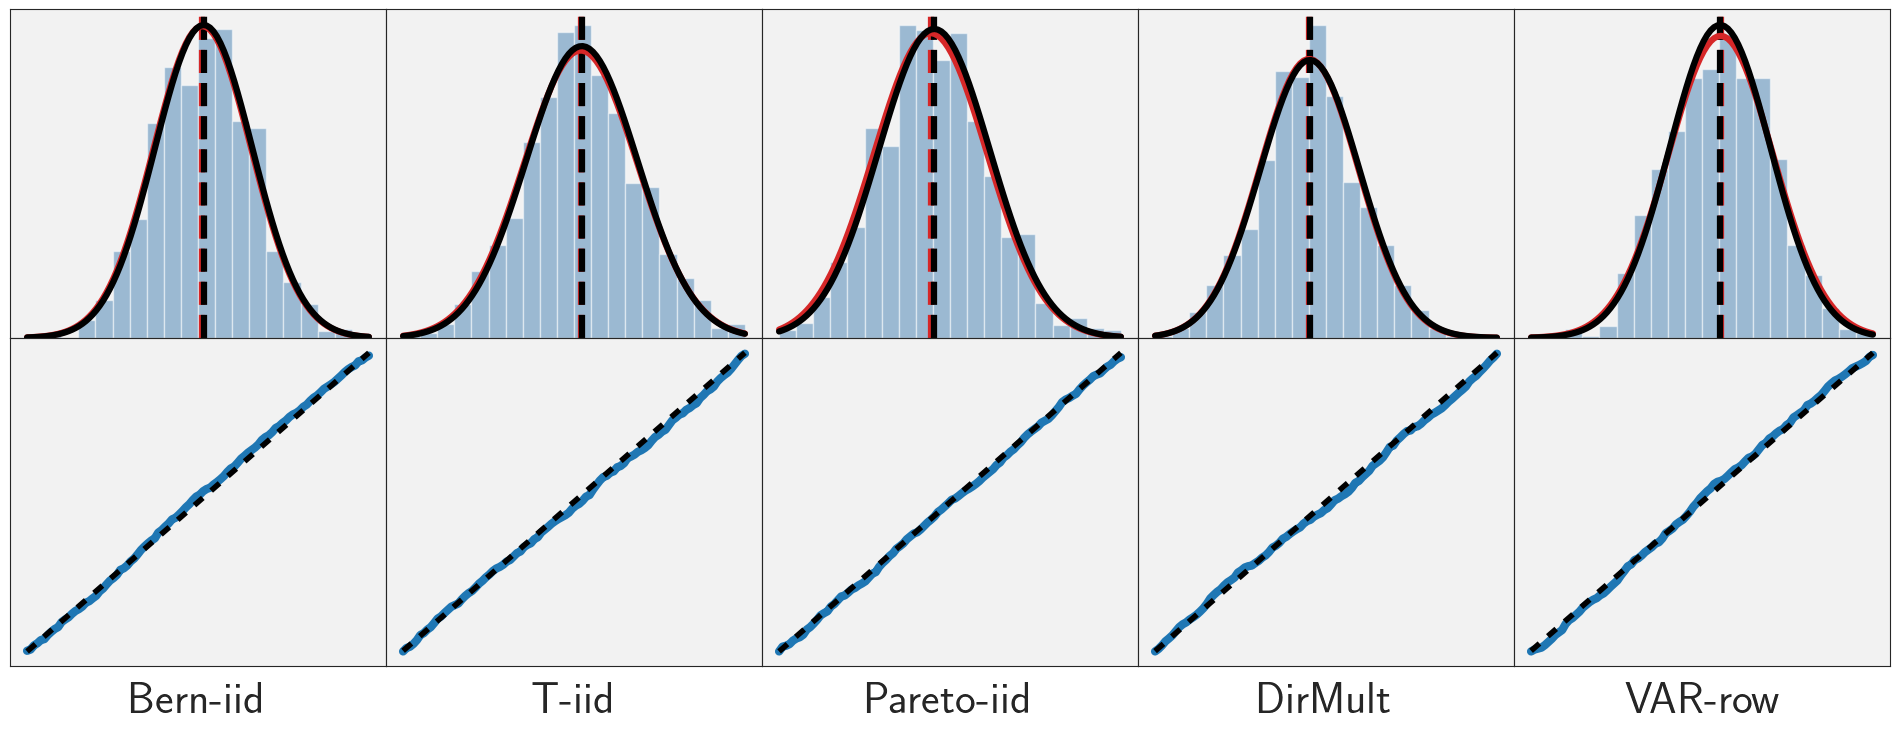

In [75]:
### Non-rotationally invariant designs ###
np.random.seed(1) #199
n,p,s,balance,lam_l1,lam_l2=500,1000,300,0.8,1,0.1
J1_true=[-2,-4,-6]
pcan=10**5
mag=[-20,10]

pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))

NUMv=10
SCORE=np.zeros((NUMv, pltp))
PVAL=np.zeros((NUMv, pltp))
PVAL_COR=np.zeros((NUMv, pltp))


J=40
X=bern_design(n,p)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=40
_, X, _=tiid_design(n, p,arn=0., arp=0.0,df=2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=40
_, X, _=paretoiid_design(n, p,arn=0,arp=0, df=2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)


J=40
_, X, _=dirMultinom_design(n, p, p)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=40
_, X, _=VARH_design(n, p, 0.7,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response(X,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Bern-iid', 'T-iid' ,'Pareto-iid', 'DirMult', 'VAR-row']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_noorth_short.pdf'
fig1.savefig(filename)

# Misspecfication 2: Missing Features
The cells below show how our methods perform when there are unobserved features.


The cells below reproduce
- Fig. S14 - Fig. S18 in SI Appendix

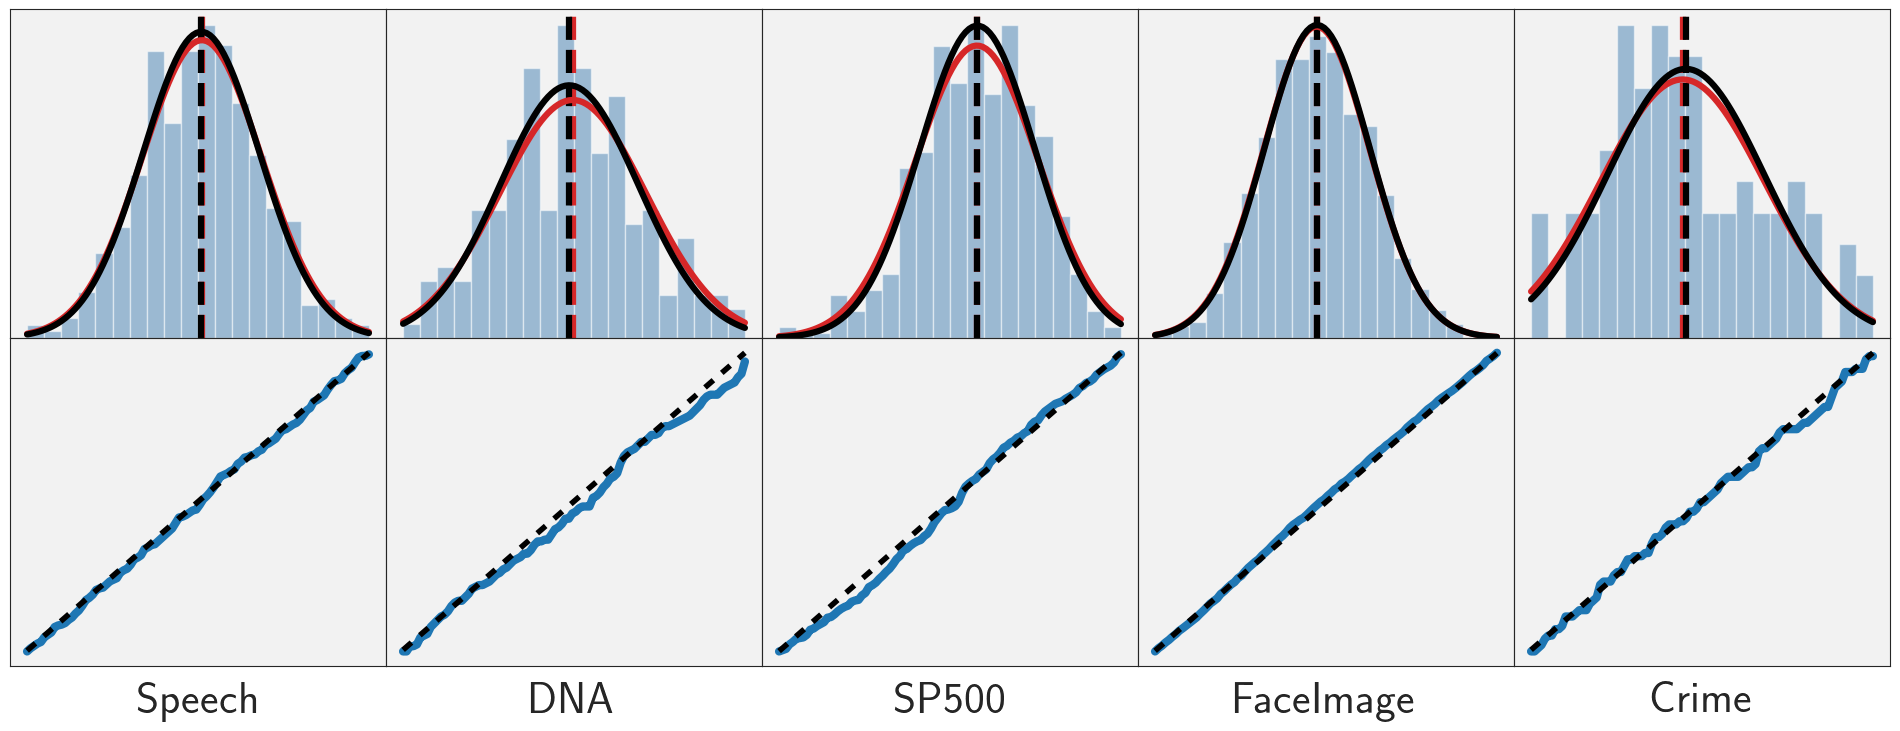

In [76]:
### Z from Gaussian ###
np.random.seed(1)


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

J1_true=[-2, -4, -6]
pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))

s,balance,lam_l1,lam_l2=300,0.8,1,0.1
mag=[-20,10]
pcan=10**5


_, X, _=speech_design(40910,200)
n,p=X.shape
_, Z, _=corrGau_design(n, p//2, arn=0.5, df=100)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=10
_, X, _=dna_design(40670,100)
n,p=X.shape
_, Z, _=corrGau_design(n, p//2, arn=0.5, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
n,p=X.shape
_, Z, _=corrGau_design(n, p//2, arn=0.5, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)



J=100
_, X, _=face_design()
n,p=X.shape
_, Z, _=corrGau_design(n, p//2, arn=0.5, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=10
_, X, _=crime_design(50)
n,p=X.shape
_, Z, _=corrGau_design(n, p//2, arn=0.5, df=100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_misfeat.pdf'
fig1.savefig(filename)

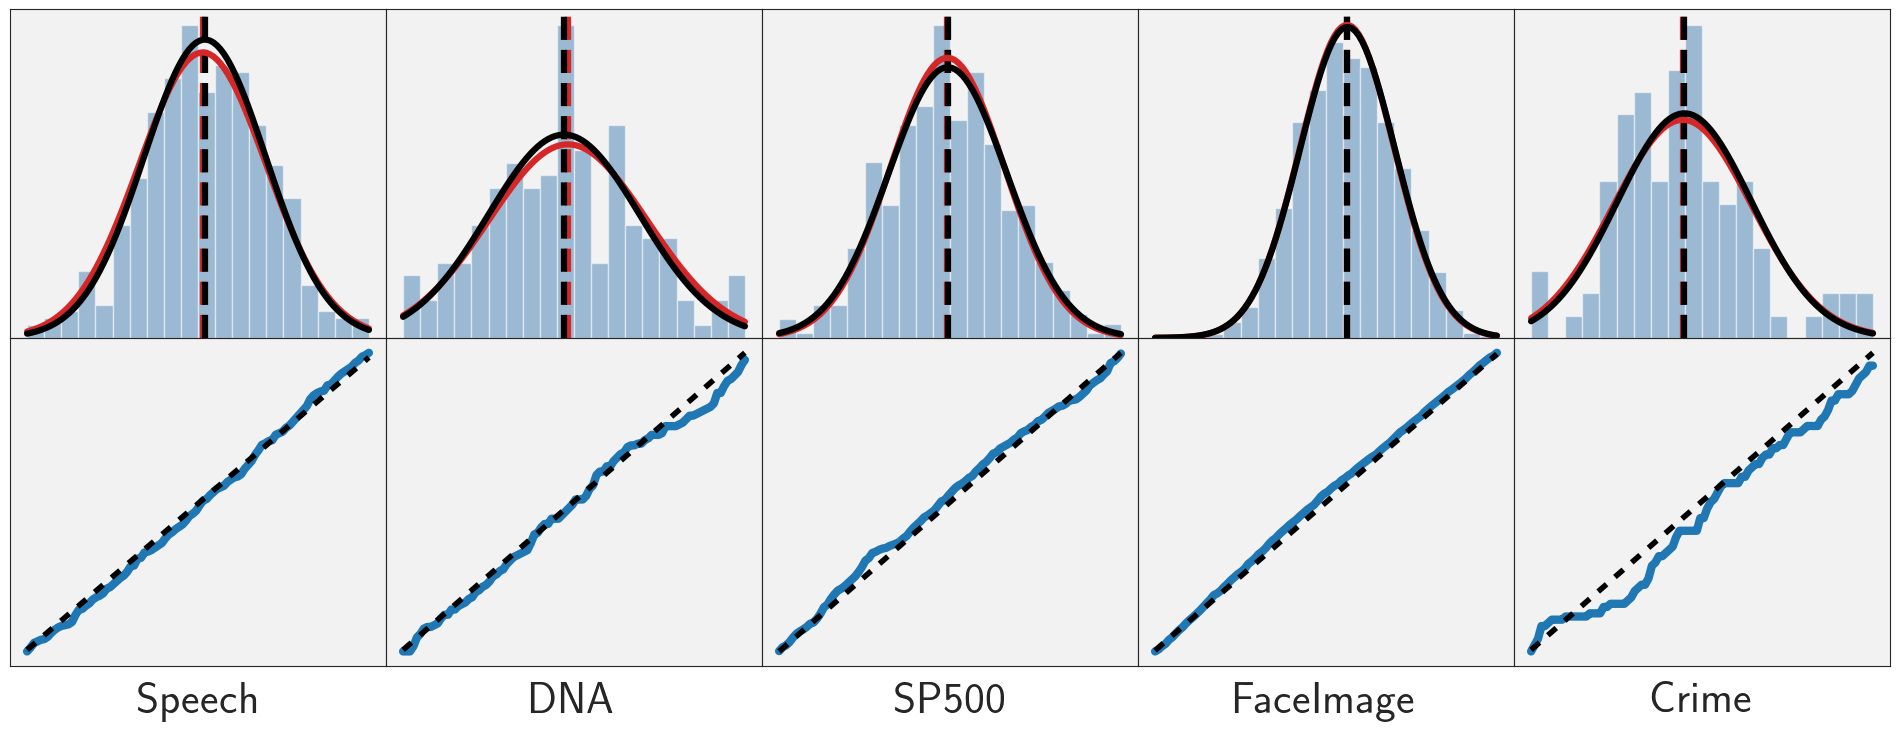

In [77]:
### Z from T ###

np.random.seed(315)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

J1_true=[-2, -4, -6]
pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))

s,balance,lam_l1,lam_l2=300,0.8,1,0.1
mag=[-20,10]
pcan=10**5


_, X, _=speech_design(40910,200)
n,p=X.shape
_, Z, _=multiT_design(n, p//2,arn=0., arp=0.0,df=3)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=10
_, X, _=dna_design(40670,100)
n,p=X.shape
_, Z, _=multiT_design(n, p//2,arn=0., arp=0.0,df=3)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
n,p=X.shape
_, Z, _=multiT_design(n, p//2,arn=0., arp=0.0,df=3)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)



J=100
_, X, _=face_design()
n,p=X.shape
_, Z, _=multiT_design(n, p//2,arn=0., arp=0.0,df=3)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=10
_, X, _=crime_design(50)
n,p=X.shape
_, Z, _=multiT_design(n, p//2,arn=0., arp=0.0,df=3)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_misfeatT.pdf'
fig1.savefig(filename)

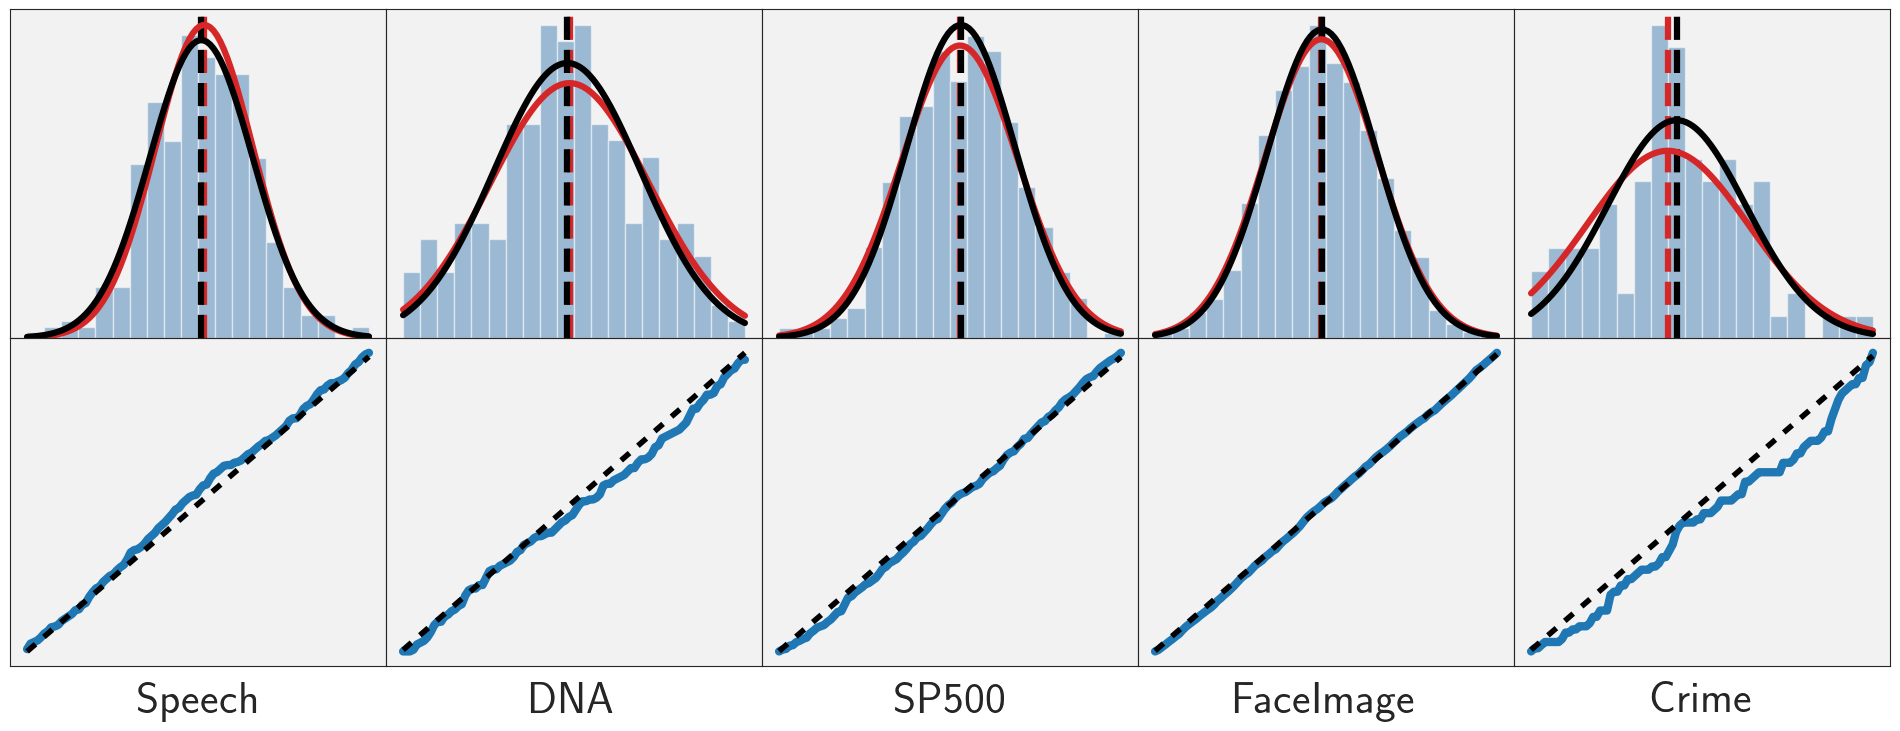

In [78]:
### Z from Spike ###

np.random.seed(3)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

J1_true=[-2, -4, -6]
pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))

s,balance,lam_l1,lam_l2=300,0.8,1,0.1
mag=[-20,10]
pcan=10**5


_, X, _=speech_design(40910,200)
n,p=X.shape
_, Z, _=spike_design(n, p//2, m=20, mag=10)
X=X[:,:]

X0=X
J=10
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=10
_, X, _=dna_design(40670,100)
n,p=X.shape
_, Z, _=spike_design(n, p//2, m=20, mag=10)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
n,p=X.shape
_, Z, _=spike_design(n, p//2, m=20, mag=10)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)



J=100
_, X, _=face_design()
n,p=X.shape
_, Z, _=spike_design(n, p//2, m=20, mag=10)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=10
_, X, _=crime_design(50)
n,p=X.shape
_, Z, _=spike_design(n, p//2, m=20, mag=10)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_misfeatSpike.pdf'
fig1.savefig(filename)

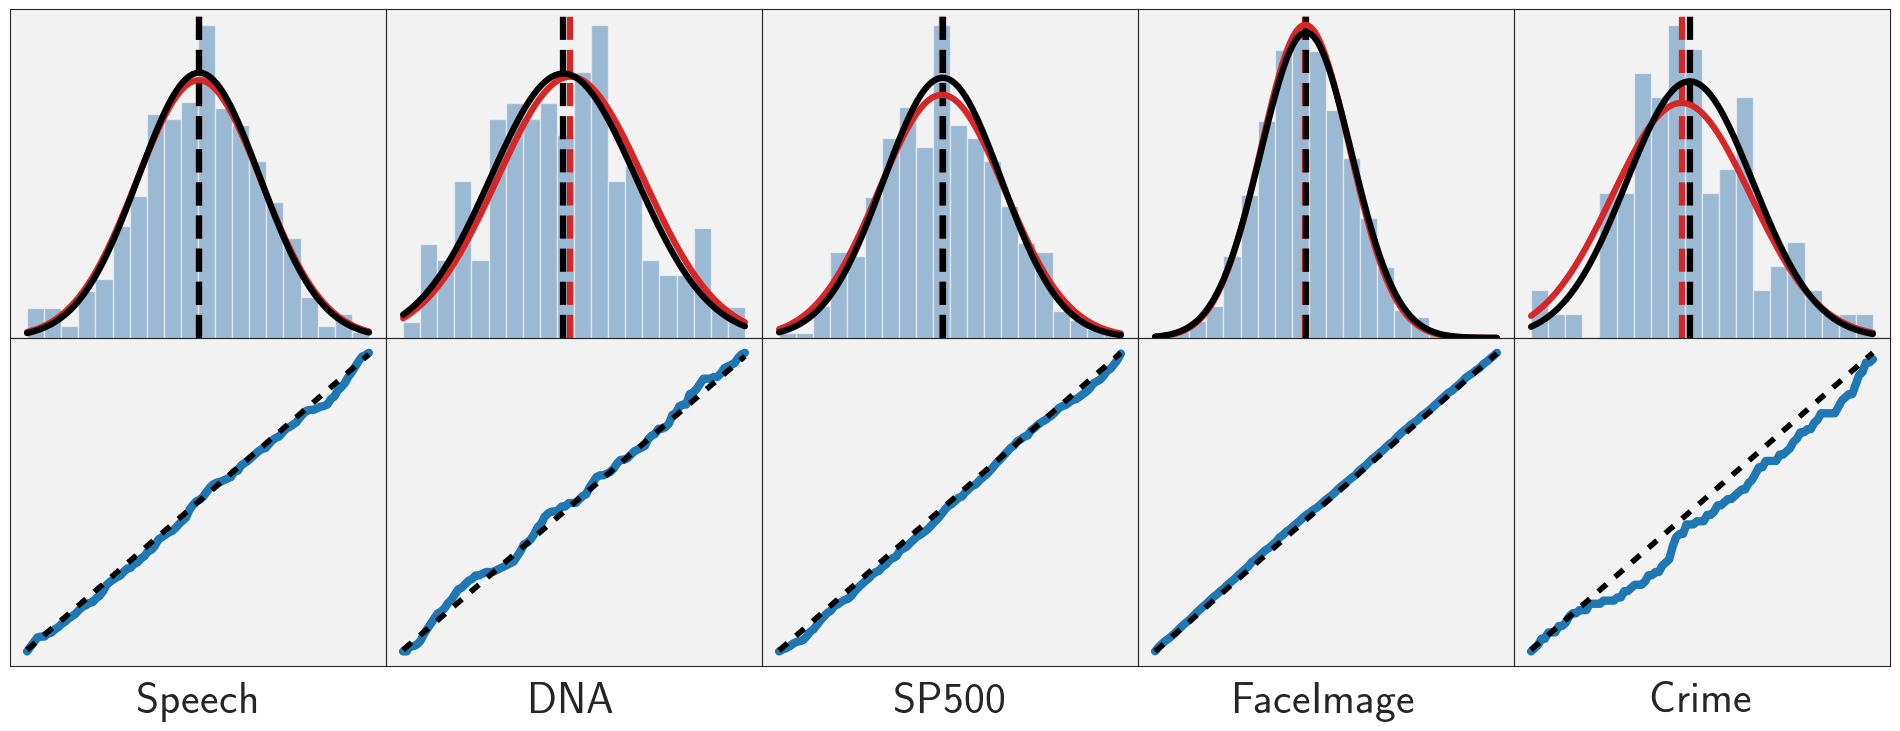

In [79]:
### Z from VAR ###
np.random.seed(4)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

J1_true=[-2, -4, -6]
pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))


s,balance,lam_l1,lam_l2=300,0.8,1,0.1
mag=[-20,10]
pcan=10**5


_, X, _=speech_design(40910,200)
n,p=X.shape
_, Z, _=VAR_design(n, p//2, 0.4,100)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=10
_, X, _=dna_design(40670,100)
n,p=X.shape
_, Z, _=VAR_design(n, p//2, 0.4,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
n,p=X.shape
_, Z, _=VAR_design(n, p//2, 0.4,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)



J=100
_, X, _=face_design()
n,p=X.shape
_, Z, _=VAR_design(n, p//2, 0.4,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=10
_, X, _=crime_design(50)
n,p=X.shape
_, Z, _=VAR_design(n, p//2, 0.4,100)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_misfeatVAR.pdf'
fig1.savefig(filename)


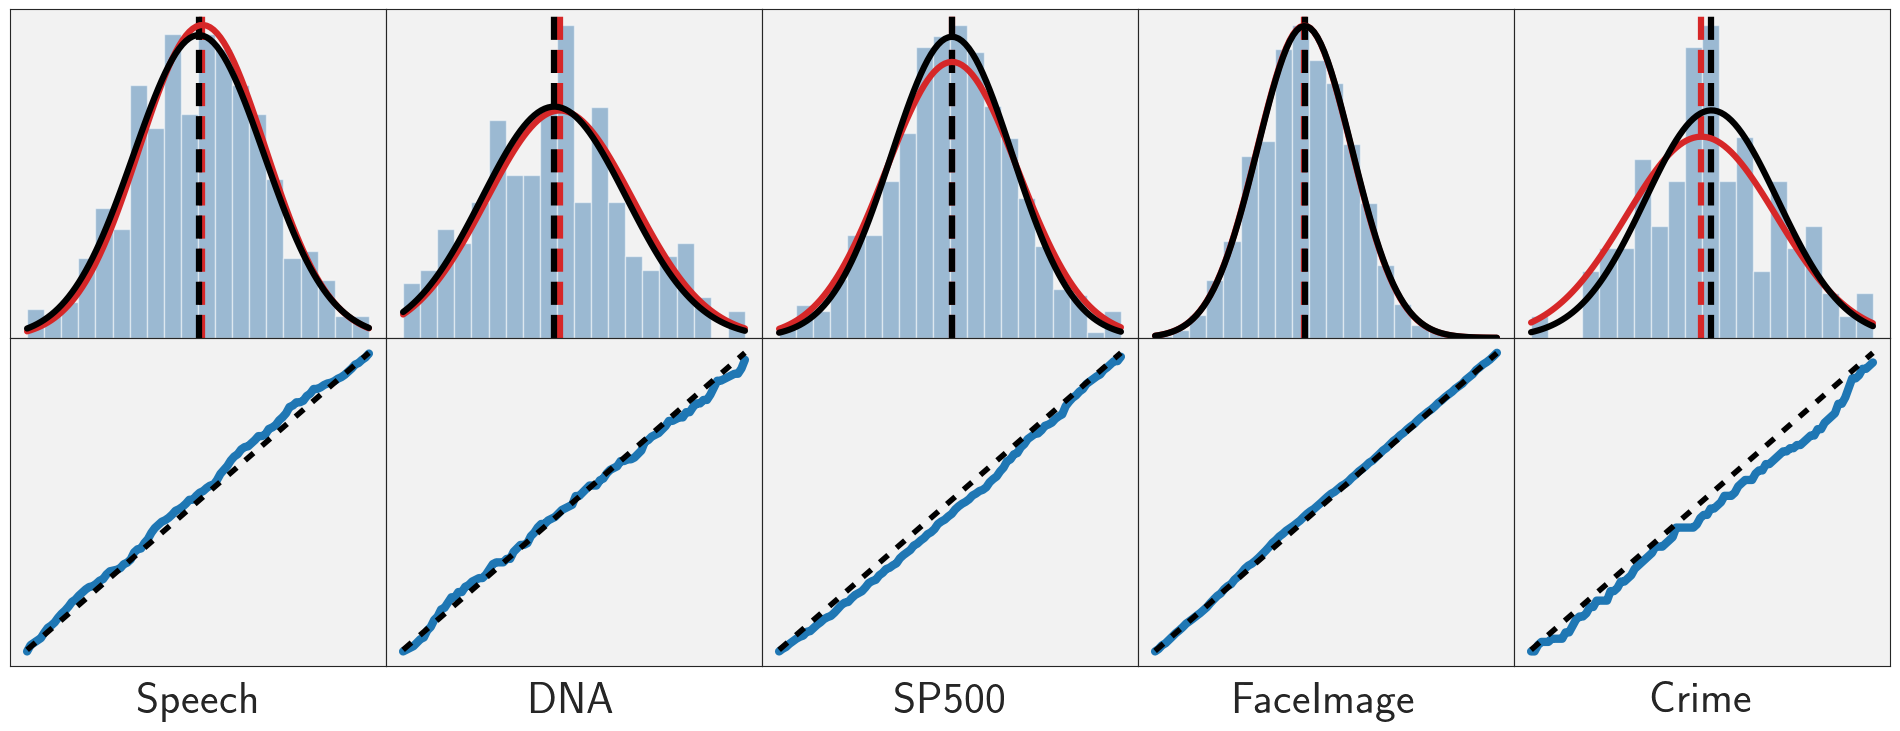

In [80]:
### Z from LNN ###
np.random.seed(5)


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

J1_true=[-2, -4, -6]
pltn, pltp=2,5
fig1, axs1 = plt.subplots(pltn, pltp, figsize=(20, 9))


s,balance,lam_l1,lam_l2=300,0.8,1,0.1
mag=[-20,10]
pcan=10**5

_, X, _=speech_design(40910,200)
n,p=X.shape
_, Z, _=lnn_design_mis(n, p//2)
X=X[:,:]
X0=X
J=10
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 0,2)


J=10
_, X, _=dna_design(40670,100)
n,p=X.shape
_, Z, _=lnn_design_mis(n, p//2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 1,2)


J=10
_, X, _=stock_design(use_pickle=True, pkl_file='returns.pkl', date_start='2021-01-01', date_end='2022-12-31', corr=1,lastRows=300)
n,p=X.shape
_, Z, _=lnn_design_mis(n, p//2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 2,2)



J=100
_, X, _=face_design()
n,p=X.shape
_, Z, _=lnn_design_mis(n, p//2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 3,2)


J=10
_, X, _=crime_design(50)
n,p=X.shape
_, Z, _=lnn_design_mis(n, p//2)
v,V=LA.eigh(X.T@X)
zeta, nustar, beta_ali, beta, ep, y=simulate_signal_response_miss(X,Z,J1_true)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4)
output_res_miss(axs1, X,v,V,y,J,pcan, lam_l1, lam_l2, 4,2)


xlab=['Speech', 'DNA' ,'SP500', 'FaceImage', 'Crime']
for i in range(pltn):
    for j in range(pltp):
        if i==pltn-1:
            axs1[i, j].set_xlabel(xlab[j], fontsize=32)

        axs1[i, j].tick_params(axis='x',labelsize=32)
        axs1[i, j].tick_params(axis='y',labelsize=32)

for i in range(pltn):
    for j in range(pltp):
            axs1[i, j].set_xticklabels([])
            axs1[i, j].set_yticklabels([])


fig1.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.88, wspace=0, hspace=0)
filename=filepath+'panel_pcr_real_misfeatLNN.pdf'
fig1.savefig(filename)